### Imports

In [1]:
#official libraries
import numpy as np
import matplotlib.pyplot as plt
import pylab 
import cmath
import random
from scipy import integrate
from scipy.fftpack import fft
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from scipy import signal
import pandas as pd
import time
import torch.nn as nn
import torch.nn.functional as F
import time 
import visdom
from os.path import expanduser

In [2]:
#own files
from lib.utils_general import diff_same_length, get_data_paths
from lib.utils_generate_W import get_grid, gauss_dist, generate_W
from lib.utils_generate_n import n_compl, plot_n
from lib.utils_calc_psi import plot_psi
from lib.utils_generate_data import generate_init_data, generate_init_data_diverse, \
                                    plot_sample, generate_corr_data
from lib.utils_initial_dataset import InitialDataset, ToTensor, OneChannel, Normalize, calc_mean_std
from lib.utils_train import get_dataloaders, train_net
from lib.nets import FNN, UNet
from lib.utils_evaluation import DeNorm, plot_prediction, plot_correction
from lib.utils_corrector_dataset import CorrectorDataset, NormalizeCorr, calc_mean_std_corr, ToDevice
from lib.utils_train_corrector import train_corrector
from lib.UNet_featurek import UNet_featurek
from lib.LSTM import LSTM
from lib.plot_intensity_bars import plot_intensity_bars
from lib.LSTMFFout import LSTMFFout

In [3]:
torch.cuda.is_available()

False

### Parameter, paths, etc

In [6]:
# ---------------------------------
# choose which mode the prg is in:
# ---------------------------------
do_load_model = False
#do_load_model_corr = False
do_train_model = True  # not do_load_model
#do_train_model_corr = not do_load_model_corr
do_create_initial_data = True
do_create_test_data = False
#do_create_corrector_data = True
toy_data = True #if run on GPU machine, set to false
which_model = 'LSTM' #FNN / UNet / UNet_old / UNet_featurek / LSTM
#which_model_corr = 'UNet'
# ---------------------------------

# ---------------------------------
# paths:
# ---------------------------------
home = expanduser("~")

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# models
path_model = 'models/' + which_model + '.pt'
path_model_corr = 'models/' + which_model + '_corr.pt'

# data
path_initial_data, path_corrector_data = get_data_paths(toy_data, device, home)

path_initial_data_diverse = home + '/ml_data/data_initial_diverse/'
path_test_data = home + '/ml_data/data_test/'

# plots
path_plots = 'plots/'
# ---------------------------------

# ---------------------------------
# hyperparameters:
# ---------------------------------
learning_rate = 0.0001 # for UNet: 0.000001
nmbr_epochs = 20
early_stopping = 100
validation_split = 0.2
# ---------------------------------

# ---------------------------------
# data parameters:
# ---------------------------------
half_width = 5
nmbr_points = 10000
if toy_data:
    size_dataset = 50 #if run on GPU machine, set to 5000 (toydata 8)
else:
    size_dataset = 50000

grid, stepsize = get_grid(half_width, nmbr_points)
# ---------------------------------

In [7]:
path_initial_data

'toy_data/initial_data/'

### Generate Initial Data

In [8]:
if do_create_initial_data:
    generate_init_data_diverse(size_dataset, path = path_initial_data, x = grid, dx = stepsize)

Generating Pot Nmbr  0 , Runtime since last:  0.2185218334197998 , Runtime so far:  0.2185211181640625


20723


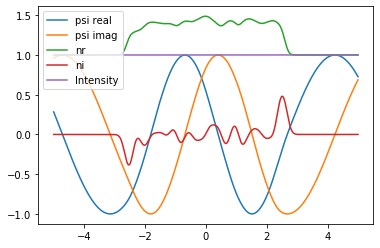

In [5]:
#show that it worked
plot_sample(size_dataset, path = path_initial_data_diverse, x = grid, dx = stepsize)

### Create Initial Dataset

In [6]:
nr_mean, nr_std, ni_mean, ni_std = calc_mean_std(size_dataset, path_initial_data_diverse)
#nr_mean, nr_std, ni_mean, ni_std = 0, 1, 0, 1

In [9]:
ni_std

0.06458081744787306

In [8]:
transform = transforms.Compose([#Normalize((nr_mean, ni_mean), (nr_std, ni_std)),
                                    ToTensor(device)
                                   ])

In [9]:
initial_dataset = InitialDataset(csv_file = path_initial_data_diverse + 'k_values.csv', 
                               root_dir = path_initial_data_diverse,
                               transform = transform)

In [10]:
len(initial_dataset)

150000

tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0')
torch.Size([10001])
True
k:  1.0


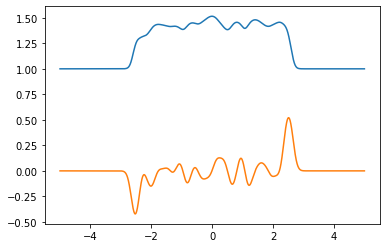

In [30]:
#show that it worked
idx = np.random.randint(len(initial_dataset))

print(initial_dataset[idx]['k_n_r'])
print(initial_dataset[idx]['k_n_r'].size())
print(initial_dataset[idx]['k_n_r'].is_cuda)

print('k: ', initial_dataset[idx]['k_n_r'].cpu().numpy()[0] ) # DeNorm(initial_dataset[idx]['k_n_r'].cpu().numpy()[0], nr_mean, nr_std))

plt.plot(grid,initial_dataset[idx]['k_n_r'].cpu().numpy()[1:])
plt.plot(grid,initial_dataset[idx]['n_i'].cpu().numpy())

### Create Dataloaders and Model

In [31]:
train_loader, validation_loader = get_dataloaders(initial_dataset, 
                                                  batch_size = 8, 
                                                  validation_split = validation_split, 
                                                  shuffle_dataset = True, 
                                                  random_seed= 42)

In [33]:
#evtl soll nicht ein neues Model erstellt, sondern ein altes geladen werden!

if do_load_model:
    model = torch.load(path_model, map_location=device) # , map_location=device
else:
    #sonst wird jetzt neues Model erstellt
    if which_model == 'FNN':
        model = FNN(n_feature=10001, n_hidden=1000, n_output=10000)
    elif which_model == 'UNet_featurek':
        model = UNet_featurek(device, n_channels=1, n_classes=1, label_len = nmbr_points)
    elif which_model == 'LSTM':
        #model = LSTM(10, 100, 3, 1000, device)
        model = LSTM(10, 100, 3, 1000, device)
    else:
        model = UNet(n_channels=1, n_classes=1, label_len = nmbr_points)

print(model)

LSTM(
  (lstm): LSTM(11, 100, num_layers=3, batch_first=True)
  (fc): Linear(in_features=100, out_features=10, bias=True)
)


In [34]:
model.to(device)
next(model.parameters()).is_cuda

True

### Training

In [35]:
if do_train_model:
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model, info = train_net(nmbr_epochs, model, criterion, optimizer,
                            train_loader, validation_loader, early_stopping= early_stopping, path=path_model)

[1,     1] loss: 0.007 runtime: 0.100271
[1,    11] loss: 0.064 runtime: 1.131470
[1,    21] loss: 0.077 runtime: 2.146700
[1,    31] loss: 0.065 runtime: 3.180588
[1,    41] loss: 0.094 runtime: 4.230112
[1,    51] loss: 0.062 runtime: 5.262725
[1,    61] loss: 0.041 runtime: 6.303093
[1,    71] loss: 0.062 runtime: 7.350345
[1,    81] loss: 0.048 runtime: 8.411876
[1,    91] loss: 0.099 runtime: 9.490558
[1,   101] loss: 0.064 runtime: 10.563941
[1,   111] loss: 0.058 runtime: 11.620082
[1,   121] loss: 0.099 runtime: 12.701396
[1,   131] loss: 0.044 runtime: 13.786801
[1,   141] loss: 0.092 runtime: 14.853347
[1,   151] loss: 0.097 runtime: 15.924150
[1,   161] loss: 0.108 runtime: 16.997105
[1,   171] loss: 0.073 runtime: 18.050011
[1,   181] loss: 0.088 runtime: 19.116506
[1,   191] loss: 0.082 runtime: 20.217107
[1,   201] loss: 0.106 runtime: 21.285962
[1,   211] loss: 0.095 runtime: 22.360234
[1,   221] loss: 0.047 runtime: 23.447191
[1,   231] loss: 0.038 runtime: 24.523524
[1

[1,  1931] loss: 0.017 runtime: 204.660829
[1,  1941] loss: 0.011 runtime: 205.731737
[1,  1951] loss: 0.012 runtime: 206.823163
[1,  1961] loss: 0.014 runtime: 207.895344
[1,  1971] loss: 0.012 runtime: 208.971946
[1,  1981] loss: 0.022 runtime: 210.037615
[1,  1991] loss: 0.007 runtime: 211.070051
[1,  2001] loss: 0.017 runtime: 212.134237
[1,  2011] loss: 0.026 runtime: 213.219279
[1,  2021] loss: 0.013 runtime: 214.302796
[1,  2031] loss: 0.029 runtime: 215.378370
[1,  2041] loss: 0.022 runtime: 216.454692
[1,  2051] loss: 0.026 runtime: 217.526860
[1,  2061] loss: 0.024 runtime: 218.601237
[1,  2071] loss: 0.018 runtime: 219.683764
[1,  2081] loss: 0.012 runtime: 220.749836
[1,  2091] loss: 0.049 runtime: 221.817351
[1,  2101] loss: 0.037 runtime: 222.889067
[1,  2111] loss: 0.018 runtime: 223.964477
[1,  2121] loss: 0.023 runtime: 225.053418
[1,  2131] loss: 0.013 runtime: 226.124429
[1,  2141] loss: 0.009 runtime: 227.181696
[1,  2151] loss: 0.017 runtime: 228.261476
[1,  2161] 

[1,  3841] loss: 0.010 runtime: 408.139100
[1,  3851] loss: 0.035 runtime: 409.210384
[1,  3861] loss: 0.012 runtime: 410.282776
[1,  3871] loss: 0.007 runtime: 411.320707
[1,  3881] loss: 0.015 runtime: 412.368240
[1,  3891] loss: 0.006 runtime: 413.423004
[1,  3901] loss: 0.012 runtime: 414.507598
[1,  3911] loss: 0.024 runtime: 415.578421
[1,  3921] loss: 0.022 runtime: 416.640125
[1,  3931] loss: 0.014 runtime: 417.710907
[1,  3941] loss: 0.015 runtime: 418.779023
[1,  3951] loss: 0.018 runtime: 419.857049
[1,  3961] loss: 0.011 runtime: 420.905343
[1,  3971] loss: 0.010 runtime: 421.980295
[1,  3981] loss: 0.009 runtime: 423.051302
[1,  3991] loss: 0.009 runtime: 424.127865
[1,  4001] loss: 0.014 runtime: 425.207635
[1,  4011] loss: 0.009 runtime: 426.287376
[1,  4021] loss: 0.012 runtime: 427.318408
[1,  4031] loss: 0.015 runtime: 428.342600
[1,  4041] loss: 0.006 runtime: 429.409826
[1,  4051] loss: 0.005 runtime: 430.492196
[1,  4061] loss: 0.003 runtime: 431.564264
[1,  4071] 

[1,  5751] loss: 0.012 runtime: 610.949459
[1,  5761] loss: 0.020 runtime: 612.040530
[1,  5771] loss: 0.012 runtime: 613.106529
[1,  5781] loss: 0.010 runtime: 614.182255
[1,  5791] loss: 0.027 runtime: 615.255950
[1,  5801] loss: 0.012 runtime: 616.320803
[1,  5811] loss: 0.013 runtime: 617.374326
[1,  5821] loss: 0.025 runtime: 618.417792
[1,  5831] loss: 0.006 runtime: 619.486472
[1,  5841] loss: 0.007 runtime: 620.547702
[1,  5851] loss: 0.019 runtime: 621.611529
[1,  5861] loss: 0.016 runtime: 622.679308
[1,  5871] loss: 0.017 runtime: 623.764770
[1,  5881] loss: 0.011 runtime: 624.817480
[1,  5891] loss: 0.005 runtime: 625.879783
[1,  5901] loss: 0.022 runtime: 626.904143
[1,  5911] loss: 0.024 runtime: 627.974736
[1,  5921] loss: 0.013 runtime: 629.047383
[1,  5931] loss: 0.003 runtime: 630.116827
[1,  5941] loss: 0.029 runtime: 631.173205
[1,  5951] loss: 0.008 runtime: 632.231755
[1,  5961] loss: 0.009 runtime: 633.248910
[1,  5971] loss: 0.016 runtime: 634.296432
[1,  5981] 

[1,  7661] loss: 0.012 runtime: 813.743199
[1,  7671] loss: 0.010 runtime: 814.765971
[1,  7681] loss: 0.012 runtime: 815.796358
[1,  7691] loss: 0.009 runtime: 816.812936
[1,  7701] loss: 0.019 runtime: 817.857622
[1,  7711] loss: 0.006 runtime: 818.904940
[1,  7721] loss: 0.007 runtime: 819.956596
[1,  7731] loss: 0.008 runtime: 821.005429
[1,  7741] loss: 0.007 runtime: 822.018687
[1,  7751] loss: 0.012 runtime: 823.037057
[1,  7761] loss: 0.005 runtime: 824.024101
[1,  7771] loss: 0.005 runtime: 825.074371
[1,  7781] loss: 0.016 runtime: 826.182354
[1,  7791] loss: 0.007 runtime: 827.246693
[1,  7801] loss: 0.007 runtime: 828.309419
[1,  7811] loss: 0.014 runtime: 829.384950
[1,  7821] loss: 0.016 runtime: 830.409926
[1,  7831] loss: 0.005 runtime: 831.374587
[1,  7841] loss: 0.011 runtime: 832.383625
[1,  7851] loss: 0.012 runtime: 833.443178
[1,  7861] loss: 0.008 runtime: 834.507476
[1,  7871] loss: 0.014 runtime: 835.541481
[1,  7881] loss: 0.011 runtime: 836.565602
[1,  7891] 

[1,  9571] loss: 0.012 runtime: 1015.866890
[1,  9581] loss: 0.002 runtime: 1016.889609
[1,  9591] loss: 0.005 runtime: 1017.910929
[1,  9601] loss: 0.011 runtime: 1018.963127
[1,  9611] loss: 0.008 runtime: 1020.046483
[1,  9621] loss: 0.010 runtime: 1021.102108
[1,  9631] loss: 0.015 runtime: 1022.167019
[1,  9641] loss: 0.006 runtime: 1023.223792
[1,  9651] loss: 0.011 runtime: 1024.263233
[1,  9661] loss: 0.011 runtime: 1025.334203
[1,  9671] loss: 0.012 runtime: 1026.391835
[1,  9681] loss: 0.006 runtime: 1027.452295
[1,  9691] loss: 0.007 runtime: 1028.522928
[1,  9701] loss: 0.004 runtime: 1029.583747
[1,  9711] loss: 0.015 runtime: 1030.638318
[1,  9721] loss: 0.022 runtime: 1031.696640
[1,  9731] loss: 0.006 runtime: 1032.755933
[1,  9741] loss: 0.004 runtime: 1033.822443
[1,  9751] loss: 0.015 runtime: 1034.894645
[1,  9761] loss: 0.018 runtime: 1035.960337
[1,  9771] loss: 0.007 runtime: 1037.027926
[1,  9781] loss: 0.018 runtime: 1038.086096
[1,  9791] loss: 0.013 runtime: 

[1, 11441] loss: 0.008 runtime: 1215.812464
[1, 11451] loss: 0.004 runtime: 1216.898660
[1, 11461] loss: 0.018 runtime: 1217.967864
[1, 11471] loss: 0.007 runtime: 1219.031399
[1, 11481] loss: 0.015 runtime: 1220.112740
[1, 11491] loss: 0.011 runtime: 1221.179899
[1, 11501] loss: 0.012 runtime: 1222.265725
[1, 11511] loss: 0.004 runtime: 1223.339036
[1, 11521] loss: 0.021 runtime: 1224.416138
[1, 11531] loss: 0.007 runtime: 1225.499417
[1, 11541] loss: 0.015 runtime: 1226.579225
[1, 11551] loss: 0.015 runtime: 1227.653245
[1, 11561] loss: 0.021 runtime: 1228.730074
[1, 11571] loss: 0.007 runtime: 1229.798697
[1, 11581] loss: 0.008 runtime: 1230.862528
[1, 11591] loss: 0.015 runtime: 1231.929998
[1, 11601] loss: 0.009 runtime: 1233.008194
[1, 11611] loss: 0.015 runtime: 1234.071335
[1, 11621] loss: 0.014 runtime: 1235.144116
[1, 11631] loss: 0.010 runtime: 1236.211914
[1, 11641] loss: 0.019 runtime: 1237.272230
[1, 11651] loss: 0.011 runtime: 1238.354664
[1, 11661] loss: 0.007 runtime: 

[1, 13311] loss: 0.001 runtime: 1416.586020
[1, 13321] loss: 0.002 runtime: 1417.652354
[1, 13331] loss: 0.007 runtime: 1418.752756
[1, 13341] loss: 0.002 runtime: 1419.852252
[1, 13351] loss: 0.008 runtime: 1420.942199
[1, 13361] loss: 0.010 runtime: 1422.032595
[1, 13371] loss: 0.006 runtime: 1423.106831
[1, 13381] loss: 0.003 runtime: 1424.192265
[1, 13391] loss: 0.001 runtime: 1425.254358
[1, 13401] loss: 0.003 runtime: 1426.331208
[1, 13411] loss: 0.003 runtime: 1427.411452
[1, 13421] loss: 0.017 runtime: 1428.519101
[1, 13431] loss: 0.011 runtime: 1429.569316
[1, 13441] loss: 0.007 runtime: 1430.637772
[1, 13451] loss: 0.013 runtime: 1431.713100
[1, 13461] loss: 0.006 runtime: 1432.788042
[1, 13471] loss: 0.013 runtime: 1433.880731
[1, 13481] loss: 0.010 runtime: 1434.948100
[1, 13491] loss: 0.014 runtime: 1436.006953
[1, 13501] loss: 0.010 runtime: 1437.071904
[1, 13511] loss: 0.002 runtime: 1438.131090
[1, 13521] loss: 0.014 runtime: 1439.200367
[1, 13531] loss: 0.009 runtime: 

[2,   161] loss: 0.004 runtime: 2502.392390
[2,   171] loss: 0.012 runtime: 2503.456664
[2,   181] loss: 0.004 runtime: 2504.534671
[2,   191] loss: 0.003 runtime: 2505.624735
[2,   201] loss: 0.009 runtime: 2506.705251
[2,   211] loss: 0.017 runtime: 2507.779543
[2,   221] loss: 0.001 runtime: 2508.843681
[2,   231] loss: 0.011 runtime: 2509.898700
[2,   241] loss: 0.007 runtime: 2510.984171
[2,   251] loss: 0.009 runtime: 2512.062312
[2,   261] loss: 0.011 runtime: 2513.121093
[2,   271] loss: 0.009 runtime: 2514.204073
[2,   281] loss: 0.012 runtime: 2515.281342
[2,   291] loss: 0.008 runtime: 2516.340734
[2,   301] loss: 0.012 runtime: 2517.418698
[2,   311] loss: 0.009 runtime: 2518.496494
[2,   321] loss: 0.014 runtime: 2519.569581
[2,   331] loss: 0.013 runtime: 2520.638962
[2,   341] loss: 0.001 runtime: 2521.714015
[2,   351] loss: 0.005 runtime: 2522.783643
[2,   361] loss: 0.011 runtime: 2523.863167
[2,   371] loss: 0.003 runtime: 2524.942382
[2,   381] loss: 0.006 runtime: 

[2,  2031] loss: 0.015 runtime: 2702.987313
[2,  2041] loss: 0.008 runtime: 2704.077814
[2,  2051] loss: 0.006 runtime: 2705.169836
[2,  2061] loss: 0.011 runtime: 2706.258895
[2,  2071] loss: 0.011 runtime: 2707.334342
[2,  2081] loss: 0.006 runtime: 2708.431660
[2,  2091] loss: 0.012 runtime: 2709.509061
[2,  2101] loss: 0.010 runtime: 2710.579089
[2,  2111] loss: 0.009 runtime: 2711.648605
[2,  2121] loss: 0.009 runtime: 2712.707663
[2,  2131] loss: 0.003 runtime: 2713.771146
[2,  2141] loss: 0.019 runtime: 2714.839659
[2,  2151] loss: 0.003 runtime: 2715.916905
[2,  2161] loss: 0.004 runtime: 2716.988627
[2,  2171] loss: 0.010 runtime: 2718.061707
[2,  2181] loss: 0.007 runtime: 2719.134411
[2,  2191] loss: 0.006 runtime: 2720.206572
[2,  2201] loss: 0.005 runtime: 2721.286690
[2,  2211] loss: 0.006 runtime: 2722.355672
[2,  2221] loss: 0.004 runtime: 2723.439666
[2,  2231] loss: 0.011 runtime: 2724.509037
[2,  2241] loss: 0.003 runtime: 2725.567650
[2,  2251] loss: 0.012 runtime: 

[2,  3901] loss: 0.003 runtime: 2903.780873
[2,  3911] loss: 0.007 runtime: 2904.874151
[2,  3921] loss: 0.004 runtime: 2905.981877
[2,  3931] loss: 0.004 runtime: 2907.050913
[2,  3941] loss: 0.003 runtime: 2908.127249
[2,  3951] loss: 0.003 runtime: 2909.192449
[2,  3961] loss: 0.008 runtime: 2910.272043
[2,  3971] loss: 0.002 runtime: 2911.345286
[2,  3981] loss: 0.008 runtime: 2912.424447
[2,  3991] loss: 0.011 runtime: 2913.504510
[2,  4001] loss: 0.009 runtime: 2914.598745
[2,  4011] loss: 0.004 runtime: 2915.695199
[2,  4021] loss: 0.002 runtime: 2916.774192
[2,  4031] loss: 0.002 runtime: 2917.848344
[2,  4041] loss: 0.005 runtime: 2918.916199
[2,  4051] loss: 0.007 runtime: 2919.987531
[2,  4061] loss: 0.010 runtime: 2921.065346
[2,  4071] loss: 0.009 runtime: 2922.130333
[2,  4081] loss: 0.010 runtime: 2923.212872
[2,  4091] loss: 0.007 runtime: 2924.291606
[2,  4101] loss: 0.007 runtime: 2925.363161
[2,  4111] loss: 0.004 runtime: 2926.422503
[2,  4121] loss: 0.007 runtime: 

[2,  5771] loss: 0.007 runtime: 3104.256334
[2,  5781] loss: 0.005 runtime: 3105.319686
[2,  5791] loss: 0.002 runtime: 3106.394196
[2,  5801] loss: 0.009 runtime: 3107.446654
[2,  5811] loss: 0.005 runtime: 3108.518478
[2,  5821] loss: 0.003 runtime: 3109.599840
[2,  5831] loss: 0.011 runtime: 3110.686278
[2,  5841] loss: 0.005 runtime: 3111.763676
[2,  5851] loss: 0.002 runtime: 3112.844890
[2,  5861] loss: 0.004 runtime: 3113.927265
[2,  5871] loss: 0.009 runtime: 3115.002996
[2,  5881] loss: 0.003 runtime: 3116.081321
[2,  5891] loss: 0.005 runtime: 3117.146327
[2,  5901] loss: 0.001 runtime: 3118.205217
[2,  5911] loss: 0.004 runtime: 3119.273466
[2,  5921] loss: 0.003 runtime: 3120.330324
[2,  5931] loss: 0.002 runtime: 3121.383133
[2,  5941] loss: 0.004 runtime: 3122.449841
[2,  5951] loss: 0.003 runtime: 3123.519829
[2,  5961] loss: 0.005 runtime: 3124.581025
[2,  5971] loss: 0.005 runtime: 3125.661433
[2,  5981] loss: 0.010 runtime: 3126.733215
[2,  5991] loss: 0.004 runtime: 

[2,  7641] loss: 0.005 runtime: 3303.938120
[2,  7651] loss: 0.002 runtime: 3304.971157
[2,  7661] loss: 0.005 runtime: 3306.017843
[2,  7671] loss: 0.002 runtime: 3307.061601
[2,  7681] loss: 0.003 runtime: 3308.119817
[2,  7691] loss: 0.009 runtime: 3309.175828
[2,  7701] loss: 0.002 runtime: 3310.201183
[2,  7711] loss: 0.006 runtime: 3311.237542
[2,  7721] loss: 0.006 runtime: 3312.285827
[2,  7731] loss: 0.006 runtime: 3313.325327
[2,  7741] loss: 0.006 runtime: 3314.382243
[2,  7751] loss: 0.006 runtime: 3315.427836
[2,  7761] loss: 0.004 runtime: 3316.470903
[2,  7771] loss: 0.002 runtime: 3317.516916
[2,  7781] loss: 0.002 runtime: 3318.571339
[2,  7791] loss: 0.004 runtime: 3319.630251
[2,  7801] loss: 0.001 runtime: 3320.695519
[2,  7811] loss: 0.002 runtime: 3321.728842
[2,  7821] loss: 0.004 runtime: 3322.778929
[2,  7831] loss: 0.002 runtime: 3323.823506
[2,  7841] loss: 0.004 runtime: 3324.881381
[2,  7851] loss: 0.003 runtime: 3325.936880
[2,  7861] loss: 0.003 runtime: 

[2,  9511] loss: 0.005 runtime: 3498.604311
[2,  9521] loss: 0.005 runtime: 3499.648828
[2,  9531] loss: 0.005 runtime: 3500.685713
[2,  9541] loss: 0.003 runtime: 3501.730659
[2,  9551] loss: 0.001 runtime: 3502.762581
[2,  9561] loss: 0.003 runtime: 3503.804465
[2,  9571] loss: 0.001 runtime: 3504.840430
[2,  9581] loss: 0.004 runtime: 3505.880728
[2,  9591] loss: 0.010 runtime: 3506.909091
[2,  9601] loss: 0.006 runtime: 3507.948170
[2,  9611] loss: 0.006 runtime: 3508.999408
[2,  9621] loss: 0.010 runtime: 3510.046740
[2,  9631] loss: 0.004 runtime: 3511.085139
[2,  9641] loss: 0.004 runtime: 3512.122027
[2,  9651] loss: 0.007 runtime: 3513.166825
[2,  9661] loss: 0.003 runtime: 3514.210825
[2,  9671] loss: 0.007 runtime: 3515.247973
[2,  9681] loss: 0.001 runtime: 3516.285466
[2,  9691] loss: 0.002 runtime: 3517.323827
[2,  9701] loss: 0.002 runtime: 3518.368505
[2,  9711] loss: 0.003 runtime: 3519.392976
[2,  9721] loss: 0.002 runtime: 3520.445453
[2,  9731] loss: 0.003 runtime: 

[2, 11381] loss: 0.006 runtime: 3695.184591
[2, 11391] loss: 0.004 runtime: 3696.262390
[2, 11401] loss: 0.004 runtime: 3697.335518
[2, 11411] loss: 0.004 runtime: 3698.398746
[2, 11421] loss: 0.006 runtime: 3699.471287
[2, 11431] loss: 0.001 runtime: 3700.547601
[2, 11441] loss: 0.003 runtime: 3701.618520
[2, 11451] loss: 0.003 runtime: 3702.691730
[2, 11461] loss: 0.005 runtime: 3703.762787
[2, 11471] loss: 0.002 runtime: 3704.820014
[2, 11481] loss: 0.001 runtime: 3705.886851
[2, 11491] loss: 0.002 runtime: 3706.965608
[2, 11501] loss: 0.007 runtime: 3708.043934
[2, 11511] loss: 0.009 runtime: 3709.095741
[2, 11521] loss: 0.005 runtime: 3710.175345
[2, 11531] loss: 0.003 runtime: 3711.236145
[2, 11541] loss: 0.006 runtime: 3712.304013
[2, 11551] loss: 0.002 runtime: 3713.376872
[2, 11561] loss: 0.003 runtime: 3714.431383
[2, 11571] loss: 0.006 runtime: 3715.502574
[2, 11581] loss: 0.003 runtime: 3716.567028
[2, 11591] loss: 0.004 runtime: 3717.621716
[2, 11601] loss: 0.002 runtime: 

[2, 13251] loss: 0.010 runtime: 3895.111580
[2, 13261] loss: 0.008 runtime: 3896.195852
[2, 13271] loss: 0.015 runtime: 3897.263345
[2, 13281] loss: 0.003 runtime: 3898.337662
[2, 13291] loss: 0.002 runtime: 3899.412076
[2, 13301] loss: 0.008 runtime: 3900.483966
[2, 13311] loss: 0.004 runtime: 3901.558472
[2, 13321] loss: 0.002 runtime: 3902.607034
[2, 13331] loss: 0.008 runtime: 3903.670932
[2, 13341] loss: 0.002 runtime: 3904.740213
[2, 13351] loss: 0.011 runtime: 3905.813913
[2, 13361] loss: 0.016 runtime: 3906.886665
[2, 13371] loss: 0.014 runtime: 3907.928181
[2, 13381] loss: 0.008 runtime: 3909.004152
[2, 13391] loss: 0.005 runtime: 3910.083252
[2, 13401] loss: 0.002 runtime: 3911.159128
[2, 13411] loss: 0.007 runtime: 3912.231519
[2, 13421] loss: 0.004 runtime: 3913.308637
[2, 13431] loss: 0.004 runtime: 3914.384979
[2, 13441] loss: 0.007 runtime: 3915.458654
[2, 13451] loss: 0.002 runtime: 3916.515540
[2, 13461] loss: 0.004 runtime: 3917.587279
[2, 13471] loss: 0.005 runtime: 

[3,   101] loss: 0.001 runtime: 4928.912371
[3,   111] loss: 0.001 runtime: 4929.985878
[3,   121] loss: 0.005 runtime: 4931.058743
[3,   131] loss: 0.003 runtime: 4932.131774
[3,   141] loss: 0.001 runtime: 4933.209757
[3,   151] loss: 0.004 runtime: 4934.273584
[3,   161] loss: 0.004 runtime: 4935.348969
[3,   171] loss: 0.002 runtime: 4936.426500
[3,   181] loss: 0.000 runtime: 4937.502391
[3,   191] loss: 0.001 runtime: 4938.573307
[3,   201] loss: 0.003 runtime: 4939.648401
[3,   211] loss: 0.001 runtime: 4940.741119
[3,   221] loss: 0.001 runtime: 4941.814542
[3,   231] loss: 0.003 runtime: 4942.884134
[3,   241] loss: 0.004 runtime: 4943.962255
[3,   251] loss: 0.002 runtime: 4945.035540
[3,   261] loss: 0.003 runtime: 4946.099124
[3,   271] loss: 0.003 runtime: 4947.180623
[3,   281] loss: 0.004 runtime: 4948.258880
[3,   291] loss: 0.002 runtime: 4949.329793
[3,   301] loss: 0.005 runtime: 4950.395721
[3,   311] loss: 0.002 runtime: 4951.458267
[3,   321] loss: 0.006 runtime: 

[3,  1971] loss: 0.005 runtime: 5128.978943
[3,  1981] loss: 0.001 runtime: 5130.038835
[3,  1991] loss: 0.001 runtime: 5131.102821
[3,  2001] loss: 0.003 runtime: 5132.171896
[3,  2011] loss: 0.005 runtime: 5133.235524
[3,  2021] loss: 0.005 runtime: 5134.299066
[3,  2031] loss: 0.004 runtime: 5135.356242
[3,  2041] loss: 0.004 runtime: 5136.415363
[3,  2051] loss: 0.002 runtime: 5137.486615
[3,  2061] loss: 0.002 runtime: 5138.527906
[3,  2071] loss: 0.004 runtime: 5139.593337
[3,  2081] loss: 0.002 runtime: 5140.642532
[3,  2091] loss: 0.004 runtime: 5141.708397
[3,  2101] loss: 0.007 runtime: 5142.767496
[3,  2111] loss: 0.009 runtime: 5143.829316
[3,  2121] loss: 0.003 runtime: 5144.891652
[3,  2131] loss: 0.003 runtime: 5145.937951
[3,  2141] loss: 0.002 runtime: 5146.988354
[3,  2151] loss: 0.004 runtime: 5148.046275
[3,  2161] loss: 0.004 runtime: 5149.114222
[3,  2171] loss: 0.001 runtime: 5150.191662
[3,  2181] loss: 0.001 runtime: 5151.239526
[3,  2191] loss: 0.003 runtime: 

[3,  3841] loss: 0.002 runtime: 5326.452751
[3,  3851] loss: 0.001 runtime: 5327.515205
[3,  3861] loss: 0.001 runtime: 5328.564559
[3,  3871] loss: 0.002 runtime: 5329.615690
[3,  3881] loss: 0.002 runtime: 5330.659956
[3,  3891] loss: 0.002 runtime: 5331.719281
[3,  3901] loss: 0.002 runtime: 5332.768434
[3,  3911] loss: 0.001 runtime: 5333.822181
[3,  3921] loss: 0.001 runtime: 5334.874655
[3,  3931] loss: 0.003 runtime: 5335.910621
[3,  3941] loss: 0.005 runtime: 5336.976723
[3,  3951] loss: 0.003 runtime: 5338.027376
[3,  3961] loss: 0.003 runtime: 5339.069316
[3,  3971] loss: 0.002 runtime: 5340.126309
[3,  3981] loss: 0.002 runtime: 5341.175138
[3,  3991] loss: 0.001 runtime: 5342.215062
[3,  4001] loss: 0.003 runtime: 5343.259585
[3,  4011] loss: 0.001 runtime: 5344.310417
[3,  4021] loss: 0.001 runtime: 5345.357364
[3,  4031] loss: 0.001 runtime: 5346.405885
[3,  4041] loss: 0.001 runtime: 5347.455783
[3,  4051] loss: 0.003 runtime: 5348.509580
[3,  4061] loss: 0.005 runtime: 

[3,  5711] loss: 0.001 runtime: 5522.281108
[3,  5721] loss: 0.001 runtime: 5523.287841
[3,  5731] loss: 0.000 runtime: 5524.310581
[3,  5741] loss: 0.001 runtime: 5525.361925
[3,  5751] loss: 0.001 runtime: 5526.420353
[3,  5761] loss: 0.001 runtime: 5527.474397
[3,  5771] loss: 0.001 runtime: 5528.537697
[3,  5781] loss: 0.004 runtime: 5529.595796
[3,  5791] loss: 0.003 runtime: 5530.659458
[3,  5801] loss: 0.007 runtime: 5531.717925
[3,  5811] loss: 0.004 runtime: 5532.782133
[3,  5821] loss: 0.002 runtime: 5533.843656
[3,  5831] loss: 0.001 runtime: 5534.890622
[3,  5841] loss: 0.004 runtime: 5535.947570
[3,  5851] loss: 0.002 runtime: 5537.007592
[3,  5861] loss: 0.003 runtime: 5538.066020
[3,  5871] loss: 0.002 runtime: 5539.125832
[3,  5881] loss: 0.004 runtime: 5540.192130
[3,  5891] loss: 0.002 runtime: 5541.246351
[3,  5901] loss: 0.001 runtime: 5542.320304
[3,  5911] loss: 0.002 runtime: 5543.360867
[3,  5921] loss: 0.001 runtime: 5544.413547
[3,  5931] loss: 0.001 runtime: 

[3,  7581] loss: 0.005 runtime: 5720.933281
[3,  7591] loss: 0.001 runtime: 5722.000854
[3,  7601] loss: 0.003 runtime: 5723.080894
[3,  7611] loss: 0.002 runtime: 5724.171341
[3,  7621] loss: 0.003 runtime: 5725.241595
[3,  7631] loss: 0.007 runtime: 5726.320156
[3,  7641] loss: 0.002 runtime: 5727.384914
[3,  7651] loss: 0.003 runtime: 5728.458429
[3,  7661] loss: 0.002 runtime: 5729.538458
[3,  7671] loss: 0.001 runtime: 5730.604100
[3,  7681] loss: 0.001 runtime: 5731.680388
[3,  7691] loss: 0.003 runtime: 5732.756174
[3,  7701] loss: 0.002 runtime: 5733.827636
[3,  7711] loss: 0.002 runtime: 5734.909577
[3,  7721] loss: 0.001 runtime: 5735.966578
[3,  7731] loss: 0.001 runtime: 5737.026518
[3,  7741] loss: 0.002 runtime: 5738.088377
[3,  7751] loss: 0.001 runtime: 5739.159737
[3,  7761] loss: 0.000 runtime: 5740.224926
[3,  7771] loss: 0.003 runtime: 5741.299787
[3,  7781] loss: 0.002 runtime: 5742.365611
[3,  7791] loss: 0.004 runtime: 5743.440254
[3,  7801] loss: 0.006 runtime: 

[3,  9451] loss: 0.002 runtime: 5921.131122
[3,  9461] loss: 0.004 runtime: 5922.190647
[3,  9471] loss: 0.001 runtime: 5923.257890
[3,  9481] loss: 0.001 runtime: 5924.331176
[3,  9491] loss: 0.009 runtime: 5925.398661
[3,  9501] loss: 0.002 runtime: 5926.483566
[3,  9511] loss: 0.004 runtime: 5927.546415
[3,  9521] loss: 0.004 runtime: 5928.629174
[3,  9531] loss: 0.002 runtime: 5929.698713
[3,  9541] loss: 0.006 runtime: 5930.758920
[3,  9551] loss: 0.002 runtime: 5931.820958
[3,  9561] loss: 0.002 runtime: 5932.886874
[3,  9571] loss: 0.002 runtime: 5933.943298
[3,  9581] loss: 0.002 runtime: 5935.012428
[3,  9591] loss: 0.004 runtime: 5936.087866
[3,  9601] loss: 0.002 runtime: 5937.159389
[3,  9611] loss: 0.002 runtime: 5938.210622
[3,  9621] loss: 0.002 runtime: 5939.295972
[3,  9631] loss: 0.002 runtime: 5940.363178
[3,  9641] loss: 0.005 runtime: 5941.423862
[3,  9651] loss: 0.002 runtime: 5942.490697
[3,  9661] loss: 0.000 runtime: 5943.567090
[3,  9671] loss: 0.001 runtime: 

[3, 11321] loss: 0.007 runtime: 6120.998994
[3, 11331] loss: 0.006 runtime: 6122.069402
[3, 11341] loss: 0.007 runtime: 6123.111697
[3, 11351] loss: 0.001 runtime: 6124.150349
[3, 11361] loss: 0.002 runtime: 6125.218523
[3, 11371] loss: 0.004 runtime: 6126.281408
[3, 11381] loss: 0.002 runtime: 6127.344164
[3, 11391] loss: 0.002 runtime: 6128.418561
[3, 11401] loss: 0.001 runtime: 6129.496643
[3, 11411] loss: 0.003 runtime: 6130.571875
[3, 11421] loss: 0.001 runtime: 6131.640392
[3, 11431] loss: 0.004 runtime: 6132.714206
[3, 11441] loss: 0.002 runtime: 6133.796927
[3, 11451] loss: 0.002 runtime: 6134.862581
[3, 11461] loss: 0.004 runtime: 6135.930058
[3, 11471] loss: 0.002 runtime: 6137.010696
[3, 11481] loss: 0.005 runtime: 6138.081660
[3, 11491] loss: 0.000 runtime: 6139.150830
[3, 11501] loss: 0.001 runtime: 6140.225509
[3, 11511] loss: 0.003 runtime: 6141.299988
[3, 11521] loss: 0.001 runtime: 6142.477538
[3, 11531] loss: 0.001 runtime: 6143.546234
[3, 11541] loss: 0.002 runtime: 

[3, 13191] loss: 0.003 runtime: 6319.184726
[3, 13201] loss: 0.002 runtime: 6320.243417
[3, 13211] loss: 0.001 runtime: 6321.315831
[3, 13221] loss: 0.001 runtime: 6322.386135
[3, 13231] loss: 0.001 runtime: 6323.455872
[3, 13241] loss: 0.001 runtime: 6324.535595
[3, 13251] loss: 0.000 runtime: 6325.606945
[3, 13261] loss: 0.002 runtime: 6326.687579
[3, 13271] loss: 0.003 runtime: 6327.759615
[3, 13281] loss: 0.003 runtime: 6328.835649
[3, 13291] loss: 0.004 runtime: 6329.907172
[3, 13301] loss: 0.004 runtime: 6330.984072
[3, 13311] loss: 0.003 runtime: 6332.063509
[3, 13321] loss: 0.002 runtime: 6333.135451
[3, 13331] loss: 0.001 runtime: 6334.201962
[3, 13341] loss: 0.002 runtime: 6335.276360
[3, 13351] loss: 0.004 runtime: 6336.351021
[3, 13361] loss: 0.003 runtime: 6337.423340
[3, 13371] loss: 0.002 runtime: 6338.491135
[3, 13381] loss: 0.004 runtime: 6339.559108
[3, 13391] loss: 0.004 runtime: 6340.631734
[3, 13401] loss: 0.002 runtime: 6341.708159
[3, 13411] loss: 0.002 runtime: 

[4,    41] loss: 0.001 runtime: 7350.685414
[4,    51] loss: 0.001 runtime: 7351.719810
[4,    61] loss: 0.001 runtime: 7352.752099
[4,    71] loss: 0.002 runtime: 7353.788085
[4,    81] loss: 0.001 runtime: 7354.797052
[4,    91] loss: 0.002 runtime: 7355.831993
[4,   101] loss: 0.001 runtime: 7356.873353
[4,   111] loss: 0.001 runtime: 7357.912316
[4,   121] loss: 0.003 runtime: 7358.952238
[4,   131] loss: 0.001 runtime: 7359.990914
[4,   141] loss: 0.003 runtime: 7361.020559
[4,   151] loss: 0.002 runtime: 7362.055939
[4,   161] loss: 0.002 runtime: 7363.110295
[4,   171] loss: 0.002 runtime: 7364.150915
[4,   181] loss: 0.002 runtime: 7365.192787
[4,   191] loss: 0.001 runtime: 7366.248091
[4,   201] loss: 0.001 runtime: 7367.278774
[4,   211] loss: 0.000 runtime: 7368.320961
[4,   221] loss: 0.001 runtime: 7369.327075
[4,   231] loss: 0.001 runtime: 7370.367011
[4,   241] loss: 0.001 runtime: 7371.387782
[4,   251] loss: 0.003 runtime: 7372.421306
[4,   261] loss: 0.004 runtime: 

[4,  1911] loss: 0.004 runtime: 7549.983815
[4,  1921] loss: 0.002 runtime: 7551.055640
[4,  1931] loss: 0.002 runtime: 7552.125281
[4,  1941] loss: 0.005 runtime: 7553.197987
[4,  1951] loss: 0.002 runtime: 7554.283196
[4,  1961] loss: 0.001 runtime: 7555.359174
[4,  1971] loss: 0.001 runtime: 7556.412959
[4,  1981] loss: 0.002 runtime: 7557.481148
[4,  1991] loss: 0.001 runtime: 7558.551838
[4,  2001] loss: 0.001 runtime: 7559.623389
[4,  2011] loss: 0.001 runtime: 7560.689997
[4,  2021] loss: 0.002 runtime: 7561.752244
[4,  2031] loss: 0.001 runtime: 7562.830848
[4,  2041] loss: 0.002 runtime: 7563.908635
[4,  2051] loss: 0.002 runtime: 7564.983202
[4,  2061] loss: 0.002 runtime: 7566.058989
[4,  2071] loss: 0.001 runtime: 7567.140182
[4,  2081] loss: 0.002 runtime: 7568.207952
[4,  2091] loss: 0.001 runtime: 7569.288526
[4,  2101] loss: 0.002 runtime: 7570.359544
[4,  2111] loss: 0.002 runtime: 7571.438999
[4,  2121] loss: 0.003 runtime: 7572.511709
[4,  2131] loss: 0.001 runtime: 

[4,  3781] loss: 0.004 runtime: 7750.143528
[4,  3791] loss: 0.002 runtime: 7751.224768
[4,  3801] loss: 0.006 runtime: 7752.297216
[4,  3811] loss: 0.003 runtime: 7753.370132
[4,  3821] loss: 0.003 runtime: 7754.443480
[4,  3831] loss: 0.005 runtime: 7755.516139
[4,  3841] loss: 0.001 runtime: 7756.587822
[4,  3851] loss: 0.002 runtime: 7757.656145
[4,  3861] loss: 0.004 runtime: 7758.730773
[4,  3871] loss: 0.002 runtime: 7759.799157
[4,  3881] loss: 0.002 runtime: 7760.876296
[4,  3891] loss: 0.001 runtime: 7761.939854
[4,  3901] loss: 0.000 runtime: 7762.992576
[4,  3911] loss: 0.001 runtime: 7764.063635
[4,  3921] loss: 0.003 runtime: 7765.131041
[4,  3931] loss: 0.001 runtime: 7766.215295
[4,  3941] loss: 0.001 runtime: 7767.283297
[4,  3951] loss: 0.002 runtime: 7768.358087
[4,  3961] loss: 0.000 runtime: 7769.403600
[4,  3971] loss: 0.006 runtime: 7770.479830
[4,  3981] loss: 0.005 runtime: 7771.558634
[4,  3991] loss: 0.002 runtime: 7772.635037
[4,  4001] loss: 0.003 runtime: 

[4,  5651] loss: 0.002 runtime: 7948.642443
[4,  5661] loss: 0.003 runtime: 7949.714264
[4,  5671] loss: 0.001 runtime: 7950.783775
[4,  5681] loss: 0.001 runtime: 7951.839722
[4,  5691] loss: 0.002 runtime: 7952.907761
[4,  5701] loss: 0.002 runtime: 7953.974120
[4,  5711] loss: 0.005 runtime: 7955.035041
[4,  5721] loss: 0.000 runtime: 7956.098403
[4,  5731] loss: 0.003 runtime: 7957.171627
[4,  5741] loss: 0.003 runtime: 7958.246003
[4,  5751] loss: 0.005 runtime: 7959.310694
[4,  5761] loss: 0.005 runtime: 7960.377640
[4,  5771] loss: 0.011 runtime: 7961.433345
[4,  5781] loss: 0.006 runtime: 7962.502719
[4,  5791] loss: 0.011 runtime: 7963.571991
[4,  5801] loss: 0.015 runtime: 7964.637979
[4,  5811] loss: 0.009 runtime: 7965.692384
[4,  5821] loss: 0.003 runtime: 7966.756077
[4,  5831] loss: 0.010 runtime: 7967.802512
[4,  5841] loss: 0.004 runtime: 7968.878276
[4,  5851] loss: 0.003 runtime: 7969.949284
[4,  5861] loss: 0.007 runtime: 7971.016397
[4,  5871] loss: 0.009 runtime: 

[4,  7521] loss: 0.001 runtime: 8148.849544
[4,  7531] loss: 0.001 runtime: 8149.907473
[4,  7541] loss: 0.001 runtime: 8150.965565
[4,  7551] loss: 0.002 runtime: 8152.036511
[4,  7561] loss: 0.003 runtime: 8153.112200
[4,  7571] loss: 0.001 runtime: 8154.184335
[4,  7581] loss: 0.001 runtime: 8155.233893
[4,  7591] loss: 0.001 runtime: 8156.311734
[4,  7601] loss: 0.002 runtime: 8157.381788
[4,  7611] loss: 0.004 runtime: 8158.456075
[4,  7621] loss: 0.001 runtime: 8159.532444
[4,  7631] loss: 0.003 runtime: 8160.610108
[4,  7641] loss: 0.003 runtime: 8161.676628
[4,  7651] loss: 0.002 runtime: 8162.751100
[4,  7661] loss: 0.001 runtime: 8163.816260
[4,  7671] loss: 0.001 runtime: 8164.890390
[4,  7681] loss: 0.001 runtime: 8165.956166
[4,  7691] loss: 0.000 runtime: 8167.032346
[4,  7701] loss: 0.002 runtime: 8168.110704
[4,  7711] loss: 0.001 runtime: 8169.179286
[4,  7721] loss: 0.003 runtime: 8170.232338
[4,  7731] loss: 0.002 runtime: 8171.303438
[4,  7741] loss: 0.001 runtime: 

[4,  9391] loss: 0.002 runtime: 8348.984297
[4,  9401] loss: 0.004 runtime: 8350.052100
[4,  9411] loss: 0.005 runtime: 8351.126863
[4,  9421] loss: 0.003 runtime: 8352.197469
[4,  9431] loss: 0.003 runtime: 8353.276022
[4,  9441] loss: 0.002 runtime: 8354.340048
[4,  9451] loss: 0.004 runtime: 8355.411600
[4,  9461] loss: 0.003 runtime: 8356.486452
[4,  9471] loss: 0.004 runtime: 8357.561537
[4,  9481] loss: 0.002 runtime: 8358.616577
[4,  9491] loss: 0.001 runtime: 8359.694298
[4,  9501] loss: 0.002 runtime: 8360.767048
[4,  9511] loss: 0.002 runtime: 8361.846106
[4,  9521] loss: 0.001 runtime: 8362.911500
[4,  9531] loss: 0.003 runtime: 8363.968104
[4,  9541] loss: 0.002 runtime: 8365.049310
[4,  9551] loss: 0.001 runtime: 8366.120150
[4,  9561] loss: 0.002 runtime: 8367.194417
[4,  9571] loss: 0.001 runtime: 8368.255996
[4,  9581] loss: 0.003 runtime: 8369.332925
[4,  9591] loss: 0.003 runtime: 8370.406609
[4,  9601] loss: 0.005 runtime: 8371.479847
[4,  9611] loss: 0.006 runtime: 

[4, 11261] loss: 0.008 runtime: 8549.096958
[4, 11271] loss: 0.001 runtime: 8550.198454
[4, 11281] loss: 0.004 runtime: 8551.268099
[4, 11291] loss: 0.003 runtime: 8552.342955
[4, 11301] loss: 0.004 runtime: 8553.402549
[4, 11311] loss: 0.001 runtime: 8554.464125
[4, 11321] loss: 0.004 runtime: 8555.536465
[4, 11331] loss: 0.001 runtime: 8556.615210
[4, 11341] loss: 0.001 runtime: 8557.684957
[4, 11351] loss: 0.004 runtime: 8558.753914
[4, 11361] loss: 0.002 runtime: 8559.814771
[4, 11371] loss: 0.001 runtime: 8560.885103
[4, 11381] loss: 0.002 runtime: 8561.942659
[4, 11391] loss: 0.001 runtime: 8562.988992
[4, 11401] loss: 0.004 runtime: 8564.039112
[4, 11411] loss: 0.006 runtime: 8565.115356
[4, 11421] loss: 0.004 runtime: 8566.185305
[4, 11431] loss: 0.003 runtime: 8567.254029
[4, 11441] loss: 0.003 runtime: 8568.323135
[4, 11451] loss: 0.003 runtime: 8569.395662
[4, 11461] loss: 0.002 runtime: 8570.464072
[4, 11471] loss: 0.002 runtime: 8571.537601
[4, 11481] loss: 0.005 runtime: 

[4, 13131] loss: 0.000 runtime: 8749.151022
[4, 13141] loss: 0.000 runtime: 8750.204224
[4, 13151] loss: 0.003 runtime: 8751.260618
[4, 13161] loss: 0.001 runtime: 8752.312856
[4, 13171] loss: 0.003 runtime: 8753.343986
[4, 13181] loss: 0.004 runtime: 8754.390549
[4, 13191] loss: 0.002 runtime: 8755.447417
[4, 13201] loss: 0.003 runtime: 8756.502657
[4, 13211] loss: 0.001 runtime: 8757.551464
[4, 13221] loss: 0.002 runtime: 8758.606905
[4, 13231] loss: 0.003 runtime: 8759.663812
[4, 13241] loss: 0.002 runtime: 8760.716150
[4, 13251] loss: 0.004 runtime: 8761.773359
[4, 13261] loss: 0.002 runtime: 8762.827438
[4, 13271] loss: 0.001 runtime: 8763.871925
[4, 13281] loss: 0.005 runtime: 8764.920053
[4, 13291] loss: 0.001 runtime: 8765.965538
[4, 13301] loss: 0.002 runtime: 8767.021765
[4, 13311] loss: 0.002 runtime: 8768.089807
[4, 13321] loss: 0.002 runtime: 8769.160130
[4, 13331] loss: 0.001 runtime: 8770.210804
[4, 13341] loss: 0.001 runtime: 8771.256900
[4, 13351] loss: 0.002 runtime: 

Epoch 4 has validation loss 0.002251764174903893
[5,     1] loss: 0.002 runtime: 9773.930490
[5,    11] loss: 0.003 runtime: 9774.980470
[5,    21] loss: 0.003 runtime: 9776.025391
[5,    31] loss: 0.001 runtime: 9777.079251
[5,    41] loss: 0.001 runtime: 9778.145344
[5,    51] loss: 0.001 runtime: 9779.230888
[5,    61] loss: 0.001 runtime: 9780.309242
[5,    71] loss: 0.002 runtime: 9781.386747
[5,    81] loss: 0.001 runtime: 9782.466593
[5,    91] loss: 0.001 runtime: 9783.528591
[5,   101] loss: 0.005 runtime: 9784.592946
[5,   111] loss: 0.002 runtime: 9785.652328
[5,   121] loss: 0.002 runtime: 9786.717605
[5,   131] loss: 0.001 runtime: 9787.799187
[5,   141] loss: 0.000 runtime: 9788.875025
[5,   151] loss: 0.001 runtime: 9789.941790
[5,   161] loss: 0.004 runtime: 9791.012405
[5,   171] loss: 0.003 runtime: 9792.098503
[5,   181] loss: 0.001 runtime: 9793.180373
[5,   191] loss: 0.003 runtime: 9794.227330
[5,   201] loss: 0.003 runtime: 9795.298256
[5,   211] loss: 0.002 runt

[5,  1861] loss: 0.003 runtime: 9972.928079
[5,  1871] loss: 0.003 runtime: 9973.990411
[5,  1881] loss: 0.001 runtime: 9975.043877
[5,  1891] loss: 0.001 runtime: 9976.114986
[5,  1901] loss: 0.001 runtime: 9977.179195
[5,  1911] loss: 0.003 runtime: 9978.247353
[5,  1921] loss: 0.002 runtime: 9979.313071
[5,  1931] loss: 0.001 runtime: 9980.371589
[5,  1941] loss: 0.001 runtime: 9981.444661
[5,  1951] loss: 0.001 runtime: 9982.524360
[5,  1961] loss: 0.001 runtime: 9983.591645
[5,  1971] loss: 0.001 runtime: 9984.659773
[5,  1981] loss: 0.001 runtime: 9985.737895
[5,  1991] loss: 0.001 runtime: 9986.809675
[5,  2001] loss: 0.001 runtime: 9987.879292
[5,  2011] loss: 0.003 runtime: 9988.947664
[5,  2021] loss: 0.001 runtime: 9990.022463
[5,  2031] loss: 0.001 runtime: 9991.088452
[5,  2041] loss: 0.001 runtime: 9992.152141
[5,  2051] loss: 0.001 runtime: 9993.223493
[5,  2061] loss: 0.000 runtime: 9994.291986
[5,  2071] loss: 0.000 runtime: 9995.365502
[5,  2081] loss: 0.000 runtime: 

[5,  3691] loss: 0.001 runtime: 10168.586383
[5,  3701] loss: 0.002 runtime: 10169.652018
[5,  3711] loss: 0.000 runtime: 10170.731190
[5,  3721] loss: 0.002 runtime: 10171.796120
[5,  3731] loss: 0.000 runtime: 10172.871112
[5,  3741] loss: 0.001 runtime: 10173.953010
[5,  3751] loss: 0.001 runtime: 10175.021493
[5,  3761] loss: 0.001 runtime: 10176.103733
[5,  3771] loss: 0.003 runtime: 10177.168465
[5,  3781] loss: 0.001 runtime: 10178.248862
[5,  3791] loss: 0.002 runtime: 10179.318323
[5,  3801] loss: 0.002 runtime: 10180.377343
[5,  3811] loss: 0.001 runtime: 10181.439897
[5,  3821] loss: 0.001 runtime: 10182.521574
[5,  3831] loss: 0.001 runtime: 10183.592298
[5,  3841] loss: 0.001 runtime: 10184.667017
[5,  3851] loss: 0.001 runtime: 10185.743175
[5,  3861] loss: 0.001 runtime: 10186.808236
[5,  3871] loss: 0.002 runtime: 10187.871297
[5,  3881] loss: 0.001 runtime: 10188.927466
[5,  3891] loss: 0.002 runtime: 10190.012743
[5,  3901] loss: 0.001 runtime: 10191.095565
[5,  3911]

[5,  5521] loss: 0.003 runtime: 10364.335578
[5,  5531] loss: 0.002 runtime: 10365.394066
[5,  5541] loss: 0.002 runtime: 10366.458379
[5,  5551] loss: 0.001 runtime: 10367.536305
[5,  5561] loss: 0.001 runtime: 10368.608241
[5,  5571] loss: 0.001 runtime: 10369.680498
[5,  5581] loss: 0.001 runtime: 10370.751888
[5,  5591] loss: 0.000 runtime: 10371.830349
[5,  5601] loss: 0.001 runtime: 10372.902792
[5,  5611] loss: 0.001 runtime: 10373.987397
[5,  5621] loss: 0.003 runtime: 10375.041104
[5,  5631] loss: 0.003 runtime: 10376.122103
[5,  5641] loss: 0.002 runtime: 10377.195090
[5,  5651] loss: 0.003 runtime: 10378.254836
[5,  5661] loss: 0.002 runtime: 10379.322877
[5,  5671] loss: 0.000 runtime: 10380.407914
[5,  5681] loss: 0.001 runtime: 10381.484807
[5,  5691] loss: 0.005 runtime: 10382.559929
[5,  5701] loss: 0.003 runtime: 10383.638392
[5,  5711] loss: 0.006 runtime: 10384.719420
[5,  5721] loss: 0.003 runtime: 10385.783826
[5,  5731] loss: 0.001 runtime: 10386.856472
[5,  5741]

[5,  7351] loss: 0.001 runtime: 10560.358304
[5,  7361] loss: 0.002 runtime: 10561.427376
[5,  7371] loss: 0.001 runtime: 10562.486427
[5,  7381] loss: 0.002 runtime: 10563.563858
[5,  7391] loss: 0.003 runtime: 10564.648757
[5,  7401] loss: 0.002 runtime: 10565.719815
[5,  7411] loss: 0.002 runtime: 10566.804210
[5,  7421] loss: 0.001 runtime: 10567.877414
[5,  7431] loss: 0.001 runtime: 10568.951148
[5,  7441] loss: 0.002 runtime: 10570.014527
[5,  7451] loss: 0.001 runtime: 10571.094199
[5,  7461] loss: 0.001 runtime: 10572.138937
[5,  7471] loss: 0.002 runtime: 10573.202561
[5,  7481] loss: 0.001 runtime: 10574.271813
[5,  7491] loss: 0.002 runtime: 10575.332289
[5,  7501] loss: 0.000 runtime: 10576.398590
[5,  7511] loss: 0.001 runtime: 10577.468148
[5,  7521] loss: 0.000 runtime: 10578.544866
[5,  7531] loss: 0.002 runtime: 10579.601857
[5,  7541] loss: 0.002 runtime: 10580.669289
[5,  7551] loss: 0.001 runtime: 10581.741405
[5,  7561] loss: 0.001 runtime: 10582.831171
[5,  7571]

[5,  9181] loss: 0.001 runtime: 10755.764290
[5,  9191] loss: 0.004 runtime: 10756.829905
[5,  9201] loss: 0.001 runtime: 10757.885984
[5,  9211] loss: 0.002 runtime: 10758.946619
[5,  9221] loss: 0.001 runtime: 10760.010538
[5,  9231] loss: 0.002 runtime: 10761.057723
[5,  9241] loss: 0.001 runtime: 10762.119058
[5,  9251] loss: 0.001 runtime: 10763.186400
[5,  9261] loss: 0.001 runtime: 10764.246803
[5,  9271] loss: 0.000 runtime: 10765.292645
[5,  9281] loss: 0.002 runtime: 10766.363109
[5,  9291] loss: 0.002 runtime: 10767.419102
[5,  9301] loss: 0.001 runtime: 10768.476655
[5,  9311] loss: 0.000 runtime: 10769.536159
[5,  9321] loss: 0.001 runtime: 10770.602833
[5,  9331] loss: 0.004 runtime: 10771.678430
[5,  9341] loss: 0.002 runtime: 10772.743713
[5,  9351] loss: 0.001 runtime: 10773.797566
[5,  9361] loss: 0.000 runtime: 10774.854265
[5,  9371] loss: 0.000 runtime: 10775.913161
[5,  9381] loss: 0.001 runtime: 10776.973840
[5,  9391] loss: 0.001 runtime: 10778.040800
[5,  9401]

[5, 11011] loss: 0.001 runtime: 10950.623826
[5, 11021] loss: 0.003 runtime: 10951.703375
[5, 11031] loss: 0.002 runtime: 10952.774490
[5, 11041] loss: 0.003 runtime: 10953.840035
[5, 11051] loss: 0.002 runtime: 10954.913180
[5, 11061] loss: 0.001 runtime: 10955.982868
[5, 11071] loss: 0.002 runtime: 10957.063778
[5, 11081] loss: 0.001 runtime: 10958.135173
[5, 11091] loss: 0.001 runtime: 10959.206634
[5, 11101] loss: 0.001 runtime: 10960.286202
[5, 11111] loss: 0.002 runtime: 10961.359345
[5, 11121] loss: 0.001 runtime: 10962.419896
[5, 11131] loss: 0.001 runtime: 10963.500040
[5, 11141] loss: 0.002 runtime: 10964.582912
[5, 11151] loss: 0.001 runtime: 10965.653972
[5, 11161] loss: 0.003 runtime: 10966.715075
[5, 11171] loss: 0.001 runtime: 10967.795470
[5, 11181] loss: 0.001 runtime: 10968.868025
[5, 11191] loss: 0.002 runtime: 10969.936234
[5, 11201] loss: 0.001 runtime: 10971.016000
[5, 11211] loss: 0.001 runtime: 10972.095582
[5, 11221] loss: 0.001 runtime: 10973.163907
[5, 11231]

[5, 12841] loss: 0.001 runtime: 11146.395120
[5, 12851] loss: 0.000 runtime: 11147.464498
[5, 12861] loss: 0.001 runtime: 11148.514732
[5, 12871] loss: 0.001 runtime: 11149.585079
[5, 12881] loss: 0.001 runtime: 11150.668168
[5, 12891] loss: 0.002 runtime: 11151.739454
[5, 12901] loss: 0.003 runtime: 11152.797245
[5, 12911] loss: 0.001 runtime: 11153.869779
[5, 12921] loss: 0.002 runtime: 11154.936160
[5, 12931] loss: 0.001 runtime: 11156.006371
[5, 12941] loss: 0.000 runtime: 11157.066291
[5, 12951] loss: 0.004 runtime: 11158.131689
[5, 12961] loss: 0.002 runtime: 11159.214054
[5, 12971] loss: 0.001 runtime: 11160.280393
[5, 12981] loss: 0.004 runtime: 11161.358028
[5, 12991] loss: 0.001 runtime: 11162.435984
[5, 13001] loss: 0.002 runtime: 11163.512132
[5, 13011] loss: 0.001 runtime: 11164.579318
[5, 13021] loss: 0.000 runtime: 11165.652285
[5, 13031] loss: 0.000 runtime: 11166.738443
[5, 13041] loss: 0.002 runtime: 11167.798852
[5, 13051] loss: 0.000 runtime: 11168.855139
[5, 13061]

[5, 14671] loss: 0.000 runtime: 11341.715574
[5, 14681] loss: 0.002 runtime: 11342.780084
[5, 14691] loss: 0.001 runtime: 11343.855424
[5, 14701] loss: 0.001 runtime: 11344.917340
[5, 14711] loss: 0.002 runtime: 11345.991619
[5, 14721] loss: 0.001 runtime: 11347.066951
[5, 14731] loss: 0.001 runtime: 11348.130569
[5, 14741] loss: 0.001 runtime: 11349.207800
[5, 14751] loss: 0.001 runtime: 11350.279150
[5, 14761] loss: 0.001 runtime: 11351.349578
[5, 14771] loss: 0.000 runtime: 11352.416021
[5, 14781] loss: 0.001 runtime: 11353.481616
[5, 14791] loss: 0.000 runtime: 11354.555624
[5, 14801] loss: 0.000 runtime: 11355.626840
[5, 14811] loss: 0.000 runtime: 11356.692386
[5, 14821] loss: 0.000 runtime: 11357.766842
[5, 14831] loss: 0.000 runtime: 11358.838671
[5, 14841] loss: 0.001 runtime: 11359.908267
[5, 14851] loss: 0.001 runtime: 11360.967528
[5, 14861] loss: 0.001 runtime: 11362.031740
[5, 14871] loss: 0.001 runtime: 11363.095701
[5, 14881] loss: 0.001 runtime: 11364.171414
[5, 14891]

[6,  1481] loss: 0.001 runtime: 12368.539494
[6,  1491] loss: 0.001 runtime: 12369.608803
[6,  1501] loss: 0.001 runtime: 12370.660731
[6,  1511] loss: 0.000 runtime: 12371.731981
[6,  1521] loss: 0.000 runtime: 12372.794979
[6,  1531] loss: 0.001 runtime: 12373.866260
[6,  1541] loss: 0.002 runtime: 12374.937502
[6,  1551] loss: 0.001 runtime: 12375.999267
[6,  1561] loss: 0.002 runtime: 12377.066874
[6,  1571] loss: 0.002 runtime: 12378.148724
[6,  1581] loss: 0.002 runtime: 12379.223098
[6,  1591] loss: 0.001 runtime: 12380.299604
[6,  1601] loss: 0.001 runtime: 12381.363527
[6,  1611] loss: 0.001 runtime: 12382.427864
[6,  1621] loss: 0.001 runtime: 12383.506295
[6,  1631] loss: 0.001 runtime: 12384.574339
[6,  1641] loss: 0.001 runtime: 12385.621579
[6,  1651] loss: 0.001 runtime: 12386.699655
[6,  1661] loss: 0.001 runtime: 12387.766112
[6,  1671] loss: 0.003 runtime: 12388.836504
[6,  1681] loss: 0.010 runtime: 12389.900624
[6,  1691] loss: 0.004 runtime: 12390.963000
[6,  1701]

[6,  3311] loss: 0.001 runtime: 12563.671759
[6,  3321] loss: 0.001 runtime: 12564.751829
[6,  3331] loss: 0.000 runtime: 12565.833378
[6,  3341] loss: 0.003 runtime: 12566.917624
[6,  3351] loss: 0.002 runtime: 12567.990152
[6,  3361] loss: 0.000 runtime: 12569.051922
[6,  3371] loss: 0.001 runtime: 12570.120947
[6,  3381] loss: 0.001 runtime: 12571.207570
[6,  3391] loss: 0.001 runtime: 12572.283832
[6,  3401] loss: 0.000 runtime: 12573.367571
[6,  3411] loss: 0.001 runtime: 12574.445609
[6,  3421] loss: 0.001 runtime: 12575.487445
[6,  3431] loss: 0.001 runtime: 12576.556618
[6,  3441] loss: 0.002 runtime: 12577.618991
[6,  3451] loss: 0.000 runtime: 12578.688082
[6,  3461] loss: 0.000 runtime: 12579.766778
[6,  3471] loss: 0.000 runtime: 12580.843871
[6,  3481] loss: 0.001 runtime: 12581.921139
[6,  3491] loss: 0.001 runtime: 12583.003582
[6,  3501] loss: 0.001 runtime: 12584.071558
[6,  3511] loss: 0.002 runtime: 12585.124529
[6,  3521] loss: 0.000 runtime: 12586.201538
[6,  3531]

[6,  5141] loss: 0.000 runtime: 12759.551705
[6,  5151] loss: 0.001 runtime: 12760.629004
[6,  5161] loss: 0.001 runtime: 12761.695685
[6,  5171] loss: 0.000 runtime: 12762.771281
[6,  5181] loss: 0.000 runtime: 12763.847264
[6,  5191] loss: 0.000 runtime: 12764.909017
[6,  5201] loss: 0.001 runtime: 12765.995838
[6,  5211] loss: 0.001 runtime: 12767.068294
[6,  5221] loss: 0.001 runtime: 12768.139211
[6,  5231] loss: 0.002 runtime: 12769.219495
[6,  5241] loss: 0.002 runtime: 12770.276337
[6,  5251] loss: 0.002 runtime: 12771.344338
[6,  5261] loss: 0.001 runtime: 12772.392346
[6,  5271] loss: 0.001 runtime: 12773.473361
[6,  5281] loss: 0.001 runtime: 12774.538378
[6,  5291] loss: 0.002 runtime: 12775.584669
[6,  5301] loss: 0.001 runtime: 12776.651474
[6,  5311] loss: 0.003 runtime: 12777.744364
[6,  5321] loss: 0.002 runtime: 12778.793441
[6,  5331] loss: 0.001 runtime: 12779.870733
[6,  5341] loss: 0.003 runtime: 12780.944283
[6,  5351] loss: 0.001 runtime: 12782.018815
[6,  5361]

[6,  6971] loss: 0.002 runtime: 12955.364122
[6,  6981] loss: 0.002 runtime: 12956.439339
[6,  6991] loss: 0.001 runtime: 12957.510344
[6,  7001] loss: 0.001 runtime: 12958.576172
[6,  7011] loss: 0.000 runtime: 12959.643755
[6,  7021] loss: 0.001 runtime: 12960.719073
[6,  7031] loss: 0.001 runtime: 12961.774433
[6,  7041] loss: 0.000 runtime: 12962.838684
[6,  7051] loss: 0.000 runtime: 12963.927630
[6,  7061] loss: 0.001 runtime: 12965.005069
[6,  7071] loss: 0.001 runtime: 12966.077084
[6,  7081] loss: 0.003 runtime: 12967.144538
[6,  7091] loss: 0.001 runtime: 12968.202634
[6,  7101] loss: 0.001 runtime: 12969.267468
[6,  7111] loss: 0.001 runtime: 12970.334846
[6,  7121] loss: 0.000 runtime: 12971.406973
[6,  7131] loss: 0.000 runtime: 12972.487656
[6,  7141] loss: 0.001 runtime: 12973.556609
[6,  7151] loss: 0.001 runtime: 12974.634581
[6,  7161] loss: 0.001 runtime: 12975.694156
[6,  7171] loss: 0.002 runtime: 12976.767635
[6,  7181] loss: 0.003 runtime: 12977.838969
[6,  7191]

[6,  8801] loss: 0.002 runtime: 13151.152884
[6,  8811] loss: 0.004 runtime: 13152.222835
[6,  8821] loss: 0.002 runtime: 13153.295205
[6,  8831] loss: 0.001 runtime: 13154.364028
[6,  8841] loss: 0.002 runtime: 13155.432348
[6,  8851] loss: 0.001 runtime: 13156.499111
[6,  8861] loss: 0.001 runtime: 13157.566217
[6,  8871] loss: 0.002 runtime: 13158.626395
[6,  8881] loss: 0.001 runtime: 13159.690764
[6,  8891] loss: 0.001 runtime: 13160.758833
[6,  8901] loss: 0.001 runtime: 13161.825929
[6,  8911] loss: 0.000 runtime: 13162.903796
[6,  8921] loss: 0.000 runtime: 13163.978796
[6,  8931] loss: 0.001 runtime: 13165.055005
[6,  8941] loss: 0.002 runtime: 13166.127409
[6,  8951] loss: 0.003 runtime: 13167.203083
[6,  8961] loss: 0.001 runtime: 13168.273313
[6,  8971] loss: 0.000 runtime: 13169.339208
[6,  8981] loss: 0.005 runtime: 13170.389594
[6,  8991] loss: 0.002 runtime: 13171.463063
[6,  9001] loss: 0.005 runtime: 13172.534657
[6,  9011] loss: 0.004 runtime: 13173.598841
[6,  9021]

[6, 10631] loss: 0.000 runtime: 13346.783114
[6, 10641] loss: 0.001 runtime: 13347.856585
[6, 10651] loss: 0.002 runtime: 13348.924476
[6, 10661] loss: 0.000 runtime: 13349.996051
[6, 10671] loss: 0.001 runtime: 13351.059228
[6, 10681] loss: 0.001 runtime: 13352.127298
[6, 10691] loss: 0.001 runtime: 13353.198803
[6, 10701] loss: 0.000 runtime: 13354.277874
[6, 10711] loss: 0.001 runtime: 13355.336329
[6, 10721] loss: 0.001 runtime: 13356.418095
[6, 10731] loss: 0.001 runtime: 13357.476860
[6, 10741] loss: 0.001 runtime: 13358.541191
[6, 10751] loss: 0.001 runtime: 13359.623675
[6, 10761] loss: 0.001 runtime: 13360.697286
[6, 10771] loss: 0.002 runtime: 13361.774425
[6, 10781] loss: 0.001 runtime: 13362.832664
[6, 10791] loss: 0.001 runtime: 13363.908834
[6, 10801] loss: 0.001 runtime: 13364.978912
[6, 10811] loss: 0.001 runtime: 13366.042789
[6, 10821] loss: 0.001 runtime: 13367.118293
[6, 10831] loss: 0.000 runtime: 13368.176050
[6, 10841] loss: 0.001 runtime: 13369.191479
[6, 10851]

[6, 12461] loss: 0.000 runtime: 13541.746184
[6, 12471] loss: 0.000 runtime: 13542.768930
[6, 12481] loss: 0.000 runtime: 13543.799311
[6, 12491] loss: 0.002 runtime: 13544.834273
[6, 12501] loss: 0.001 runtime: 13545.861450
[6, 12511] loss: 0.001 runtime: 13546.892514
[6, 12521] loss: 0.001 runtime: 13547.927783
[6, 12531] loss: 0.001 runtime: 13548.962516
[6, 12541] loss: 0.000 runtime: 13549.981663
[6, 12551] loss: 0.001 runtime: 13550.992578
[6, 12561] loss: 0.001 runtime: 13551.974883
[6, 12571] loss: 0.001 runtime: 13553.017757
[6, 12581] loss: 0.000 runtime: 13554.063905
[6, 12591] loss: 0.001 runtime: 13555.086669
[6, 12601] loss: 0.001 runtime: 13556.108345
[6, 12611] loss: 0.001 runtime: 13557.146556
[6, 12621] loss: 0.001 runtime: 13558.184487
[6, 12631] loss: 0.001 runtime: 13559.211627
[6, 12641] loss: 0.001 runtime: 13560.261400
[6, 12651] loss: 0.001 runtime: 13561.279625
[6, 12661] loss: 0.002 runtime: 13562.309040
[6, 12671] loss: 0.001 runtime: 13563.336137
[6, 12681]

[6, 14291] loss: 0.001 runtime: 13735.287690
[6, 14301] loss: 0.001 runtime: 13736.355809
[6, 14311] loss: 0.001 runtime: 13737.421268
[6, 14321] loss: 0.000 runtime: 13738.494182
[6, 14331] loss: 0.001 runtime: 13739.562648
[6, 14341] loss: 0.003 runtime: 13740.631227
[6, 14351] loss: 0.001 runtime: 13741.706948
[6, 14361] loss: 0.001 runtime: 13742.779550
[6, 14371] loss: 0.002 runtime: 13743.844288
[6, 14381] loss: 0.002 runtime: 13744.914933
[6, 14391] loss: 0.002 runtime: 13745.991695
[6, 14401] loss: 0.001 runtime: 13747.059850
[6, 14411] loss: 0.001 runtime: 13748.129308
[6, 14421] loss: 0.001 runtime: 13749.200172
[6, 14431] loss: 0.000 runtime: 13750.278217
[6, 14441] loss: 0.001 runtime: 13751.349446
[6, 14451] loss: 0.000 runtime: 13752.418140
[6, 14461] loss: 0.001 runtime: 13753.487228
[6, 14471] loss: 0.000 runtime: 13754.559033
[6, 14481] loss: 0.001 runtime: 13755.637409
[6, 14491] loss: 0.003 runtime: 13756.702157
[6, 14501] loss: 0.002 runtime: 13757.760135
[6, 14511]

[7,  1101] loss: 0.001 runtime: 14756.337129
[7,  1111] loss: 0.000 runtime: 14757.360787
[7,  1121] loss: 0.001 runtime: 14758.396284
[7,  1131] loss: 0.001 runtime: 14759.438432
[7,  1141] loss: 0.000 runtime: 14760.469522
[7,  1151] loss: 0.000 runtime: 14761.502630
[7,  1161] loss: 0.000 runtime: 14762.552704
[7,  1171] loss: 0.001 runtime: 14763.571446
[7,  1181] loss: 0.001 runtime: 14764.625733
[7,  1191] loss: 0.000 runtime: 14765.660791
[7,  1201] loss: 0.000 runtime: 14766.699263
[7,  1211] loss: 0.000 runtime: 14767.718713
[7,  1221] loss: 0.000 runtime: 14768.755950
[7,  1231] loss: 0.000 runtime: 14769.799263
[7,  1241] loss: 0.000 runtime: 14770.819479
[7,  1251] loss: 0.001 runtime: 14771.849594
[7,  1261] loss: 0.001 runtime: 14772.866905
[7,  1271] loss: 0.000 runtime: 14773.892405
[7,  1281] loss: 0.001 runtime: 14774.940133
[7,  1291] loss: 0.000 runtime: 14775.980419
[7,  1301] loss: 0.000 runtime: 14777.033031
[7,  1311] loss: 0.001 runtime: 14778.082580
[7,  1321]

[7,  2931] loss: 0.001 runtime: 14951.058355
[7,  2941] loss: 0.000 runtime: 14952.127798
[7,  2951] loss: 0.001 runtime: 14953.192059
[7,  2961] loss: 0.001 runtime: 14954.246676
[7,  2971] loss: 0.000 runtime: 14955.315158
[7,  2981] loss: 0.001 runtime: 14956.397579
[7,  2991] loss: 0.000 runtime: 14957.470377
[7,  3001] loss: 0.001 runtime: 14958.536706
[7,  3011] loss: 0.001 runtime: 14959.605603
[7,  3021] loss: 0.001 runtime: 14960.672573
[7,  3031] loss: 0.001 runtime: 14961.743314
[7,  3041] loss: 0.000 runtime: 14962.823424
[7,  3051] loss: 0.000 runtime: 14963.900066
[7,  3061] loss: 0.000 runtime: 14964.975795
[7,  3071] loss: 0.000 runtime: 14966.047072
[7,  3081] loss: 0.000 runtime: 14967.122743
[7,  3091] loss: 0.000 runtime: 14968.188342
[7,  3101] loss: 0.000 runtime: 14969.263117
[7,  3111] loss: 0.001 runtime: 14970.343695
[7,  3121] loss: 0.001 runtime: 14971.401589
[7,  3131] loss: 0.000 runtime: 14972.464053
[7,  3141] loss: 0.001 runtime: 14973.540485
[7,  3151]

[7,  4761] loss: 0.001 runtime: 15146.342721
[7,  4771] loss: 0.001 runtime: 15147.420133
[7,  4781] loss: 0.001 runtime: 15148.491398
[7,  4791] loss: 0.001 runtime: 15149.555499
[7,  4801] loss: 0.002 runtime: 15150.634892
[7,  4811] loss: 0.001 runtime: 15151.699109
[7,  4821] loss: 0.001 runtime: 15152.767187
[7,  4831] loss: 0.001 runtime: 15153.833831
[7,  4841] loss: 0.001 runtime: 15154.885070
[7,  4851] loss: 0.001 runtime: 15155.946551
[7,  4861] loss: 0.001 runtime: 15157.004747
[7,  4871] loss: 0.001 runtime: 15158.067400
[7,  4881] loss: 0.002 runtime: 15159.150683
[7,  4891] loss: 0.001 runtime: 15160.212958
[7,  4901] loss: 0.001 runtime: 15161.282926
[7,  4911] loss: 0.001 runtime: 15162.343540
[7,  4921] loss: 0.002 runtime: 15163.403327
[7,  4931] loss: 0.002 runtime: 15164.467313
[7,  4941] loss: 0.002 runtime: 15165.527795
[7,  4951] loss: 0.001 runtime: 15166.599767
[7,  4961] loss: 0.001 runtime: 15167.653887
[7,  4971] loss: 0.001 runtime: 15168.722223
[7,  4981]

[7,  6591] loss: 0.000 runtime: 15341.653209
[7,  6601] loss: 0.001 runtime: 15342.728715
[7,  6611] loss: 0.000 runtime: 15343.810580
[7,  6621] loss: 0.001 runtime: 15344.873664
[7,  6631] loss: 0.001 runtime: 15345.946038
[7,  6641] loss: 0.001 runtime: 15347.015780
[7,  6651] loss: 0.002 runtime: 15348.083284
[7,  6661] loss: 0.000 runtime: 15349.147733
[7,  6671] loss: 0.001 runtime: 15350.219968
[7,  6681] loss: 0.001 runtime: 15351.275571
[7,  6691] loss: 0.001 runtime: 15352.346692
[7,  6701] loss: 0.001 runtime: 15353.413216
[7,  6711] loss: 0.001 runtime: 15354.488923
[7,  6721] loss: 0.001 runtime: 15355.565978
[7,  6731] loss: 0.000 runtime: 15356.633024
[7,  6741] loss: 0.001 runtime: 15357.701071
[7,  6751] loss: 0.001 runtime: 15358.759993
[7,  6761] loss: 0.000 runtime: 15359.838686
[7,  6771] loss: 0.001 runtime: 15360.887678
[7,  6781] loss: 0.006 runtime: 15361.967951
[7,  6791] loss: 0.001 runtime: 15363.026748
[7,  6801] loss: 0.002 runtime: 15364.104140
[7,  6811]

[7,  8421] loss: 0.000 runtime: 15537.279157
[7,  8431] loss: 0.000 runtime: 15538.341411
[7,  8441] loss: 0.000 runtime: 15539.413254
[7,  8451] loss: 0.001 runtime: 15540.477802
[7,  8461] loss: 0.000 runtime: 15541.549029
[7,  8471] loss: 0.001 runtime: 15542.618845
[7,  8481] loss: 0.001 runtime: 15543.695199
[7,  8491] loss: 0.000 runtime: 15544.765252
[7,  8501] loss: 0.000 runtime: 15545.829216
[7,  8511] loss: 0.001 runtime: 15546.887946
[7,  8521] loss: 0.000 runtime: 15547.954983
[7,  8531] loss: 0.001 runtime: 15549.035854
[7,  8541] loss: 0.000 runtime: 15550.089380
[7,  8551] loss: 0.000 runtime: 15551.143775
[7,  8561] loss: 0.000 runtime: 15552.196547
[7,  8571] loss: 0.000 runtime: 15553.272235
[7,  8581] loss: 0.001 runtime: 15554.338694
[7,  8591] loss: 0.001 runtime: 15555.414925
[7,  8601] loss: 0.001 runtime: 15556.497116
[7,  8611] loss: 0.003 runtime: 15557.547853
[7,  8621] loss: 0.003 runtime: 15558.627868
[7,  8631] loss: 0.001 runtime: 15559.696388
[7,  8641]

[7, 10251] loss: 0.001 runtime: 15732.896569
[7, 10261] loss: 0.001 runtime: 15733.974092
[7, 10271] loss: 0.002 runtime: 15735.031155
[7, 10281] loss: 0.001 runtime: 15736.095789
[7, 10291] loss: 0.001 runtime: 15737.174503
[7, 10301] loss: 0.000 runtime: 15738.246214
[7, 10311] loss: 0.002 runtime: 15739.320574
[7, 10321] loss: 0.001 runtime: 15740.387179
[7, 10331] loss: 0.000 runtime: 15741.463870
[7, 10341] loss: 0.004 runtime: 15742.534996
[7, 10351] loss: 0.004 runtime: 15743.613568
[7, 10361] loss: 0.001 runtime: 15744.675330
[7, 10371] loss: 0.003 runtime: 15745.751669
[7, 10381] loss: 0.001 runtime: 15746.826795
[7, 10391] loss: 0.001 runtime: 15747.901469
[7, 10401] loss: 0.000 runtime: 15748.983176
[7, 10411] loss: 0.001 runtime: 15750.058911
[7, 10421] loss: 0.002 runtime: 15751.124938
[7, 10431] loss: 0.001 runtime: 15752.196748
[7, 10441] loss: 0.001 runtime: 15753.260083
[7, 10451] loss: 0.000 runtime: 15754.340235
[7, 10461] loss: 0.001 runtime: 15755.420539
[7, 10471]

[7, 12081] loss: 0.000 runtime: 15928.775885
[7, 12091] loss: 0.001 runtime: 15929.852064
[7, 12101] loss: 0.001 runtime: 15930.922126
[7, 12111] loss: 0.001 runtime: 15931.987510
[7, 12121] loss: 0.001 runtime: 15933.043072
[7, 12131] loss: 0.001 runtime: 15934.117613
[7, 12141] loss: 0.001 runtime: 15935.188745
[7, 12151] loss: 0.001 runtime: 15936.251019
[7, 12161] loss: 0.001 runtime: 15937.321115
[7, 12171] loss: 0.001 runtime: 15938.381447
[7, 12181] loss: 0.001 runtime: 15939.452177
[7, 12191] loss: 0.001 runtime: 15940.522880
[7, 12201] loss: 0.002 runtime: 15941.587280
[7, 12211] loss: 0.001 runtime: 15942.652284
[7, 12221] loss: 0.003 runtime: 15943.723606
[7, 12231] loss: 0.001 runtime: 15944.788512
[7, 12241] loss: 0.003 runtime: 15945.867314
[7, 12251] loss: 0.001 runtime: 15946.935744
[7, 12261] loss: 0.003 runtime: 15948.018472
[7, 12271] loss: 0.002 runtime: 15949.099798
[7, 12281] loss: 0.001 runtime: 15950.159243
[7, 12291] loss: 0.003 runtime: 15951.223625
[7, 12301]

[7, 13911] loss: 0.002 runtime: 16124.518605
[7, 13921] loss: 0.002 runtime: 16125.599763
[7, 13931] loss: 0.002 runtime: 16126.686119
[7, 13941] loss: 0.000 runtime: 16127.760504
[7, 13951] loss: 0.002 runtime: 16128.829154
[7, 13961] loss: 0.001 runtime: 16129.910674
[7, 13971] loss: 0.001 runtime: 16130.983947
[7, 13981] loss: 0.001 runtime: 16132.079451
[7, 13991] loss: 0.004 runtime: 16133.159216
[7, 14001] loss: 0.001 runtime: 16134.232603
[7, 14011] loss: 0.001 runtime: 16135.311325
[7, 14021] loss: 0.000 runtime: 16136.389252
[7, 14031] loss: 0.001 runtime: 16137.475800
[7, 14041] loss: 0.000 runtime: 16138.543079
[7, 14051] loss: 0.000 runtime: 16139.615401
[7, 14061] loss: 0.001 runtime: 16140.691489
[7, 14071] loss: 0.001 runtime: 16141.757941
[7, 14081] loss: 0.001 runtime: 16142.829432
[7, 14091] loss: 0.000 runtime: 16143.897662
[7, 14101] loss: 0.002 runtime: 16144.975906
[7, 14111] loss: 0.002 runtime: 16146.044961
[7, 14121] loss: 0.001 runtime: 16147.123418
[7, 14131]

[8,   721] loss: 0.000 runtime: 17147.884615
[8,   731] loss: 0.002 runtime: 17148.952635
[8,   741] loss: 0.000 runtime: 17150.023078
[8,   751] loss: 0.001 runtime: 17151.097798
[8,   761] loss: 0.001 runtime: 17152.162421
[8,   771] loss: 0.000 runtime: 17153.225152
[8,   781] loss: 0.002 runtime: 17154.298795
[8,   791] loss: 0.000 runtime: 17155.365391
[8,   801] loss: 0.001 runtime: 17156.431649
[8,   811] loss: 0.000 runtime: 17157.513320
[8,   821] loss: 0.001 runtime: 17158.583713
[8,   831] loss: 0.000 runtime: 17159.654441
[8,   841] loss: 0.001 runtime: 17160.726667
[8,   851] loss: 0.001 runtime: 17161.783638
[8,   861] loss: 0.000 runtime: 17162.843981
[8,   871] loss: 0.001 runtime: 17163.916043
[8,   881] loss: 0.001 runtime: 17164.986585
[8,   891] loss: 0.001 runtime: 17166.063297
[8,   901] loss: 0.001 runtime: 17167.124191
[8,   911] loss: 0.000 runtime: 17168.193378
[8,   921] loss: 0.000 runtime: 17169.251344
[8,   931] loss: 0.000 runtime: 17170.303095
[8,   941]

[8,  2551] loss: 0.000 runtime: 17343.320255
[8,  2561] loss: 0.000 runtime: 17344.381317
[8,  2571] loss: 0.001 runtime: 17345.440554
[8,  2581] loss: 0.001 runtime: 17346.500514
[8,  2591] loss: 0.000 runtime: 17347.585659
[8,  2601] loss: 0.000 runtime: 17348.651704
[8,  2611] loss: 0.001 runtime: 17349.722469
[8,  2621] loss: 0.001 runtime: 17350.791126
[8,  2631] loss: 0.001 runtime: 17351.840176
[8,  2641] loss: 0.000 runtime: 17352.916664
[8,  2651] loss: 0.000 runtime: 17353.983377
[8,  2661] loss: 0.001 runtime: 17355.068119
[8,  2671] loss: 0.000 runtime: 17356.132477
[8,  2681] loss: 0.000 runtime: 17357.192166
[8,  2691] loss: 0.000 runtime: 17358.254160
[8,  2701] loss: 0.000 runtime: 17359.326945
[8,  2711] loss: 0.000 runtime: 17360.395114
[8,  2721] loss: 0.000 runtime: 17361.470492
[8,  2731] loss: 0.000 runtime: 17362.542252
[8,  2741] loss: 0.001 runtime: 17363.598976
[8,  2751] loss: 0.001 runtime: 17364.687012
[8,  2761] loss: 0.000 runtime: 17365.757387
[8,  2771]

[8,  4381] loss: 0.000 runtime: 17539.047389
[8,  4391] loss: 0.000 runtime: 17540.115798
[8,  4401] loss: 0.000 runtime: 17541.174098
[8,  4411] loss: 0.001 runtime: 17542.238590
[8,  4421] loss: 0.000 runtime: 17543.310516
[8,  4431] loss: 0.001 runtime: 17544.377843
[8,  4441] loss: 0.002 runtime: 17545.444047
[8,  4451] loss: 0.002 runtime: 17546.515903
[8,  4461] loss: 0.000 runtime: 17547.595356
[8,  4471] loss: 0.001 runtime: 17548.661174
[8,  4481] loss: 0.001 runtime: 17549.735697
[8,  4491] loss: 0.000 runtime: 17550.808354
[8,  4501] loss: 0.000 runtime: 17551.882187
[8,  4511] loss: 0.001 runtime: 17552.943675
[8,  4521] loss: 0.001 runtime: 17554.007824
[8,  4531] loss: 0.001 runtime: 17555.086415
[8,  4541] loss: 0.000 runtime: 17556.160655
[8,  4551] loss: 0.001 runtime: 17557.236393
[8,  4561] loss: 0.000 runtime: 17558.311965
[8,  4571] loss: 0.002 runtime: 17559.376341
[8,  4581] loss: 0.002 runtime: 17560.455524
[8,  4591] loss: 0.001 runtime: 17561.528565
[8,  4601]

[8,  6211] loss: 0.000 runtime: 17734.924646
[8,  6221] loss: 0.001 runtime: 17735.990532
[8,  6231] loss: 0.001 runtime: 17737.074456
[8,  6241] loss: 0.001 runtime: 17738.138507
[8,  6251] loss: 0.000 runtime: 17739.205024
[8,  6261] loss: 0.001 runtime: 17740.287276
[8,  6271] loss: 0.000 runtime: 17741.354722
[8,  6281] loss: 0.000 runtime: 17742.407272
[8,  6291] loss: 0.000 runtime: 17743.474186
[8,  6301] loss: 0.000 runtime: 17744.540284
[8,  6311] loss: 0.000 runtime: 17745.618514
[8,  6321] loss: 0.000 runtime: 17746.682996
[8,  6331] loss: 0.000 runtime: 17747.755916
[8,  6341] loss: 0.003 runtime: 17748.828549
[8,  6351] loss: 0.000 runtime: 17749.874986
[8,  6361] loss: 0.000 runtime: 17750.957401
[8,  6371] loss: 0.000 runtime: 17752.031609
[8,  6381] loss: 0.000 runtime: 17753.101579
[8,  6391] loss: 0.000 runtime: 17754.175225
[8,  6401] loss: 0.000 runtime: 17755.246898
[8,  6411] loss: 0.000 runtime: 17756.324924
[8,  6421] loss: 0.002 runtime: 17757.397794
[8,  6431]

[8,  8041] loss: 0.001 runtime: 17930.214698
[8,  8051] loss: 0.001 runtime: 17931.288283
[8,  8061] loss: 0.000 runtime: 17932.368114
[8,  8071] loss: 0.000 runtime: 17933.446542
[8,  8081] loss: 0.000 runtime: 17934.529276
[8,  8091] loss: 0.000 runtime: 17935.599166
[8,  8101] loss: 0.001 runtime: 17936.679214
[8,  8111] loss: 0.001 runtime: 17937.739738
[8,  8121] loss: 0.001 runtime: 17938.812943
[8,  8131] loss: 0.001 runtime: 17939.891226
[8,  8141] loss: 0.000 runtime: 17940.952235
[8,  8151] loss: 0.001 runtime: 17942.017977
[8,  8161] loss: 0.001 runtime: 17943.071971
[8,  8171] loss: 0.001 runtime: 17944.159376
[8,  8181] loss: 0.000 runtime: 17945.238297
[8,  8191] loss: 0.000 runtime: 17946.312507
[8,  8201] loss: 0.000 runtime: 17947.372126
[8,  8211] loss: 0.001 runtime: 17948.443331
[8,  8221] loss: 0.000 runtime: 17949.527764
[8,  8231] loss: 0.000 runtime: 17950.604439
[8,  8241] loss: 0.000 runtime: 17951.683087
[8,  8251] loss: 0.001 runtime: 17952.756949
[8,  8261]

[8,  9871] loss: 0.001 runtime: 18125.967606
[8,  9881] loss: 0.000 runtime: 18127.040487
[8,  9891] loss: 0.000 runtime: 18128.108194
[8,  9901] loss: 0.000 runtime: 18129.176996
[8,  9911] loss: 0.002 runtime: 18130.231623
[8,  9921] loss: 0.002 runtime: 18131.298470
[8,  9931] loss: 0.002 runtime: 18132.369241
[8,  9941] loss: 0.001 runtime: 18133.439651
[8,  9951] loss: 0.002 runtime: 18134.522979
[8,  9961] loss: 0.001 runtime: 18135.604557
[8,  9971] loss: 0.003 runtime: 18136.676928
[8,  9981] loss: 0.001 runtime: 18137.732240
[8,  9991] loss: 0.001 runtime: 18138.810387
[8, 10001] loss: 0.001 runtime: 18139.861960
[8, 10011] loss: 0.001 runtime: 18140.935382
[8, 10021] loss: 0.000 runtime: 18142.012898
[8, 10031] loss: 0.000 runtime: 18143.079730
[8, 10041] loss: 0.001 runtime: 18144.155882
[8, 10051] loss: 0.001 runtime: 18145.234046
[8, 10061] loss: 0.000 runtime: 18146.310710
[8, 10071] loss: 0.000 runtime: 18147.395415
[8, 10081] loss: 0.000 runtime: 18148.472985
[8, 10091]

[8, 11701] loss: 0.000 runtime: 18321.499146
[8, 11711] loss: 0.000 runtime: 18322.554823
[8, 11721] loss: 0.000 runtime: 18323.616724
[8, 11731] loss: 0.000 runtime: 18324.682183
[8, 11741] loss: 0.000 runtime: 18325.720455
[8, 11751] loss: 0.001 runtime: 18326.780221
[8, 11761] loss: 0.001 runtime: 18327.843596
[8, 11771] loss: 0.001 runtime: 18328.891919
[8, 11781] loss: 0.001 runtime: 18329.952203
[8, 11791] loss: 0.000 runtime: 18331.014856
[8, 11801] loss: 0.001 runtime: 18332.086850
[8, 11811] loss: 0.001 runtime: 18333.150736
[8, 11821] loss: 0.001 runtime: 18334.213937
[8, 11831] loss: 0.001 runtime: 18335.261914
[8, 11841] loss: 0.001 runtime: 18336.319062
[8, 11851] loss: 0.001 runtime: 18337.370166
[8, 11861] loss: 0.000 runtime: 18338.436070
[8, 11871] loss: 0.000 runtime: 18339.498707
[8, 11881] loss: 0.001 runtime: 18340.572247
[8, 11891] loss: 0.000 runtime: 18341.621154
[8, 11901] loss: 0.000 runtime: 18342.693208
[8, 11911] loss: 0.000 runtime: 18343.761176
[8, 11921]

[8, 13531] loss: 0.001 runtime: 18516.512743
[8, 13541] loss: 0.000 runtime: 18517.588664
[8, 13551] loss: 0.000 runtime: 18518.660316
[8, 13561] loss: 0.001 runtime: 18519.735695
[8, 13571] loss: 0.001 runtime: 18520.805576
[8, 13581] loss: 0.001 runtime: 18521.883651
[8, 13591] loss: 0.002 runtime: 18522.959323
[8, 13601] loss: 0.001 runtime: 18524.023826
[8, 13611] loss: 0.001 runtime: 18525.060958
[8, 13621] loss: 0.002 runtime: 18526.142718
[8, 13631] loss: 0.001 runtime: 18527.223937
[8, 13641] loss: 0.001 runtime: 18528.300376
[8, 13651] loss: 0.001 runtime: 18529.371486
[8, 13661] loss: 0.003 runtime: 18530.440606
[8, 13671] loss: 0.001 runtime: 18531.509905
[8, 13681] loss: 0.002 runtime: 18532.602342
[8, 13691] loss: 0.001 runtime: 18533.671646
[8, 13701] loss: 0.001 runtime: 18534.731623
[8, 13711] loss: 0.001 runtime: 18535.807842
[8, 13721] loss: 0.000 runtime: 18536.867799
[8, 13731] loss: 0.000 runtime: 18537.943238
[8, 13741] loss: 0.001 runtime: 18539.019412
[8, 13751]

[9,   341] loss: 0.000 runtime: 19541.751371
[9,   351] loss: 0.001 runtime: 19542.811028
[9,   361] loss: 0.000 runtime: 19543.876012
[9,   371] loss: 0.000 runtime: 19544.948187
[9,   381] loss: 0.000 runtime: 19546.018842
[9,   391] loss: 0.000 runtime: 19547.096074
[9,   401] loss: 0.000 runtime: 19548.162479
[9,   411] loss: 0.000 runtime: 19549.223269
[9,   421] loss: 0.000 runtime: 19550.292069
[9,   431] loss: 0.001 runtime: 19551.367174
[9,   441] loss: 0.001 runtime: 19552.431890
[9,   451] loss: 0.001 runtime: 19553.512194
[9,   461] loss: 0.001 runtime: 19554.586510
[9,   471] loss: 0.001 runtime: 19555.644657
[9,   481] loss: 0.001 runtime: 19556.722299
[9,   491] loss: 0.001 runtime: 19557.796712
[9,   501] loss: 0.000 runtime: 19558.871163
[9,   511] loss: 0.001 runtime: 19559.957428
[9,   521] loss: 0.001 runtime: 19561.032299
[9,   531] loss: 0.000 runtime: 19562.113612
[9,   541] loss: 0.001 runtime: 19563.173210
[9,   551] loss: 0.001 runtime: 19564.235931
[9,   561]

[9,  2171] loss: 0.001 runtime: 19737.557124
[9,  2181] loss: 0.000 runtime: 19738.623740
[9,  2191] loss: 0.000 runtime: 19739.695826
[9,  2201] loss: 0.000 runtime: 19740.775729
[9,  2211] loss: 0.000 runtime: 19741.843545
[9,  2221] loss: 0.000 runtime: 19742.894531
[9,  2231] loss: 0.000 runtime: 19743.967348
[9,  2241] loss: 0.001 runtime: 19745.021015
[9,  2251] loss: 0.001 runtime: 19746.092312
[9,  2261] loss: 0.000 runtime: 19747.158284
[9,  2271] loss: 0.000 runtime: 19748.235566
[9,  2281] loss: 0.000 runtime: 19749.308462
[9,  2291] loss: 0.000 runtime: 19750.382588
[9,  2301] loss: 0.003 runtime: 19751.458725
[9,  2311] loss: 0.000 runtime: 19752.542823
[9,  2321] loss: 0.000 runtime: 19753.611305
[9,  2331] loss: 0.000 runtime: 19754.676832
[9,  2341] loss: 0.001 runtime: 19755.750277
[9,  2351] loss: 0.000 runtime: 19756.811957
[9,  2361] loss: 0.000 runtime: 19757.879068
[9,  2371] loss: 0.000 runtime: 19758.947002
[9,  2381] loss: 0.000 runtime: 19760.016670
[9,  2391]

[9,  4001] loss: 0.000 runtime: 19932.803477
[9,  4011] loss: 0.001 runtime: 19933.846175
[9,  4021] loss: 0.001 runtime: 19934.895559
[9,  4031] loss: 0.000 runtime: 19935.954533
[9,  4041] loss: 0.001 runtime: 19937.012894
[9,  4051] loss: 0.000 runtime: 19938.041572
[9,  4061] loss: 0.000 runtime: 19939.100791
[9,  4071] loss: 0.001 runtime: 19940.160276
[9,  4081] loss: 0.001 runtime: 19941.219728
[9,  4091] loss: 0.001 runtime: 19942.275641
[9,  4101] loss: 0.000 runtime: 19943.329977
[9,  4111] loss: 0.000 runtime: 19944.382082
[9,  4121] loss: 0.001 runtime: 19945.462351
[9,  4131] loss: 0.000 runtime: 19946.505395
[9,  4141] loss: 0.001 runtime: 19947.547792
[9,  4151] loss: 0.001 runtime: 19948.564152
[9,  4161] loss: 0.001 runtime: 19949.621859
[9,  4171] loss: 0.001 runtime: 19950.671693
[9,  4181] loss: 0.002 runtime: 19951.737609
[9,  4191] loss: 0.000 runtime: 19952.798177
[9,  4201] loss: 0.001 runtime: 19953.847963
[9,  4211] loss: 0.002 runtime: 19954.905296
[9,  4221]

[9,  5831] loss: 0.000 runtime: 20127.808666
[9,  5841] loss: 0.000 runtime: 20128.880898
[9,  5851] loss: 0.001 runtime: 20129.934244
[9,  5861] loss: 0.001 runtime: 20131.000639
[9,  5871] loss: 0.001 runtime: 20132.071234
[9,  5881] loss: 0.001 runtime: 20133.137969
[9,  5891] loss: 0.001 runtime: 20134.204708
[9,  5901] loss: 0.001 runtime: 20135.259685
[9,  5911] loss: 0.001 runtime: 20136.321182
[9,  5921] loss: 0.001 runtime: 20137.395466
[9,  5931] loss: 0.001 runtime: 20138.464156
[9,  5941] loss: 0.000 runtime: 20139.544956
[9,  5951] loss: 0.000 runtime: 20140.606937
[9,  5961] loss: 0.000 runtime: 20141.674729
[9,  5971] loss: 0.000 runtime: 20142.755172
[9,  5981] loss: 0.001 runtime: 20143.827098
[9,  5991] loss: 0.002 runtime: 20144.901548
[9,  6001] loss: 0.000 runtime: 20145.971288
[9,  6011] loss: 0.000 runtime: 20147.042128
[9,  6021] loss: 0.002 runtime: 20148.098616
[9,  6031] loss: 0.001 runtime: 20149.162874
[9,  6041] loss: 0.001 runtime: 20150.227023
[9,  6051]

[9,  7661] loss: 0.001 runtime: 20323.677267
[9,  7671] loss: 0.000 runtime: 20324.747709
[9,  7681] loss: 0.001 runtime: 20325.824461
[9,  7691] loss: 0.000 runtime: 20326.886245
[9,  7701] loss: 0.000 runtime: 20327.954647
[9,  7711] loss: 0.001 runtime: 20329.009856
[9,  7721] loss: 0.000 runtime: 20330.075092
[9,  7731] loss: 0.002 runtime: 20331.147054
[9,  7741] loss: 0.002 runtime: 20332.217436
[9,  7751] loss: 0.001 runtime: 20333.284451
[9,  7761] loss: 0.000 runtime: 20334.355178
[9,  7771] loss: 0.001 runtime: 20335.410985
[9,  7781] loss: 0.003 runtime: 20336.475441
[9,  7791] loss: 0.002 runtime: 20337.543405
[9,  7801] loss: 0.001 runtime: 20338.619812
[9,  7811] loss: 0.001 runtime: 20339.695214
[9,  7821] loss: 0.002 runtime: 20340.774767
[9,  7831] loss: 0.001 runtime: 20341.849848
[9,  7841] loss: 0.001 runtime: 20342.950774
[9,  7851] loss: 0.002 runtime: 20344.022273
[9,  7861] loss: 0.001 runtime: 20345.088427
[9,  7871] loss: 0.002 runtime: 20346.166287
[9,  7881]

[9,  9491] loss: 0.000 runtime: 20519.663778
[9,  9501] loss: 0.001 runtime: 20520.695030
[9,  9511] loss: 0.001 runtime: 20521.746683
[9,  9521] loss: 0.001 runtime: 20522.801869
[9,  9531] loss: 0.002 runtime: 20523.837527
[9,  9541] loss: 0.003 runtime: 20524.898317
[9,  9551] loss: 0.002 runtime: 20525.960360
[9,  9561] loss: 0.003 runtime: 20527.030581
[9,  9571] loss: 0.002 runtime: 20528.088562
[9,  9581] loss: 0.001 runtime: 20529.163702
[9,  9591] loss: 0.001 runtime: 20530.229289
[9,  9601] loss: 0.001 runtime: 20531.291173
[9,  9611] loss: 0.001 runtime: 20532.347012
[9,  9621] loss: 0.000 runtime: 20533.394002
[9,  9631] loss: 0.001 runtime: 20534.476570
[9,  9641] loss: 0.001 runtime: 20535.561317
[9,  9651] loss: 0.001 runtime: 20536.611788
[9,  9661] loss: 0.000 runtime: 20537.680027
[9,  9671] loss: 0.000 runtime: 20538.743584
[9,  9681] loss: 0.000 runtime: 20539.815126
[9,  9691] loss: 0.000 runtime: 20540.894473
[9,  9701] loss: 0.000 runtime: 20541.963147
[9,  9711]

[9, 11321] loss: 0.001 runtime: 20714.996442
[9, 11331] loss: 0.001 runtime: 20716.095810
[9, 11341] loss: 0.000 runtime: 20717.169092
[9, 11351] loss: 0.000 runtime: 20718.243167
[9, 11361] loss: 0.000 runtime: 20719.307282
[9, 11371] loss: 0.000 runtime: 20720.376257
[9, 11381] loss: 0.000 runtime: 20721.455364
[9, 11391] loss: 0.001 runtime: 20722.515959
[9, 11401] loss: 0.000 runtime: 20723.583641
[9, 11411] loss: 0.000 runtime: 20724.662553
[9, 11421] loss: 0.000 runtime: 20725.738342
[9, 11431] loss: 0.000 runtime: 20726.790658
[9, 11441] loss: 0.000 runtime: 20727.864177
[9, 11451] loss: 0.000 runtime: 20728.935235
[9, 11461] loss: 0.000 runtime: 20730.010291
[9, 11471] loss: 0.000 runtime: 20731.083436
[9, 11481] loss: 0.000 runtime: 20732.135840
[9, 11491] loss: 0.001 runtime: 20733.203990
[9, 11501] loss: 0.000 runtime: 20734.276154
[9, 11511] loss: 0.001 runtime: 20735.352285
[9, 11521] loss: 0.000 runtime: 20736.426559
[9, 11531] loss: 0.000 runtime: 20737.492584
[9, 11541]

[9, 13151] loss: 0.001 runtime: 20910.584750
[9, 13161] loss: 0.003 runtime: 20911.659314
[9, 13171] loss: 0.006 runtime: 20912.729148
[9, 13181] loss: 0.003 runtime: 20913.806869
[9, 13191] loss: 0.002 runtime: 20914.874940
[9, 13201] loss: 0.000 runtime: 20915.944098
[9, 13211] loss: 0.001 runtime: 20917.016428
[9, 13221] loss: 0.003 runtime: 20918.083996
[9, 13231] loss: 0.001 runtime: 20919.159221
[9, 13241] loss: 0.002 runtime: 20920.234276
[9, 13251] loss: 0.002 runtime: 20921.311959
[9, 13261] loss: 0.004 runtime: 20922.381218
[9, 13271] loss: 0.001 runtime: 20923.440807
[9, 13281] loss: 0.001 runtime: 20924.507957
[9, 13291] loss: 0.001 runtime: 20925.581353
[9, 13301] loss: 0.000 runtime: 20926.638771
[9, 13311] loss: 0.000 runtime: 20927.706629
[9, 13321] loss: 0.000 runtime: 20928.782626
[9, 13331] loss: 0.000 runtime: 20929.848493
[9, 13341] loss: 0.000 runtime: 20930.919234
[9, 13351] loss: 0.003 runtime: 20931.999958
[9, 13361] loss: 0.000 runtime: 20933.071631
[9, 13371]

[9, 14981] loss: 0.000 runtime: 21106.380896
[9, 14991] loss: 0.000 runtime: 21107.451065
Epoch 9 has validation loss 0.00043524493051863865
[10,     1] loss: 0.000 runtime: 21948.572900
[10,    11] loss: 0.000 runtime: 21949.630281
[10,    21] loss: 0.000 runtime: 21950.668644
[10,    31] loss: 0.001 runtime: 21951.712906
[10,    41] loss: 0.000 runtime: 21952.760501
[10,    51] loss: 0.000 runtime: 21953.799775
[10,    61] loss: 0.000 runtime: 21954.832582
[10,    71] loss: 0.000 runtime: 21955.872970
[10,    81] loss: 0.000 runtime: 21956.921626
[10,    91] loss: 0.000 runtime: 21957.959231
[10,   101] loss: 0.000 runtime: 21959.007047
[10,   111] loss: 0.000 runtime: 21960.025201
[10,   121] loss: 0.000 runtime: 21961.067739
[10,   131] loss: 0.001 runtime: 21962.104603
[10,   141] loss: 0.001 runtime: 21963.137278
[10,   151] loss: 0.003 runtime: 21964.168442
[10,   161] loss: 0.003 runtime: 21965.203319
[10,   171] loss: 0.002 runtime: 21966.244250
[10,   181] loss: 0.002 runtime

[10,  1761] loss: 0.000 runtime: 22131.435533
[10,  1771] loss: 0.001 runtime: 22132.512439
[10,  1781] loss: 0.001 runtime: 22133.575639
[10,  1791] loss: 0.000 runtime: 22134.648488
[10,  1801] loss: 0.001 runtime: 22135.717165
[10,  1811] loss: 0.002 runtime: 22136.784236
[10,  1821] loss: 0.001 runtime: 22137.846641
[10,  1831] loss: 0.000 runtime: 22138.911381
[10,  1841] loss: 0.000 runtime: 22139.965116
[10,  1851] loss: 0.003 runtime: 22141.047296
[10,  1861] loss: 0.002 runtime: 22142.119879
[10,  1871] loss: 0.004 runtime: 22143.188829
[10,  1881] loss: 0.003 runtime: 22144.263408
[10,  1891] loss: 0.003 runtime: 22145.332586
[10,  1901] loss: 0.001 runtime: 22146.396255
[10,  1911] loss: 0.000 runtime: 22147.473422
[10,  1921] loss: 0.001 runtime: 22148.548228
[10,  1931] loss: 0.001 runtime: 22149.626472
[10,  1941] loss: 0.001 runtime: 22150.702960
[10,  1951] loss: 0.001 runtime: 22151.762500
[10,  1961] loss: 0.000 runtime: 22152.815464
[10,  1971] loss: 0.000 runtime: 2

[10,  3551] loss: 0.002 runtime: 22322.775424
[10,  3561] loss: 0.001 runtime: 22323.803948
[10,  3571] loss: 0.000 runtime: 22324.860151
[10,  3581] loss: 0.000 runtime: 22325.934788
[10,  3591] loss: 0.000 runtime: 22327.010366
[10,  3601] loss: 0.000 runtime: 22328.084237
[10,  3611] loss: 0.000 runtime: 22329.157662
[10,  3621] loss: 0.000 runtime: 22330.219313
[10,  3631] loss: 0.000 runtime: 22331.287992
[10,  3641] loss: 0.000 runtime: 22332.355419
[10,  3651] loss: 0.001 runtime: 22333.422945
[10,  3661] loss: 0.001 runtime: 22334.493080
[10,  3671] loss: 0.001 runtime: 22335.567621
[10,  3681] loss: 0.001 runtime: 22336.648872
[10,  3691] loss: 0.000 runtime: 22337.727350
[10,  3701] loss: 0.000 runtime: 22338.799139
[10,  3711] loss: 0.000 runtime: 22339.871828
[10,  3721] loss: 0.000 runtime: 22340.941875
[10,  3731] loss: 0.000 runtime: 22342.013314
[10,  3741] loss: 0.000 runtime: 22343.085546
[10,  3751] loss: 0.000 runtime: 22344.164117
[10,  3761] loss: 0.000 runtime: 2

[10,  5341] loss: 0.001 runtime: 22514.112250
[10,  5351] loss: 0.001 runtime: 22515.177841
[10,  5361] loss: 0.001 runtime: 22516.234392
[10,  5371] loss: 0.000 runtime: 22517.306996
[10,  5381] loss: 0.001 runtime: 22518.376810
[10,  5391] loss: 0.000 runtime: 22519.455504
[10,  5401] loss: 0.000 runtime: 22520.528412
[10,  5411] loss: 0.001 runtime: 22521.567547
[10,  5421] loss: 0.001 runtime: 22522.644068
[10,  5431] loss: 0.000 runtime: 22523.719699
[10,  5441] loss: 0.001 runtime: 22524.777867
[10,  5451] loss: 0.000 runtime: 22525.847490
[10,  5461] loss: 0.001 runtime: 22526.922379
[10,  5471] loss: 0.000 runtime: 22527.990341
[10,  5481] loss: 0.001 runtime: 22529.059517
[10,  5491] loss: 0.002 runtime: 22530.135600
[10,  5501] loss: 0.000 runtime: 22531.204288
[10,  5511] loss: 0.000 runtime: 22532.278342
[10,  5521] loss: 0.001 runtime: 22533.354523
[10,  5531] loss: 0.000 runtime: 22534.422806
[10,  5541] loss: 0.000 runtime: 22535.492625
[10,  5551] loss: 0.000 runtime: 2

[10,  7131] loss: 0.000 runtime: 22705.668581
[10,  7141] loss: 0.000 runtime: 22706.739511
[10,  7151] loss: 0.001 runtime: 22707.821008
[10,  7161] loss: 0.001 runtime: 22708.890811
[10,  7171] loss: 0.000 runtime: 22709.938472
[10,  7181] loss: 0.000 runtime: 22711.019866
[10,  7191] loss: 0.000 runtime: 22712.100673
[10,  7201] loss: 0.001 runtime: 22713.186143
[10,  7211] loss: 0.001 runtime: 22714.254583
[10,  7221] loss: 0.001 runtime: 22715.329130
[10,  7231] loss: 0.001 runtime: 22716.410740
[10,  7241] loss: 0.000 runtime: 22717.486418
[10,  7251] loss: 0.000 runtime: 22718.559498
[10,  7261] loss: 0.001 runtime: 22719.628436
[10,  7271] loss: 0.000 runtime: 22720.695638
[10,  7281] loss: 0.000 runtime: 22721.763066
[10,  7291] loss: 0.000 runtime: 22722.830219
[10,  7301] loss: 0.001 runtime: 22723.890958
[10,  7311] loss: 0.001 runtime: 22724.960208
[10,  7321] loss: 0.001 runtime: 22726.015358
[10,  7331] loss: 0.000 runtime: 22727.091841
[10,  7341] loss: 0.001 runtime: 2

[10,  8921] loss: 0.001 runtime: 22896.220193
[10,  8931] loss: 0.002 runtime: 22897.291887
[10,  8941] loss: 0.001 runtime: 22898.370951
[10,  8951] loss: 0.001 runtime: 22899.435921
[10,  8961] loss: 0.001 runtime: 22900.501947
[10,  8971] loss: 0.001 runtime: 22901.569994
[10,  8981] loss: 0.001 runtime: 22902.637110
[10,  8991] loss: 0.001 runtime: 22903.708661
[10,  9001] loss: 0.001 runtime: 22904.782690
[10,  9011] loss: 0.001 runtime: 22905.852181
[10,  9021] loss: 0.001 runtime: 22906.905693
[10,  9031] loss: 0.000 runtime: 22907.960099
[10,  9041] loss: 0.001 runtime: 22909.035854
[10,  9051] loss: 0.000 runtime: 22910.115627
[10,  9061] loss: 0.002 runtime: 22911.196713
[10,  9071] loss: 0.003 runtime: 22912.263905
[10,  9081] loss: 0.002 runtime: 22913.338928
[10,  9091] loss: 0.004 runtime: 22914.411646
[10,  9101] loss: 0.000 runtime: 22915.490625
[10,  9111] loss: 0.000 runtime: 22916.534945
[10,  9121] loss: 0.000 runtime: 22917.599729
[10,  9131] loss: 0.001 runtime: 2

[10, 10711] loss: 0.000 runtime: 23087.457274
[10, 10721] loss: 0.001 runtime: 23088.536019
[10, 10731] loss: 0.001 runtime: 23089.618541
[10, 10741] loss: 0.001 runtime: 23090.689177
[10, 10751] loss: 0.002 runtime: 23091.770703
[10, 10761] loss: 0.001 runtime: 23092.846967
[10, 10771] loss: 0.000 runtime: 23093.919019
[10, 10781] loss: 0.000 runtime: 23094.987666
[10, 10791] loss: 0.000 runtime: 23096.057239
[10, 10801] loss: 0.000 runtime: 23097.120132
[10, 10811] loss: 0.000 runtime: 23098.209008
[10, 10821] loss: 0.002 runtime: 23099.282820
[10, 10831] loss: 0.000 runtime: 23100.350613
[10, 10841] loss: 0.001 runtime: 23101.423872
[10, 10851] loss: 0.001 runtime: 23102.499349
[10, 10861] loss: 0.000 runtime: 23103.572935
[10, 10871] loss: 0.001 runtime: 23104.627413
[10, 10881] loss: 0.000 runtime: 23105.694753
[10, 10891] loss: 0.000 runtime: 23106.768096
[10, 10901] loss: 0.000 runtime: 23107.822639
[10, 10911] loss: 0.000 runtime: 23108.898850
[10, 10921] loss: 0.001 runtime: 2

[10, 12501] loss: 0.001 runtime: 23278.963879
[10, 12511] loss: 0.001 runtime: 23280.038004
[10, 12521] loss: 0.001 runtime: 23281.117722
[10, 12531] loss: 0.000 runtime: 23282.190218
[10, 12541] loss: 0.000 runtime: 23283.258010
[10, 12551] loss: 0.001 runtime: 23284.326679
[10, 12561] loss: 0.001 runtime: 23285.386426
[10, 12571] loss: 0.000 runtime: 23286.469331
[10, 12581] loss: 0.001 runtime: 23287.547045
[10, 12591] loss: 0.001 runtime: 23288.615186
[10, 12601] loss: 0.000 runtime: 23289.691936
[10, 12611] loss: 0.000 runtime: 23290.751627
[10, 12621] loss: 0.000 runtime: 23291.819568
[10, 12631] loss: 0.001 runtime: 23292.883100
[10, 12641] loss: 0.000 runtime: 23293.942415
[10, 12651] loss: 0.000 runtime: 23295.015013
[10, 12661] loss: 0.000 runtime: 23296.094380
[10, 12671] loss: 0.000 runtime: 23297.166133
[10, 12681] loss: 0.000 runtime: 23298.243569
[10, 12691] loss: 0.000 runtime: 23299.318854
[10, 12701] loss: 0.000 runtime: 23300.388004
[10, 12711] loss: 0.000 runtime: 2

[10, 14291] loss: 0.001 runtime: 23470.542253
[10, 14301] loss: 0.000 runtime: 23471.627669
[10, 14311] loss: 0.000 runtime: 23472.717826
[10, 14321] loss: 0.000 runtime: 23473.787509
[10, 14331] loss: 0.001 runtime: 23474.868108
[10, 14341] loss: 0.001 runtime: 23475.950826
[10, 14351] loss: 0.000 runtime: 23477.011402
[10, 14361] loss: 0.001 runtime: 23478.097681
[10, 14371] loss: 0.000 runtime: 23479.169566
[10, 14381] loss: 0.001 runtime: 23480.228798
[10, 14391] loss: 0.000 runtime: 23481.286884
[10, 14401] loss: 0.001 runtime: 23482.357829
[10, 14411] loss: 0.000 runtime: 23483.427178
[10, 14421] loss: 0.001 runtime: 23484.487877
[10, 14431] loss: 0.000 runtime: 23485.559251
[10, 14441] loss: 0.001 runtime: 23486.628033
[10, 14451] loss: 0.000 runtime: 23487.698692
[10, 14461] loss: 0.001 runtime: 23488.777213
[10, 14471] loss: 0.001 runtime: 23489.835534
[10, 14481] loss: 0.001 runtime: 23490.906701
[10, 14491] loss: 0.001 runtime: 23491.972842
[10, 14501] loss: 0.001 runtime: 2

[11,  1061] loss: 0.002 runtime: 24488.691493
[11,  1071] loss: 0.001 runtime: 24489.721479
[11,  1081] loss: 0.000 runtime: 24490.786013
[11,  1091] loss: 0.001 runtime: 24491.859398
[11,  1101] loss: 0.001 runtime: 24492.908866
[11,  1111] loss: 0.000 runtime: 24493.987054
[11,  1121] loss: 0.000 runtime: 24495.053853
[11,  1131] loss: 0.001 runtime: 24496.101942
[11,  1141] loss: 0.002 runtime: 24497.171830
[11,  1151] loss: 0.002 runtime: 24498.248571
[11,  1161] loss: 0.003 runtime: 24499.307409
[11,  1171] loss: 0.011 runtime: 24500.361470
[11,  1181] loss: 0.004 runtime: 24501.429701
[11,  1191] loss: 0.001 runtime: 24502.488343
[11,  1201] loss: 0.001 runtime: 24503.544950
[11,  1211] loss: 0.002 runtime: 24504.590677
[11,  1221] loss: 0.001 runtime: 24505.645669
[11,  1231] loss: 0.001 runtime: 24506.714100
[11,  1241] loss: 0.001 runtime: 24507.812837
[11,  1251] loss: 0.000 runtime: 24508.903393
[11,  1261] loss: 0.002 runtime: 24509.980150
[11,  1271] loss: 0.001 runtime: 2

[11,  2851] loss: 0.001 runtime: 24678.935292
[11,  2861] loss: 0.000 runtime: 24679.992205
[11,  2871] loss: 0.000 runtime: 24681.057134
[11,  2881] loss: 0.001 runtime: 24682.114864
[11,  2891] loss: 0.000 runtime: 24683.174754
[11,  2901] loss: 0.001 runtime: 24684.242900
[11,  2911] loss: 0.001 runtime: 24685.306443
[11,  2921] loss: 0.001 runtime: 24686.359356
[11,  2931] loss: 0.000 runtime: 24687.411091
[11,  2941] loss: 0.001 runtime: 24688.453038
[11,  2951] loss: 0.000 runtime: 24689.508497
[11,  2961] loss: 0.001 runtime: 24690.573702
[11,  2971] loss: 0.000 runtime: 24691.632955
[11,  2981] loss: 0.001 runtime: 24692.692451
[11,  2991] loss: 0.001 runtime: 24693.765476
[11,  3001] loss: 0.000 runtime: 24694.824667
[11,  3011] loss: 0.001 runtime: 24695.879063
[11,  3021] loss: 0.000 runtime: 24696.941310
[11,  3031] loss: 0.000 runtime: 24697.999368
[11,  3041] loss: 0.000 runtime: 24699.062767
[11,  3051] loss: 0.000 runtime: 24700.113434
[11,  3061] loss: 0.000 runtime: 2

[11,  4641] loss: 0.001 runtime: 24870.299208
[11,  4651] loss: 0.000 runtime: 24871.358480
[11,  4661] loss: 0.000 runtime: 24872.435250
[11,  4671] loss: 0.000 runtime: 24873.500730
[11,  4681] loss: 0.000 runtime: 24874.574485
[11,  4691] loss: 0.001 runtime: 24875.654467
[11,  4701] loss: 0.000 runtime: 24876.711200
[11,  4711] loss: 0.000 runtime: 24877.781982
[11,  4721] loss: 0.001 runtime: 24878.859540
[11,  4731] loss: 0.001 runtime: 24879.935235
[11,  4741] loss: 0.005 runtime: 24881.005546
[11,  4751] loss: 0.002 runtime: 24882.083846
[11,  4761] loss: 0.001 runtime: 24883.144462
[11,  4771] loss: 0.001 runtime: 24884.214188
[11,  4781] loss: 0.001 runtime: 24885.268224
[11,  4791] loss: 0.001 runtime: 24886.344496
[11,  4801] loss: 0.000 runtime: 24887.418634
[11,  4811] loss: 0.000 runtime: 24888.499509
[11,  4821] loss: 0.001 runtime: 24889.572741
[11,  4831] loss: 0.000 runtime: 24890.646951
[11,  4841] loss: 0.001 runtime: 24891.729588
[11,  4851] loss: 0.000 runtime: 2

[11,  6431] loss: 0.000 runtime: 25061.743404
[11,  6441] loss: 0.000 runtime: 25062.814997
[11,  6451] loss: 0.001 runtime: 25063.887312
[11,  6461] loss: 0.000 runtime: 25064.963776
[11,  6471] loss: 0.001 runtime: 25066.048172
[11,  6481] loss: 0.000 runtime: 25067.110283
[11,  6491] loss: 0.000 runtime: 25068.178068
[11,  6501] loss: 0.001 runtime: 25069.233607
[11,  6511] loss: 0.000 runtime: 25070.286726
[11,  6521] loss: 0.001 runtime: 25071.355233
[11,  6531] loss: 0.000 runtime: 25072.430347
[11,  6541] loss: 0.002 runtime: 25073.498406
[11,  6551] loss: 0.000 runtime: 25074.576464
[11,  6561] loss: 0.000 runtime: 25075.649779
[11,  6571] loss: 0.000 runtime: 25076.721284
[11,  6581] loss: 0.001 runtime: 25077.791160
[11,  6591] loss: 0.001 runtime: 25078.863816
[11,  6601] loss: 0.001 runtime: 25079.941388
[11,  6611] loss: 0.000 runtime: 25081.011385
[11,  6621] loss: 0.001 runtime: 25082.068825
[11,  6631] loss: 0.000 runtime: 25083.133816
[11,  6641] loss: 0.000 runtime: 2

[11,  8221] loss: 0.001 runtime: 25253.050535
[11,  8231] loss: 0.002 runtime: 25254.135381
[11,  8241] loss: 0.002 runtime: 25255.224035
[11,  8251] loss: 0.001 runtime: 25256.298606
[11,  8261] loss: 0.001 runtime: 25257.368994
[11,  8271] loss: 0.002 runtime: 25258.450319
[11,  8281] loss: 0.000 runtime: 25259.522903
[11,  8291] loss: 0.003 runtime: 25260.584808
[11,  8301] loss: 0.001 runtime: 25261.660307
[11,  8311] loss: 0.003 runtime: 25262.719002
[11,  8321] loss: 0.001 runtime: 25263.782602
[11,  8331] loss: 0.001 runtime: 25264.843028
[11,  8341] loss: 0.000 runtime: 25265.899005
[11,  8351] loss: 0.002 runtime: 25266.959585
[11,  8361] loss: 0.000 runtime: 25268.035810
[11,  8371] loss: 0.001 runtime: 25269.106584
[11,  8381] loss: 0.001 runtime: 25270.167847
[11,  8391] loss: 0.000 runtime: 25271.235351
[11,  8401] loss: 0.001 runtime: 25272.310402
[11,  8411] loss: 0.001 runtime: 25273.379769
[11,  8421] loss: 0.001 runtime: 25274.430798
[11,  8431] loss: 0.001 runtime: 2

[11, 10011] loss: 0.005 runtime: 25444.035813
[11, 10021] loss: 0.001 runtime: 25445.116104
[11, 10031] loss: 0.002 runtime: 25446.185571
[11, 10041] loss: 0.001 runtime: 25447.259540
[11, 10051] loss: 0.000 runtime: 25448.327710
[11, 10061] loss: 0.002 runtime: 25449.416191
[11, 10071] loss: 0.001 runtime: 25450.512924
[11, 10081] loss: 0.001 runtime: 25451.572336
[11, 10091] loss: 0.002 runtime: 25452.643654
[11, 10101] loss: 0.000 runtime: 25453.715919
[11, 10111] loss: 0.001 runtime: 25454.787846
[11, 10121] loss: 0.000 runtime: 25455.867495
[11, 10131] loss: 0.000 runtime: 25456.935018
[11, 10141] loss: 0.001 runtime: 25457.999974
[11, 10151] loss: 0.001 runtime: 25459.087306
[11, 10161] loss: 0.000 runtime: 25460.162016
[11, 10171] loss: 0.000 runtime: 25461.238019
[11, 10181] loss: 0.001 runtime: 25462.302653
[11, 10191] loss: 0.000 runtime: 25463.375856
[11, 10201] loss: 0.000 runtime: 25464.448229
[11, 10211] loss: 0.001 runtime: 25465.521132
[11, 10221] loss: 0.001 runtime: 2

[11, 11801] loss: 0.000 runtime: 25635.831527
[11, 11811] loss: 0.000 runtime: 25636.899083
[11, 11821] loss: 0.001 runtime: 25637.975589
[11, 11831] loss: 0.000 runtime: 25639.040871
[11, 11841] loss: 0.001 runtime: 25640.110703
[11, 11851] loss: 0.000 runtime: 25641.175699
[11, 11861] loss: 0.001 runtime: 25642.247108
[11, 11871] loss: 0.000 runtime: 25643.320892
[11, 11881] loss: 0.000 runtime: 25644.398148
[11, 11891] loss: 0.001 runtime: 25645.467752
[11, 11901] loss: 0.000 runtime: 25646.536095
[11, 11911] loss: 0.000 runtime: 25647.603183
[11, 11921] loss: 0.001 runtime: 25648.672532
[11, 11931] loss: 0.000 runtime: 25649.735153
[11, 11941] loss: 0.000 runtime: 25650.789706
[11, 11951] loss: 0.000 runtime: 25651.859823
[11, 11961] loss: 0.000 runtime: 25652.931334
[11, 11971] loss: 0.000 runtime: 25654.003461
[11, 11981] loss: 0.000 runtime: 25655.075581
[11, 11991] loss: 0.001 runtime: 25656.141425
[11, 12001] loss: 0.002 runtime: 25657.204552
[11, 12011] loss: 0.002 runtime: 2

[11, 13591] loss: 0.000 runtime: 25827.410893
[11, 13601] loss: 0.000 runtime: 25828.482143
[11, 13611] loss: 0.000 runtime: 25829.547418
[11, 13621] loss: 0.000 runtime: 25830.598252
[11, 13631] loss: 0.001 runtime: 25831.671933
[11, 13641] loss: 0.001 runtime: 25832.746958
[11, 13651] loss: 0.003 runtime: 25833.815537
[11, 13661] loss: 0.001 runtime: 25834.893768
[11, 13671] loss: 0.002 runtime: 25835.967996
[11, 13681] loss: 0.001 runtime: 25837.021004
[11, 13691] loss: 0.003 runtime: 25838.090708
[11, 13701] loss: 0.001 runtime: 25839.170756
[11, 13711] loss: 0.000 runtime: 25840.256725
[11, 13721] loss: 0.001 runtime: 25841.334860
[11, 13731] loss: 0.002 runtime: 25842.407084
[11, 13741] loss: 0.000 runtime: 25843.481091
[11, 13751] loss: 0.000 runtime: 25844.545519
[11, 13761] loss: 0.000 runtime: 25845.608254
[11, 13771] loss: 0.000 runtime: 25846.672652
[11, 13781] loss: 0.000 runtime: 25847.747782
[11, 13791] loss: 0.001 runtime: 25848.829441
[11, 13801] loss: 0.001 runtime: 2

[12,   361] loss: 0.000 runtime: 26849.241029
[12,   371] loss: 0.001 runtime: 26850.312074
[12,   381] loss: 0.000 runtime: 26851.382540
[12,   391] loss: 0.000 runtime: 26852.452909
[12,   401] loss: 0.000 runtime: 26853.533899
[12,   411] loss: 0.000 runtime: 26854.600886
[12,   421] loss: 0.000 runtime: 26855.682445
[12,   431] loss: 0.000 runtime: 26856.787394
[12,   441] loss: 0.000 runtime: 26857.872541
[12,   451] loss: 0.000 runtime: 26858.974615
[12,   461] loss: 0.000 runtime: 26860.055504
[12,   471] loss: 0.000 runtime: 26861.131166
[12,   481] loss: 0.000 runtime: 26862.210125
[12,   491] loss: 0.002 runtime: 26863.268040
[12,   501] loss: 0.005 runtime: 26864.346557
[12,   511] loss: 0.002 runtime: 26865.440318
[12,   521] loss: 0.003 runtime: 26866.529744
[12,   531] loss: 0.003 runtime: 26867.594537
[12,   541] loss: 0.002 runtime: 26868.662227
[12,   551] loss: 0.001 runtime: 26869.734602
[12,   561] loss: 0.002 runtime: 26870.832794
[12,   571] loss: 0.002 runtime: 2

[12,  2151] loss: 0.000 runtime: 27041.783769
[12,  2161] loss: 0.001 runtime: 27042.855084
[12,  2171] loss: 0.000 runtime: 27043.928247
[12,  2181] loss: 0.000 runtime: 27045.017275
[12,  2191] loss: 0.001 runtime: 27046.104111
[12,  2201] loss: 0.001 runtime: 27047.176517
[12,  2211] loss: 0.000 runtime: 27048.253807
[12,  2221] loss: 0.000 runtime: 27049.323167
[12,  2231] loss: 0.000 runtime: 27050.389149
[12,  2241] loss: 0.000 runtime: 27051.466685
[12,  2251] loss: 0.000 runtime: 27052.531478
[12,  2261] loss: 0.000 runtime: 27053.577251
[12,  2271] loss: 0.000 runtime: 27054.657671
[12,  2281] loss: 0.000 runtime: 27055.711946
[12,  2291] loss: 0.000 runtime: 27056.754942
[12,  2301] loss: 0.000 runtime: 27057.837068
[12,  2311] loss: 0.000 runtime: 27058.907687
[12,  2321] loss: 0.000 runtime: 27059.964839
[12,  2331] loss: 0.000 runtime: 27061.038035
[12,  2341] loss: 0.000 runtime: 27062.097460
[12,  2351] loss: 0.001 runtime: 27063.168398
[12,  2361] loss: 0.000 runtime: 2

[12,  3941] loss: 0.001 runtime: 27233.006140
[12,  3951] loss: 0.000 runtime: 27234.063328
[12,  3961] loss: 0.001 runtime: 27235.140868
[12,  3971] loss: 0.001 runtime: 27236.205619
[12,  3981] loss: 0.000 runtime: 27237.266298
[12,  3991] loss: 0.000 runtime: 27238.345230
[12,  4001] loss: 0.000 runtime: 27239.423897
[12,  4011] loss: 0.000 runtime: 27240.485073
[12,  4021] loss: 0.001 runtime: 27241.581387
[12,  4031] loss: 0.001 runtime: 27242.643514
[12,  4041] loss: 0.000 runtime: 27243.741876
[12,  4051] loss: 0.000 runtime: 27244.801723
[12,  4061] loss: 0.000 runtime: 27245.894022
[12,  4071] loss: 0.000 runtime: 27246.962250
[12,  4081] loss: 0.001 runtime: 27248.070707
[12,  4091] loss: 0.000 runtime: 27249.181091
[12,  4101] loss: 0.003 runtime: 27250.243674
[12,  4111] loss: 0.002 runtime: 27251.320125
[12,  4121] loss: 0.001 runtime: 27252.389033
[12,  4131] loss: 0.001 runtime: 27253.466053
[12,  4141] loss: 0.000 runtime: 27254.539956
[12,  4151] loss: 0.000 runtime: 2

[12,  5731] loss: 0.000 runtime: 27425.087593
[12,  5741] loss: 0.001 runtime: 27426.167217
[12,  5751] loss: 0.002 runtime: 27427.230837
[12,  5761] loss: 0.001 runtime: 27428.297319
[12,  5771] loss: 0.000 runtime: 27429.364288
[12,  5781] loss: 0.001 runtime: 27430.439363
[12,  5791] loss: 0.000 runtime: 27431.503106
[12,  5801] loss: 0.001 runtime: 27432.543237
[12,  5811] loss: 0.001 runtime: 27433.612583
[12,  5821] loss: 0.000 runtime: 27434.660404
[12,  5831] loss: 0.001 runtime: 27435.732515
[12,  5841] loss: 0.001 runtime: 27436.795311
[12,  5851] loss: 0.000 runtime: 27437.863652
[12,  5861] loss: 0.000 runtime: 27438.921597
[12,  5871] loss: 0.001 runtime: 27439.996569
[12,  5881] loss: 0.001 runtime: 27441.071585
[12,  5891] loss: 0.000 runtime: 27442.136483
[12,  5901] loss: 0.000 runtime: 27443.210443
[12,  5911] loss: 0.000 runtime: 27444.282645
[12,  5921] loss: 0.001 runtime: 27445.346921
[12,  5931] loss: 0.000 runtime: 27446.392576
[12,  5941] loss: 0.000 runtime: 2

[12,  7521] loss: 0.001 runtime: 27615.964759
[12,  7531] loss: 0.001 runtime: 27617.064644
[12,  7541] loss: 0.001 runtime: 27618.133477
[12,  7551] loss: 0.001 runtime: 27619.215227
[12,  7561] loss: 0.000 runtime: 27620.286523
[12,  7571] loss: 0.000 runtime: 27621.348996
[12,  7581] loss: 0.000 runtime: 27622.402382
[12,  7591] loss: 0.000 runtime: 27623.418842
[12,  7601] loss: 0.001 runtime: 27624.457525
[12,  7611] loss: 0.000 runtime: 27625.521556
[12,  7621] loss: 0.000 runtime: 27626.587315
[12,  7631] loss: 0.001 runtime: 27627.664269
[12,  7641] loss: 0.000 runtime: 27628.736440
[12,  7651] loss: 0.000 runtime: 27629.808461
[12,  7661] loss: 0.000 runtime: 27630.883729
[12,  7671] loss: 0.000 runtime: 27631.963170
[12,  7681] loss: 0.000 runtime: 27633.079319
[12,  7691] loss: 0.000 runtime: 27634.178545
[12,  7701] loss: 0.000 runtime: 27635.225151
[12,  7711] loss: 0.000 runtime: 27636.296095
[12,  7721] loss: 0.000 runtime: 27637.334315
[12,  7731] loss: 0.001 runtime: 2

[12,  9311] loss: 0.000 runtime: 27805.397332
[12,  9321] loss: 0.000 runtime: 27806.470558
[12,  9331] loss: 0.000 runtime: 27807.540801
[12,  9341] loss: 0.000 runtime: 27808.599856
[12,  9351] loss: 0.001 runtime: 27809.681295
[12,  9361] loss: 0.000 runtime: 27810.758589
[12,  9371] loss: 0.000 runtime: 27811.821534
[12,  9381] loss: 0.000 runtime: 27812.868540
[12,  9391] loss: 0.001 runtime: 27813.907056
[12,  9401] loss: 0.000 runtime: 27814.968205
[12,  9411] loss: 0.000 runtime: 27816.039409
[12,  9421] loss: 0.001 runtime: 27817.098753
[12,  9431] loss: 0.000 runtime: 27818.163100
[12,  9441] loss: 0.000 runtime: 27819.205912
[12,  9451] loss: 0.000 runtime: 27820.278816
[12,  9461] loss: 0.000 runtime: 27821.333015
[12,  9471] loss: 0.000 runtime: 27822.402438
[12,  9481] loss: 0.000 runtime: 27823.454661
[12,  9491] loss: 0.000 runtime: 27824.495159
[12,  9501] loss: 0.000 runtime: 27825.553005
[12,  9511] loss: 0.000 runtime: 27826.630745
[12,  9521] loss: 0.001 runtime: 2

[12, 11101] loss: 0.000 runtime: 27996.084433
[12, 11111] loss: 0.000 runtime: 27997.143499
[12, 11121] loss: 0.000 runtime: 27998.189380
[12, 11131] loss: 0.000 runtime: 27999.258908
[12, 11141] loss: 0.000 runtime: 28000.327383
[12, 11151] loss: 0.000 runtime: 28001.387141
[12, 11161] loss: 0.000 runtime: 28002.453052
[12, 11171] loss: 0.000 runtime: 28003.528488
[12, 11181] loss: 0.000 runtime: 28004.577573
[12, 11191] loss: 0.000 runtime: 28005.635911
[12, 11201] loss: 0.000 runtime: 28006.699851
[12, 11211] loss: 0.000 runtime: 28007.765453
[12, 11221] loss: 0.000 runtime: 28008.835363
[12, 11231] loss: 0.000 runtime: 28009.914935
[12, 11241] loss: 0.000 runtime: 28010.983569
[12, 11251] loss: 0.000 runtime: 28012.049895
[12, 11261] loss: 0.000 runtime: 28013.121854
[12, 11271] loss: 0.000 runtime: 28014.190184
[12, 11281] loss: 0.001 runtime: 28015.270960
[12, 11291] loss: 0.000 runtime: 28016.341933
[12, 11301] loss: 0.000 runtime: 28017.401493
[12, 11311] loss: 0.000 runtime: 2

[12, 12891] loss: 0.001 runtime: 28186.794256
[12, 12901] loss: 0.000 runtime: 28187.855530
[12, 12911] loss: 0.000 runtime: 28188.927703
[12, 12921] loss: 0.001 runtime: 28190.003482
[12, 12931] loss: 0.000 runtime: 28191.096082
[12, 12941] loss: 0.000 runtime: 28192.199909
[12, 12951] loss: 0.000 runtime: 28193.258536
[12, 12961] loss: 0.000 runtime: 28194.316830
[12, 12971] loss: 0.000 runtime: 28195.390740
[12, 12981] loss: 0.000 runtime: 28196.458684
[12, 12991] loss: 0.000 runtime: 28197.533938
[12, 13001] loss: 0.001 runtime: 28198.592632
[12, 13011] loss: 0.000 runtime: 28199.668024
[12, 13021] loss: 0.000 runtime: 28200.739174
[12, 13031] loss: 0.001 runtime: 28201.805413
[12, 13041] loss: 0.000 runtime: 28202.863146
[12, 13051] loss: 0.000 runtime: 28203.909672
[12, 13061] loss: 0.000 runtime: 28204.976392
[12, 13071] loss: 0.000 runtime: 28206.052641
[12, 13081] loss: 0.001 runtime: 28207.130363
[12, 13091] loss: 0.001 runtime: 28208.185109
[12, 13101] loss: 0.001 runtime: 2

[12, 14681] loss: 0.000 runtime: 28376.185105
[12, 14691] loss: 0.000 runtime: 28377.255998
[12, 14701] loss: 0.000 runtime: 28378.329903
[12, 14711] loss: 0.000 runtime: 28379.411848
[12, 14721] loss: 0.000 runtime: 28380.494798
[12, 14731] loss: 0.000 runtime: 28381.571653
[12, 14741] loss: 0.000 runtime: 28382.671083
[12, 14751] loss: 0.000 runtime: 28383.758633
[12, 14761] loss: 0.000 runtime: 28384.830800
[12, 14771] loss: 0.000 runtime: 28385.900074
[12, 14781] loss: 0.000 runtime: 28386.994476
[12, 14791] loss: 0.001 runtime: 28388.052767
[12, 14801] loss: 0.001 runtime: 28389.136832
[12, 14811] loss: 0.000 runtime: 28390.221270
[12, 14821] loss: 0.000 runtime: 28391.279245
[12, 14831] loss: 0.000 runtime: 28392.330369
[12, 14841] loss: 0.000 runtime: 28393.389292
[12, 14851] loss: 0.000 runtime: 28394.438938
[12, 14861] loss: 0.000 runtime: 28395.501803
[12, 14871] loss: 0.000 runtime: 28396.563390
[12, 14881] loss: 0.000 runtime: 28397.621623
[12, 14891] loss: 0.001 runtime: 2

[13,  1451] loss: 0.000 runtime: 29426.610399
[13,  1461] loss: 0.001 runtime: 29427.682650
[13,  1471] loss: 0.001 runtime: 29428.738723
[13,  1481] loss: 0.000 runtime: 29429.812253
[13,  1491] loss: 0.000 runtime: 29430.880410
[13,  1501] loss: 0.001 runtime: 29431.932548
[13,  1511] loss: 0.000 runtime: 29432.991113
[13,  1521] loss: 0.001 runtime: 29434.051517
[13,  1531] loss: 0.002 runtime: 29435.118348
[13,  1541] loss: 0.001 runtime: 29436.174298
[13,  1551] loss: 0.001 runtime: 29437.247202
[13,  1561] loss: 0.000 runtime: 29438.298886
[13,  1571] loss: 0.000 runtime: 29439.351044
[13,  1581] loss: 0.000 runtime: 29440.418495
[13,  1591] loss: 0.000 runtime: 29441.490860
[13,  1601] loss: 0.000 runtime: 29442.558961
[13,  1611] loss: 0.000 runtime: 29443.624200
[13,  1621] loss: 0.000 runtime: 29444.694790
[13,  1631] loss: 0.000 runtime: 29445.762199
[13,  1641] loss: 0.000 runtime: 29446.829655
[13,  1651] loss: 0.000 runtime: 29447.898124
[13,  1661] loss: 0.000 runtime: 2

[13,  3241] loss: 0.000 runtime: 29618.136351
[13,  3251] loss: 0.000 runtime: 29619.222379
[13,  3261] loss: 0.000 runtime: 29620.292904
[13,  3271] loss: 0.000 runtime: 29621.360609
[13,  3281] loss: 0.000 runtime: 29622.423295
[13,  3291] loss: 0.000 runtime: 29623.500046
[13,  3301] loss: 0.000 runtime: 29624.556180
[13,  3311] loss: 0.000 runtime: 29625.622391
[13,  3321] loss: 0.001 runtime: 29626.702878
[13,  3331] loss: 0.000 runtime: 29627.777427
[13,  3341] loss: 0.000 runtime: 29628.844211
[13,  3351] loss: 0.000 runtime: 29629.916970
[13,  3361] loss: 0.001 runtime: 29630.998004
[13,  3371] loss: 0.001 runtime: 29632.082886
[13,  3381] loss: 0.000 runtime: 29633.139406
[13,  3391] loss: 0.000 runtime: 29634.212133
[13,  3401] loss: 0.000 runtime: 29635.245603
[13,  3411] loss: 0.000 runtime: 29636.314608
[13,  3421] loss: 0.000 runtime: 29637.375418
[13,  3431] loss: 0.000 runtime: 29638.444992
[13,  3441] loss: 0.001 runtime: 29639.504658
[13,  3451] loss: 0.001 runtime: 2

[13,  5031] loss: 0.000 runtime: 29809.606575
[13,  5041] loss: 0.000 runtime: 29810.684363
[13,  5051] loss: 0.000 runtime: 29811.749566
[13,  5061] loss: 0.000 runtime: 29812.839195
[13,  5071] loss: 0.000 runtime: 29813.913717
[13,  5081] loss: 0.000 runtime: 29814.984827
[13,  5091] loss: 0.001 runtime: 29816.056705
[13,  5101] loss: 0.001 runtime: 29817.111346
[13,  5111] loss: 0.000 runtime: 29818.171353
[13,  5121] loss: 0.000 runtime: 29819.245773
[13,  5131] loss: 0.000 runtime: 29820.313873
[13,  5141] loss: 0.001 runtime: 29821.390307
[13,  5151] loss: 0.000 runtime: 29822.467507
[13,  5161] loss: 0.000 runtime: 29823.530725
[13,  5171] loss: 0.000 runtime: 29824.600651
[13,  5181] loss: 0.000 runtime: 29825.662362
[13,  5191] loss: 0.000 runtime: 29826.727289
[13,  5201] loss: 0.000 runtime: 29827.795949
[13,  5211] loss: 0.000 runtime: 29828.853187
[13,  5221] loss: 0.000 runtime: 29829.914149
[13,  5231] loss: 0.000 runtime: 29830.982929
[13,  5241] loss: 0.000 runtime: 2

[13,  6821] loss: 0.000 runtime: 30000.029380
[13,  6831] loss: 0.000 runtime: 30001.095601
[13,  6841] loss: 0.000 runtime: 30002.164714
[13,  6851] loss: 0.000 runtime: 30003.246828
[13,  6861] loss: 0.000 runtime: 30004.295716
[13,  6871] loss: 0.000 runtime: 30005.362164
[13,  6881] loss: 0.001 runtime: 30006.434248
[13,  6891] loss: 0.002 runtime: 30007.504139
[13,  6901] loss: 0.001 runtime: 30008.578967
[13,  6911] loss: 0.000 runtime: 30009.646834
[13,  6921] loss: 0.001 runtime: 30010.712580
[13,  6931] loss: 0.000 runtime: 30011.773930
[13,  6941] loss: 0.000 runtime: 30012.835733
[13,  6951] loss: 0.001 runtime: 30013.899111
[13,  6961] loss: 0.001 runtime: 30014.966128
[13,  6971] loss: 0.001 runtime: 30016.035537
[13,  6981] loss: 0.001 runtime: 30017.106000
[13,  6991] loss: 0.001 runtime: 30018.166498
[13,  7001] loss: 0.000 runtime: 30019.237505
[13,  7011] loss: 0.000 runtime: 30020.281122
[13,  7021] loss: 0.000 runtime: 30021.346090
[13,  7031] loss: 0.000 runtime: 3

[13,  8611] loss: 0.000 runtime: 30190.875305
[13,  8621] loss: 0.000 runtime: 30191.931150
[13,  8631] loss: 0.000 runtime: 30192.996563
[13,  8641] loss: 0.000 runtime: 30194.066952
[13,  8651] loss: 0.001 runtime: 30195.136966
[13,  8661] loss: 0.001 runtime: 30196.201483
[13,  8671] loss: 0.000 runtime: 30197.259783
[13,  8681] loss: 0.000 runtime: 30198.335063
[13,  8691] loss: 0.000 runtime: 30199.407887
[13,  8701] loss: 0.000 runtime: 30200.470752
[13,  8711] loss: 0.001 runtime: 30201.536561
[13,  8721] loss: 0.000 runtime: 30202.596069
[13,  8731] loss: 0.003 runtime: 30203.659722
[13,  8741] loss: 0.001 runtime: 30204.733200
[13,  8751] loss: 0.001 runtime: 30205.804362
[13,  8761] loss: 0.000 runtime: 30206.871922
[13,  8771] loss: 0.000 runtime: 30207.937203
[13,  8781] loss: 0.000 runtime: 30209.007340
[13,  8791] loss: 0.000 runtime: 30210.078253
[13,  8801] loss: 0.000 runtime: 30211.139119
[13,  8811] loss: 0.000 runtime: 30212.198593
[13,  8821] loss: 0.000 runtime: 3

[13, 10401] loss: 0.001 runtime: 30382.083790
[13, 10411] loss: 0.000 runtime: 30383.155176
[13, 10421] loss: 0.000 runtime: 30384.222119
[13, 10431] loss: 0.000 runtime: 30385.284960
[13, 10441] loss: 0.000 runtime: 30386.354945
[13, 10451] loss: 0.000 runtime: 30387.435607
[13, 10461] loss: 0.000 runtime: 30388.492495
[13, 10471] loss: 0.000 runtime: 30389.542156
[13, 10481] loss: 0.000 runtime: 30390.612159
[13, 10491] loss: 0.000 runtime: 30391.683389
[13, 10501] loss: 0.000 runtime: 30392.737554
[13, 10511] loss: 0.000 runtime: 30393.804388
[13, 10521] loss: 0.000 runtime: 30394.847452
[13, 10531] loss: 0.000 runtime: 30395.904368
[13, 10541] loss: 0.000 runtime: 30396.975250
[13, 10551] loss: 0.000 runtime: 30398.050833
[13, 10561] loss: 0.002 runtime: 30399.116607
[13, 10571] loss: 0.003 runtime: 30400.200434
[13, 10581] loss: 0.004 runtime: 30401.272813
[13, 10591] loss: 0.002 runtime: 30402.342931
[13, 10601] loss: 0.001 runtime: 30403.405707
[13, 10611] loss: 0.002 runtime: 3

[13, 12191] loss: 0.000 runtime: 30573.099545
[13, 12201] loss: 0.000 runtime: 30574.163279
[13, 12211] loss: 0.000 runtime: 30575.244034
[13, 12221] loss: 0.000 runtime: 30576.305759
[13, 12231] loss: 0.000 runtime: 30577.379102
[13, 12241] loss: 0.000 runtime: 30578.426439
[13, 12251] loss: 0.000 runtime: 30579.479516
[13, 12261] loss: 0.000 runtime: 30580.538141
[13, 12271] loss: 0.000 runtime: 30581.598662
[13, 12281] loss: 0.001 runtime: 30582.685220
[13, 12291] loss: 0.001 runtime: 30583.744531
[13, 12301] loss: 0.001 runtime: 30584.788456
[13, 12311] loss: 0.000 runtime: 30585.846400
[13, 12321] loss: 0.000 runtime: 30586.910930
[13, 12331] loss: 0.000 runtime: 30587.979469
[13, 12341] loss: 0.000 runtime: 30589.048263
[13, 12351] loss: 0.000 runtime: 30590.119957
[13, 12361] loss: 0.000 runtime: 30591.182724
[13, 12371] loss: 0.000 runtime: 30592.251361
[13, 12381] loss: 0.000 runtime: 30593.321290
[13, 12391] loss: 0.000 runtime: 30594.378466
[13, 12401] loss: 0.000 runtime: 3

[13, 13981] loss: 0.000 runtime: 30764.810802
[13, 13991] loss: 0.000 runtime: 30765.884132
[13, 14001] loss: 0.000 runtime: 30766.964001
[13, 14011] loss: 0.000 runtime: 30768.033720
[13, 14021] loss: 0.000 runtime: 30769.103318
[13, 14031] loss: 0.000 runtime: 30770.175470
[13, 14041] loss: 0.000 runtime: 30771.239951
[13, 14051] loss: 0.000 runtime: 30772.312167
[13, 14061] loss: 0.000 runtime: 30773.376604
[13, 14071] loss: 0.000 runtime: 30774.431821
[13, 14081] loss: 0.000 runtime: 30775.494557
[13, 14091] loss: 0.000 runtime: 30776.563961
[13, 14101] loss: 0.000 runtime: 30777.618200
[13, 14111] loss: 0.000 runtime: 30778.683564
[13, 14121] loss: 0.000 runtime: 30779.742595
[13, 14131] loss: 0.000 runtime: 30780.806426
[13, 14141] loss: 0.001 runtime: 30781.874900
[13, 14151] loss: 0.000 runtime: 30782.950915
[13, 14161] loss: 0.000 runtime: 30784.029789
[13, 14171] loss: 0.001 runtime: 30785.097710
[13, 14181] loss: 0.000 runtime: 30786.163806
[13, 14191] loss: 0.001 runtime: 3

[14,   751] loss: 0.000 runtime: 31807.314406
[14,   761] loss: 0.000 runtime: 31808.385878
[14,   771] loss: 0.000 runtime: 31809.459789
[14,   781] loss: 0.000 runtime: 31810.533151
[14,   791] loss: 0.000 runtime: 31811.604199
[14,   801] loss: 0.000 runtime: 31812.669467
[14,   811] loss: 0.000 runtime: 31813.726822
[14,   821] loss: 0.000 runtime: 31814.791563
[14,   831] loss: 0.000 runtime: 31815.866082
[14,   841] loss: 0.000 runtime: 31816.919371
[14,   851] loss: 0.000 runtime: 31817.983139
[14,   861] loss: 0.000 runtime: 31819.047138
[14,   871] loss: 0.000 runtime: 31820.102894
[14,   881] loss: 0.000 runtime: 31821.158817
[14,   891] loss: 0.000 runtime: 31822.219285
[14,   901] loss: 0.000 runtime: 31823.286028
[14,   911] loss: 0.000 runtime: 31824.352187
[14,   921] loss: 0.000 runtime: 31825.421601
[14,   931] loss: 0.000 runtime: 31826.494173
[14,   941] loss: 0.000 runtime: 31827.560085
[14,   951] loss: 0.000 runtime: 31828.625858
[14,   961] loss: 0.000 runtime: 3

[14,  2541] loss: 0.000 runtime: 31997.844244
[14,  2551] loss: 0.000 runtime: 31998.908632
[14,  2561] loss: 0.000 runtime: 31999.971316
[14,  2571] loss: 0.000 runtime: 32001.045008
[14,  2581] loss: 0.000 runtime: 32002.106831
[14,  2591] loss: 0.000 runtime: 32003.162732
[14,  2601] loss: 0.000 runtime: 32004.224309
[14,  2611] loss: 0.000 runtime: 32005.283871
[14,  2621] loss: 0.000 runtime: 32006.342347
[14,  2631] loss: 0.000 runtime: 32007.399529
[14,  2641] loss: 0.000 runtime: 32008.466169
[14,  2651] loss: 0.000 runtime: 32009.523864
[14,  2661] loss: 0.000 runtime: 32010.567176
[14,  2671] loss: 0.000 runtime: 32011.628621
[14,  2681] loss: 0.000 runtime: 32012.698039
[14,  2691] loss: 0.000 runtime: 32013.753464
[14,  2701] loss: 0.000 runtime: 32014.803687
[14,  2711] loss: 0.000 runtime: 32015.858136
[14,  2721] loss: 0.000 runtime: 32016.915920
[14,  2731] loss: 0.000 runtime: 32017.991102
[14,  2741] loss: 0.000 runtime: 32019.064526
[14,  2751] loss: 0.001 runtime: 3

[14,  4331] loss: 0.000 runtime: 32188.513905
[14,  4341] loss: 0.000 runtime: 32189.596532
[14,  4351] loss: 0.000 runtime: 32190.658084
[14,  4361] loss: 0.000 runtime: 32191.726310
[14,  4371] loss: 0.000 runtime: 32192.793262
[14,  4381] loss: 0.000 runtime: 32193.866876
[14,  4391] loss: 0.001 runtime: 32194.916214
[14,  4401] loss: 0.000 runtime: 32195.985736
[14,  4411] loss: 0.000 runtime: 32197.047647
[14,  4421] loss: 0.000 runtime: 32198.108549
[14,  4431] loss: 0.000 runtime: 32199.178977
[14,  4441] loss: 0.000 runtime: 32200.254814
[14,  4451] loss: 0.000 runtime: 32201.326247
[14,  4461] loss: 0.001 runtime: 32202.390623
[14,  4471] loss: 0.000 runtime: 32203.437061
[14,  4481] loss: 0.000 runtime: 32204.515853
[14,  4491] loss: 0.000 runtime: 32205.575259
[14,  4501] loss: 0.000 runtime: 32206.638700
[14,  4511] loss: 0.000 runtime: 32207.710642
[14,  4521] loss: 0.000 runtime: 32208.777900
[14,  4531] loss: 0.000 runtime: 32209.833164
[14,  4541] loss: 0.000 runtime: 3

[14,  6121] loss: 0.002 runtime: 32378.821695
[14,  6131] loss: 0.001 runtime: 32379.886528
[14,  6141] loss: 0.001 runtime: 32380.954684
[14,  6151] loss: 0.001 runtime: 32382.003622
[14,  6161] loss: 0.002 runtime: 32383.067824
[14,  6171] loss: 0.001 runtime: 32384.134713
[14,  6181] loss: 0.000 runtime: 32385.187158
[14,  6191] loss: 0.000 runtime: 32386.236019
[14,  6201] loss: 0.000 runtime: 32387.289833
[14,  6211] loss: 0.000 runtime: 32388.338446
[14,  6221] loss: 0.000 runtime: 32389.369502
[14,  6231] loss: 0.001 runtime: 32390.436150
[14,  6241] loss: 0.000 runtime: 32391.495866
[14,  6251] loss: 0.000 runtime: 32392.564209
[14,  6261] loss: 0.000 runtime: 32393.631999
[14,  6271] loss: 0.000 runtime: 32394.680138
[14,  6281] loss: 0.000 runtime: 32395.732487
[14,  6291] loss: 0.000 runtime: 32396.798798
[14,  6301] loss: 0.000 runtime: 32397.851310
[14,  6311] loss: 0.000 runtime: 32398.900509
[14,  6321] loss: 0.000 runtime: 32399.945899
[14,  6331] loss: 0.000 runtime: 3

[14,  7911] loss: 0.000 runtime: 32569.308194
[14,  7921] loss: 0.001 runtime: 32570.376359
[14,  7931] loss: 0.000 runtime: 32571.436129
[14,  7941] loss: 0.000 runtime: 32572.506613
[14,  7951] loss: 0.003 runtime: 32573.547558
[14,  7961] loss: 0.001 runtime: 32574.633202
[14,  7971] loss: 0.002 runtime: 32575.758765
[14,  7981] loss: 0.005 runtime: 32576.823969
[14,  7991] loss: 0.002 runtime: 32577.892642
[14,  8001] loss: 0.000 runtime: 32578.950377
[14,  8011] loss: 0.000 runtime: 32580.022997
[14,  8021] loss: 0.000 runtime: 32581.097914
[14,  8031] loss: 0.000 runtime: 32582.167786
[14,  8041] loss: 0.000 runtime: 32583.239304
[14,  8051] loss: 0.000 runtime: 32584.310944
[14,  8061] loss: 0.000 runtime: 32585.384235
[14,  8071] loss: 0.000 runtime: 32586.467758
[14,  8081] loss: 0.000 runtime: 32587.530634
[14,  8091] loss: 0.000 runtime: 32588.593506
[14,  8101] loss: 0.000 runtime: 32589.655269
[14,  8111] loss: 0.002 runtime: 32590.722162
[14,  8121] loss: 0.001 runtime: 3

[14,  9701] loss: 0.000 runtime: 32760.724129
[14,  9711] loss: 0.000 runtime: 32761.802629
[14,  9721] loss: 0.000 runtime: 32762.870228
[14,  9731] loss: 0.000 runtime: 32763.945170
[14,  9741] loss: 0.000 runtime: 32765.019578
[14,  9751] loss: 0.000 runtime: 32766.085643
[14,  9761] loss: 0.000 runtime: 32767.165074
[14,  9771] loss: 0.000 runtime: 32768.240448
[14,  9781] loss: 0.000 runtime: 32769.319851
[14,  9791] loss: 0.000 runtime: 32770.398648
[14,  9801] loss: 0.000 runtime: 32771.473839
[14,  9811] loss: 0.000 runtime: 32772.521795
[14,  9821] loss: 0.000 runtime: 32773.598714
[14,  9831] loss: 0.000 runtime: 32774.654789
[14,  9841] loss: 0.000 runtime: 32775.711820
[14,  9851] loss: 0.000 runtime: 32776.780225
[14,  9861] loss: 0.000 runtime: 32777.838769
[14,  9871] loss: 0.000 runtime: 32778.894711
[14,  9881] loss: 0.000 runtime: 32779.972003
[14,  9891] loss: 0.000 runtime: 32781.043444
[14,  9901] loss: 0.000 runtime: 32782.091137
[14,  9911] loss: 0.000 runtime: 3

[14, 11491] loss: 0.000 runtime: 32951.947533
[14, 11501] loss: 0.000 runtime: 32953.008281
[14, 11511] loss: 0.000 runtime: 32954.069602
[14, 11521] loss: 0.000 runtime: 32955.147362
[14, 11531] loss: 0.000 runtime: 32956.218745
[14, 11541] loss: 0.000 runtime: 32957.291276
[14, 11551] loss: 0.000 runtime: 32958.353792
[14, 11561] loss: 0.000 runtime: 32959.422962
[14, 11571] loss: 0.001 runtime: 32960.503331
[14, 11581] loss: 0.000 runtime: 32961.540086
[14, 11591] loss: 0.001 runtime: 32962.600132
[14, 11601] loss: 0.000 runtime: 32963.667082
[14, 11611] loss: 0.000 runtime: 32964.739702
[14, 11621] loss: 0.000 runtime: 32965.803687
[14, 11631] loss: 0.000 runtime: 32966.878792
[14, 11641] loss: 0.001 runtime: 32967.956945
[14, 11651] loss: 0.001 runtime: 32969.037858
[14, 11661] loss: 0.002 runtime: 32970.107450
[14, 11671] loss: 0.001 runtime: 32971.174630
[14, 11681] loss: 0.000 runtime: 32972.235090
[14, 11691] loss: 0.001 runtime: 32973.303081
[14, 11701] loss: 0.000 runtime: 3

[14, 13281] loss: 0.001 runtime: 33143.436275
[14, 13291] loss: 0.001 runtime: 33144.514271
[14, 13301] loss: 0.000 runtime: 33145.591904
[14, 13311] loss: 0.000 runtime: 33146.651636
[14, 13321] loss: 0.000 runtime: 33147.709882
[14, 13331] loss: 0.000 runtime: 33148.780941
[14, 13341] loss: 0.000 runtime: 33149.852188
[14, 13351] loss: 0.000 runtime: 33150.928341
[14, 13361] loss: 0.000 runtime: 33152.002879
[14, 13371] loss: 0.001 runtime: 33153.072431
[14, 13381] loss: 0.000 runtime: 33154.147219
[14, 13391] loss: 0.000 runtime: 33155.206449
[14, 13401] loss: 0.000 runtime: 33156.279865
[14, 13411] loss: 0.000 runtime: 33157.351650
[14, 13421] loss: 0.001 runtime: 33158.423078
[14, 13431] loss: 0.001 runtime: 33159.496070
[14, 13441] loss: 0.000 runtime: 33160.558980
[14, 13451] loss: 0.002 runtime: 33161.643683
[14, 13461] loss: 0.001 runtime: 33162.714488
[14, 13471] loss: 0.002 runtime: 33163.780010
[14, 13481] loss: 0.002 runtime: 33164.835176
[14, 13491] loss: 0.003 runtime: 3

[15,    51] loss: 0.000 runtime: 34163.644272
[15,    61] loss: 0.000 runtime: 34164.687963
[15,    71] loss: 0.000 runtime: 34165.734191
[15,    81] loss: 0.000 runtime: 34166.780294
[15,    91] loss: 0.000 runtime: 34167.809302
[15,   101] loss: 0.001 runtime: 34168.843731
[15,   111] loss: 0.001 runtime: 34169.865609
[15,   121] loss: 0.001 runtime: 34170.906755
[15,   131] loss: 0.001 runtime: 34171.944434
[15,   141] loss: 0.001 runtime: 34172.971485
[15,   151] loss: 0.000 runtime: 34174.012167
[15,   161] loss: 0.001 runtime: 34175.043568
[15,   171] loss: 0.001 runtime: 34176.074558
[15,   181] loss: 0.001 runtime: 34177.112459
[15,   191] loss: 0.001 runtime: 34178.157944
[15,   201] loss: 0.000 runtime: 34179.188214
[15,   211] loss: 0.001 runtime: 34180.224542
[15,   221] loss: 0.001 runtime: 34181.261081
[15,   231] loss: 0.000 runtime: 34182.293004
[15,   241] loss: 0.001 runtime: 34183.323518
[15,   251] loss: 0.000 runtime: 34184.364500
[15,   261] loss: 0.000 runtime: 3

[15,  1841] loss: 0.000 runtime: 34349.779439
[15,  1851] loss: 0.001 runtime: 34350.835699
[15,  1861] loss: 0.000 runtime: 34351.910494
[15,  1871] loss: 0.001 runtime: 34352.974600
[15,  1881] loss: 0.002 runtime: 34354.116051
[15,  1891] loss: 0.001 runtime: 34355.171358
[15,  1901] loss: 0.001 runtime: 34356.227628
[15,  1911] loss: 0.001 runtime: 34357.298550
[15,  1921] loss: 0.000 runtime: 34358.352013
[15,  1931] loss: 0.000 runtime: 34359.420022
[15,  1941] loss: 0.000 runtime: 34360.486263
[15,  1951] loss: 0.000 runtime: 34361.561100
[15,  1961] loss: 0.001 runtime: 34362.631683
[15,  1971] loss: 0.000 runtime: 34363.701588
[15,  1981] loss: 0.005 runtime: 34364.763973
[15,  1991] loss: 0.002 runtime: 34365.866063
[15,  2001] loss: 0.003 runtime: 34366.932564
[15,  2011] loss: 0.001 runtime: 34368.003170
[15,  2021] loss: 0.001 runtime: 34369.067725
[15,  2031] loss: 0.002 runtime: 34370.144052
[15,  2041] loss: 0.000 runtime: 34371.219953
[15,  2051] loss: 0.001 runtime: 3

[15,  3631] loss: 0.001 runtime: 34541.316065
[15,  3641] loss: 0.002 runtime: 34542.395827
[15,  3651] loss: 0.002 runtime: 34543.460189
[15,  3661] loss: 0.001 runtime: 34544.534548
[15,  3671] loss: 0.000 runtime: 34545.591482
[15,  3681] loss: 0.000 runtime: 34546.663711
[15,  3691] loss: 0.001 runtime: 34547.742176
[15,  3701] loss: 0.000 runtime: 34548.807074
[15,  3711] loss: 0.000 runtime: 34549.871300
[15,  3721] loss: 0.000 runtime: 34550.935956
[15,  3731] loss: 0.002 runtime: 34551.992948
[15,  3741] loss: 0.001 runtime: 34553.061689
[15,  3751] loss: 0.000 runtime: 34554.125074
[15,  3761] loss: 0.000 runtime: 34555.189891
[15,  3771] loss: 0.001 runtime: 34556.246870
[15,  3781] loss: 0.001 runtime: 34557.318737
[15,  3791] loss: 0.000 runtime: 34558.383650
[15,  3801] loss: 0.000 runtime: 34559.455143
[15,  3811] loss: 0.000 runtime: 34560.534437
[15,  3821] loss: 0.001 runtime: 34561.600425
[15,  3831] loss: 0.000 runtime: 34562.673648
[15,  3841] loss: 0.000 runtime: 3

[15,  5421] loss: 0.000 runtime: 34732.367745
[15,  5431] loss: 0.000 runtime: 34733.403147
[15,  5441] loss: 0.000 runtime: 34734.476103
[15,  5451] loss: 0.000 runtime: 34735.551541
[15,  5461] loss: 0.000 runtime: 34736.616112
[15,  5471] loss: 0.000 runtime: 34737.686848
[15,  5481] loss: 0.000 runtime: 34738.751602
[15,  5491] loss: 0.000 runtime: 34739.819120
[15,  5501] loss: 0.000 runtime: 34740.880426
[15,  5511] loss: 0.000 runtime: 34741.954900
[15,  5521] loss: 0.000 runtime: 34743.027604
[15,  5531] loss: 0.000 runtime: 34744.095207
[15,  5541] loss: 0.000 runtime: 34745.166929
[15,  5551] loss: 0.001 runtime: 34746.233550
[15,  5561] loss: 0.000 runtime: 34747.305898
[15,  5571] loss: 0.000 runtime: 34748.363050
[15,  5581] loss: 0.000 runtime: 34749.432401
[15,  5591] loss: 0.000 runtime: 34750.498633
[15,  5601] loss: 0.000 runtime: 34751.548780
[15,  5611] loss: 0.000 runtime: 34752.642096
[15,  5621] loss: 0.000 runtime: 34753.712632
[15,  5631] loss: 0.001 runtime: 3

[15,  7211] loss: 0.002 runtime: 34923.599485
[15,  7221] loss: 0.002 runtime: 34924.664467
[15,  7231] loss: 0.002 runtime: 34925.711750
[15,  7241] loss: 0.002 runtime: 34926.770926
[15,  7251] loss: 0.001 runtime: 34927.848958
[15,  7261] loss: 0.000 runtime: 34928.937982
[15,  7271] loss: 0.001 runtime: 34930.007691
[15,  7281] loss: 0.000 runtime: 34931.069888
[15,  7291] loss: 0.000 runtime: 34932.141729
[15,  7301] loss: 0.001 runtime: 34933.205819
[15,  7311] loss: 0.000 runtime: 34934.280933
[15,  7321] loss: 0.000 runtime: 34935.335725
[15,  7331] loss: 0.001 runtime: 34936.397429
[15,  7341] loss: 0.000 runtime: 34937.458453
[15,  7351] loss: 0.000 runtime: 34938.515248
[15,  7361] loss: 0.000 runtime: 34939.595749
[15,  7371] loss: 0.000 runtime: 34940.666158
[15,  7381] loss: 0.001 runtime: 34941.731439
[15,  7391] loss: 0.000 runtime: 34942.806227
[15,  7401] loss: 0.000 runtime: 34943.879781
[15,  7411] loss: 0.000 runtime: 34944.962960
[15,  7421] loss: 0.000 runtime: 3

[15,  9001] loss: 0.001 runtime: 35114.824255
[15,  9011] loss: 0.001 runtime: 35115.894835
[15,  9021] loss: 0.001 runtime: 35116.956398
[15,  9031] loss: 0.000 runtime: 35118.016903
[15,  9041] loss: 0.000 runtime: 35119.088467
[15,  9051] loss: 0.000 runtime: 35120.157351
[15,  9061] loss: 0.000 runtime: 35121.211849
[15,  9071] loss: 0.000 runtime: 35122.281276
[15,  9081] loss: 0.000 runtime: 35123.337866
[15,  9091] loss: 0.000 runtime: 35124.399026
[15,  9101] loss: 0.001 runtime: 35125.465713
[15,  9111] loss: 0.001 runtime: 35126.522470
[15,  9121] loss: 0.000 runtime: 35127.595371
[15,  9131] loss: 0.000 runtime: 35128.635580
[15,  9141] loss: 0.000 runtime: 35129.713511
[15,  9151] loss: 0.000 runtime: 35130.788807
[15,  9161] loss: 0.001 runtime: 35131.864110
[15,  9171] loss: 0.001 runtime: 35132.938828
[15,  9181] loss: 0.001 runtime: 35134.014402
[15,  9191] loss: 0.000 runtime: 35135.096258
[15,  9201] loss: 0.000 runtime: 35136.166473
[15,  9211] loss: 0.000 runtime: 3

[15, 10791] loss: 0.001 runtime: 35305.833460
[15, 10801] loss: 0.000 runtime: 35306.892788
[15, 10811] loss: 0.001 runtime: 35307.947531
[15, 10821] loss: 0.000 runtime: 35309.013532
[15, 10831] loss: 0.000 runtime: 35310.079095
[15, 10841] loss: 0.000 runtime: 35311.148455
[15, 10851] loss: 0.000 runtime: 35312.208219
[15, 10861] loss: 0.000 runtime: 35313.276249
[15, 10871] loss: 0.000 runtime: 35314.323308
[15, 10881] loss: 0.000 runtime: 35315.370524
[15, 10891] loss: 0.000 runtime: 35316.423216
[15, 10901] loss: 0.000 runtime: 35317.471200
[15, 10911] loss: 0.000 runtime: 35318.522323
[15, 10921] loss: 0.000 runtime: 35319.592253
[15, 10931] loss: 0.000 runtime: 35320.635325
[15, 10941] loss: 0.000 runtime: 35321.703718
[15, 10951] loss: 0.000 runtime: 35322.764941
[15, 10961] loss: 0.000 runtime: 35323.820401
[15, 10971] loss: 0.000 runtime: 35324.847484
[15, 10981] loss: 0.000 runtime: 35325.902791
[15, 10991] loss: 0.001 runtime: 35326.956402
[15, 11001] loss: 0.000 runtime: 3

[15, 12581] loss: 0.000 runtime: 35495.363008
[15, 12591] loss: 0.000 runtime: 35496.433114
[15, 12601] loss: 0.000 runtime: 35497.506717
[15, 12611] loss: 0.000 runtime: 35498.577005
[15, 12621] loss: 0.000 runtime: 35499.636113
[15, 12631] loss: 0.001 runtime: 35500.690091
[15, 12641] loss: 0.000 runtime: 35501.745490
[15, 12651] loss: 0.000 runtime: 35502.807343
[15, 12661] loss: 0.001 runtime: 35503.875272
[15, 12671] loss: 0.000 runtime: 35504.945584
[15, 12681] loss: 0.000 runtime: 35506.003530
[15, 12691] loss: 0.000 runtime: 35507.076473
[15, 12701] loss: 0.000 runtime: 35508.126254
[15, 12711] loss: 0.000 runtime: 35509.207346
[15, 12721] loss: 0.001 runtime: 35510.319502
[15, 12731] loss: 0.000 runtime: 35511.377154
[15, 12741] loss: 0.000 runtime: 35512.443617
[15, 12751] loss: 0.000 runtime: 35513.573380
[15, 12761] loss: 0.000 runtime: 35514.629931
[15, 12771] loss: 0.000 runtime: 35515.736136
[15, 12781] loss: 0.000 runtime: 35516.800546
[15, 12791] loss: 0.000 runtime: 3

[15, 14371] loss: 0.000 runtime: 35686.874474
[15, 14381] loss: 0.000 runtime: 35687.950989
[15, 14391] loss: 0.000 runtime: 35689.014839
[15, 14401] loss: 0.000 runtime: 35690.081891
[15, 14411] loss: 0.000 runtime: 35691.146974
[15, 14421] loss: 0.000 runtime: 35692.214873
[15, 14431] loss: 0.000 runtime: 35693.292615
[15, 14441] loss: 0.000 runtime: 35694.361677
[15, 14451] loss: 0.000 runtime: 35695.428475
[15, 14461] loss: 0.000 runtime: 35696.505580
[15, 14471] loss: 0.001 runtime: 35697.585441
[15, 14481] loss: 0.000 runtime: 35698.675822
[15, 14491] loss: 0.000 runtime: 35699.737499
[15, 14501] loss: 0.000 runtime: 35700.805094
[15, 14511] loss: 0.001 runtime: 35701.865831
[15, 14521] loss: 0.001 runtime: 35702.941237
[15, 14531] loss: 0.001 runtime: 35704.008673
[15, 14541] loss: 0.000 runtime: 35705.075592
[15, 14551] loss: 0.001 runtime: 35706.135518
[15, 14561] loss: 0.000 runtime: 35707.207842
[15, 14571] loss: 0.000 runtime: 35708.278804
[15, 14581] loss: 0.001 runtime: 3

[16,  1141] loss: 0.000 runtime: 36707.778480
[16,  1151] loss: 0.000 runtime: 36708.859261
[16,  1161] loss: 0.000 runtime: 36709.921892
[16,  1171] loss: 0.001 runtime: 36710.991350
[16,  1181] loss: 0.000 runtime: 36712.059124
[16,  1191] loss: 0.000 runtime: 36713.144743
[16,  1201] loss: 0.000 runtime: 36714.220445
[16,  1211] loss: 0.000 runtime: 36715.312723
[16,  1221] loss: 0.000 runtime: 36716.382690
[16,  1231] loss: 0.000 runtime: 36717.467247
[16,  1241] loss: 0.000 runtime: 36718.539394
[16,  1251] loss: 0.000 runtime: 36719.613027
[16,  1261] loss: 0.000 runtime: 36720.683395
[16,  1271] loss: 0.000 runtime: 36721.759940
[16,  1281] loss: 0.000 runtime: 36722.815110
[16,  1291] loss: 0.000 runtime: 36723.843621
[16,  1301] loss: 0.000 runtime: 36724.887796
[16,  1311] loss: 0.000 runtime: 36725.963397
[16,  1321] loss: 0.000 runtime: 36727.034087
[16,  1331] loss: 0.000 runtime: 36728.103152
[16,  1341] loss: 0.000 runtime: 36729.163469
[16,  1351] loss: 0.000 runtime: 3

[16,  2931] loss: 0.000 runtime: 36899.624488
[16,  2941] loss: 0.000 runtime: 36900.704843
[16,  2951] loss: 0.000 runtime: 36901.762874
[16,  2961] loss: 0.000 runtime: 36902.818788
[16,  2971] loss: 0.000 runtime: 36903.883065
[16,  2981] loss: 0.000 runtime: 36904.943377
[16,  2991] loss: 0.001 runtime: 36906.018407
[16,  3001] loss: 0.001 runtime: 36907.092015
[16,  3011] loss: 0.001 runtime: 36908.156100
[16,  3021] loss: 0.000 runtime: 36909.220464
[16,  3031] loss: 0.001 runtime: 36910.274497
[16,  3041] loss: 0.001 runtime: 36911.342918
[16,  3051] loss: 0.001 runtime: 36912.412163
[16,  3061] loss: 0.000 runtime: 36913.483584
[16,  3071] loss: 0.000 runtime: 36914.552006
[16,  3081] loss: 0.000 runtime: 36915.640205
[16,  3091] loss: 0.000 runtime: 36916.710106
[16,  3101] loss: 0.000 runtime: 36917.764141
[16,  3111] loss: 0.000 runtime: 36918.836042
[16,  3121] loss: 0.000 runtime: 36919.912011
[16,  3131] loss: 0.000 runtime: 36920.978553
[16,  3141] loss: 0.000 runtime: 3

[16,  4721] loss: 0.001 runtime: 37091.247311
[16,  4731] loss: 0.000 runtime: 37092.321740
[16,  4741] loss: 0.002 runtime: 37093.398036
[16,  4751] loss: 0.000 runtime: 37094.463805
[16,  4761] loss: 0.001 runtime: 37095.527504
[16,  4771] loss: 0.000 runtime: 37096.597138
[16,  4781] loss: 0.000 runtime: 37097.664542
[16,  4791] loss: 0.001 runtime: 37098.737803
[16,  4801] loss: 0.001 runtime: 37099.809835
[16,  4811] loss: 0.001 runtime: 37100.886607
[16,  4821] loss: 0.002 runtime: 37101.964012
[16,  4831] loss: 0.000 runtime: 37103.029278
[16,  4841] loss: 0.000 runtime: 37104.103860
[16,  4851] loss: 0.000 runtime: 37105.159181
[16,  4861] loss: 0.000 runtime: 37106.226969
[16,  4871] loss: 0.000 runtime: 37107.288276
[16,  4881] loss: 0.002 runtime: 37108.355621
[16,  4891] loss: 0.001 runtime: 37109.416518
[16,  4901] loss: 0.000 runtime: 37110.475887
[16,  4911] loss: 0.000 runtime: 37111.535439
[16,  4921] loss: 0.001 runtime: 37112.607708
[16,  4931] loss: 0.000 runtime: 3

[16,  6511] loss: 0.000 runtime: 37282.544897
[16,  6521] loss: 0.001 runtime: 37283.619842
[16,  6531] loss: 0.000 runtime: 37284.694697
[16,  6541] loss: 0.000 runtime: 37285.774976
[16,  6551] loss: 0.003 runtime: 37286.847401
[16,  6561] loss: 0.001 runtime: 37287.902137
[16,  6571] loss: 0.000 runtime: 37288.958797
[16,  6581] loss: 0.000 runtime: 37290.038867
[16,  6591] loss: 0.001 runtime: 37291.113202
[16,  6601] loss: 0.001 runtime: 37292.159519
[16,  6611] loss: 0.000 runtime: 37293.191268
[16,  6621] loss: 0.001 runtime: 37294.228384
[16,  6631] loss: 0.000 runtime: 37295.275112
[16,  6641] loss: 0.000 runtime: 37296.312115
[16,  6651] loss: 0.001 runtime: 37297.355404
[16,  6661] loss: 0.000 runtime: 37298.391069
[16,  6671] loss: 0.001 runtime: 37299.432349
[16,  6681] loss: 0.000 runtime: 37300.467022
[16,  6691] loss: 0.000 runtime: 37301.490669
[16,  6701] loss: 0.001 runtime: 37302.533288
[16,  6711] loss: 0.001 runtime: 37303.560659
[16,  6721] loss: 0.000 runtime: 3

[16,  8301] loss: 0.001 runtime: 37467.932302
[16,  8311] loss: 0.001 runtime: 37468.964097
[16,  8321] loss: 0.002 runtime: 37469.996884
[16,  8331] loss: 0.000 runtime: 37471.042117
[16,  8341] loss: 0.000 runtime: 37472.072707
[16,  8351] loss: 0.000 runtime: 37473.112259
[16,  8361] loss: 0.002 runtime: 37474.146064
[16,  8371] loss: 0.000 runtime: 37475.192224
[16,  8381] loss: 0.000 runtime: 37476.221727
[16,  8391] loss: 0.000 runtime: 37477.263270
[16,  8401] loss: 0.001 runtime: 37478.304474
[16,  8411] loss: 0.000 runtime: 37479.342815
[16,  8421] loss: 0.000 runtime: 37480.354183
[16,  8431] loss: 0.000 runtime: 37481.395570
[16,  8441] loss: 0.000 runtime: 37482.415771
[16,  8451] loss: 0.000 runtime: 37483.459939
[16,  8461] loss: 0.001 runtime: 37484.490137
[16,  8471] loss: 0.000 runtime: 37485.538854
[16,  8481] loss: 0.000 runtime: 37486.603838
[16,  8491] loss: 0.000 runtime: 37487.636745
[16,  8501] loss: 0.000 runtime: 37488.640530
[16,  8511] loss: 0.000 runtime: 3

[16, 10091] loss: 0.000 runtime: 37654.263533
[16, 10101] loss: 0.000 runtime: 37655.323670
[16, 10111] loss: 0.000 runtime: 37656.376978
[16, 10121] loss: 0.000 runtime: 37657.427477
[16, 10131] loss: 0.000 runtime: 37658.498406
[16, 10141] loss: 0.000 runtime: 37659.564075
[16, 10151] loss: 0.001 runtime: 37660.620003
[16, 10161] loss: 0.001 runtime: 37661.671016
[16, 10171] loss: 0.000 runtime: 37662.748882
[16, 10181] loss: 0.000 runtime: 37663.823154
[16, 10191] loss: 0.001 runtime: 37664.889911
[16, 10201] loss: 0.000 runtime: 37665.943901
[16, 10211] loss: 0.000 runtime: 37667.009493
[16, 10221] loss: 0.000 runtime: 37668.086686
[16, 10231] loss: 0.000 runtime: 37669.142896
[16, 10241] loss: 0.000 runtime: 37670.218368
[16, 10251] loss: 0.000 runtime: 37671.294293
[16, 10261] loss: 0.000 runtime: 37672.367166
[16, 10271] loss: 0.000 runtime: 37673.435584
[16, 10281] loss: 0.000 runtime: 37674.495116
[16, 10291] loss: 0.000 runtime: 37675.561148
[16, 10301] loss: 0.000 runtime: 3

[16, 11881] loss: 0.000 runtime: 37845.549420
[16, 11891] loss: 0.002 runtime: 37846.623588
[16, 11901] loss: 0.001 runtime: 37847.694937
[16, 11911] loss: 0.002 runtime: 37848.772909
[16, 11921] loss: 0.005 runtime: 37849.841005
[16, 11931] loss: 0.003 runtime: 37850.904249
[16, 11941] loss: 0.001 runtime: 37851.982994
[16, 11951] loss: 0.001 runtime: 37853.050982
[16, 11961] loss: 0.000 runtime: 37854.119429
[16, 11971] loss: 0.001 runtime: 37855.187489
[16, 11981] loss: 0.000 runtime: 37856.249149
[16, 11991] loss: 0.000 runtime: 37857.316385
[16, 12001] loss: 0.000 runtime: 37858.389984
[16, 12011] loss: 0.000 runtime: 37859.471214
[16, 12021] loss: 0.001 runtime: 37860.546293
[16, 12031] loss: 0.000 runtime: 37861.602072
[16, 12041] loss: 0.000 runtime: 37862.679846
[16, 12051] loss: 0.000 runtime: 37863.769755
[16, 12061] loss: 0.000 runtime: 37864.900054
[16, 12071] loss: 0.000 runtime: 37865.975247
[16, 12081] loss: 0.000 runtime: 37867.050688
[16, 12091] loss: 0.001 runtime: 3

[16, 13671] loss: 0.000 runtime: 38037.098030
[16, 13681] loss: 0.001 runtime: 38038.131205
[16, 13691] loss: 0.000 runtime: 38039.160603
[16, 13701] loss: 0.000 runtime: 38040.202260
[16, 13711] loss: 0.000 runtime: 38041.249291
[16, 13721] loss: 0.000 runtime: 38042.290854
[16, 13731] loss: 0.000 runtime: 38043.331344
[16, 13741] loss: 0.000 runtime: 38044.361667
[16, 13751] loss: 0.000 runtime: 38045.402269
[16, 13761] loss: 0.000 runtime: 38046.445236
[16, 13771] loss: 0.000 runtime: 38047.476589
[16, 13781] loss: 0.000 runtime: 38048.502534
[16, 13791] loss: 0.000 runtime: 38049.523426
[16, 13801] loss: 0.000 runtime: 38050.546468
[16, 13811] loss: 0.002 runtime: 38051.575781
[16, 13821] loss: 0.003 runtime: 38052.595807
[16, 13831] loss: 0.001 runtime: 38053.618652
[16, 13841] loss: 0.001 runtime: 38054.652537
[16, 13851] loss: 0.001 runtime: 38055.696970
[16, 13861] loss: 0.001 runtime: 38056.734195
[16, 13871] loss: 0.000 runtime: 38057.761590
[16, 13881] loss: 0.000 runtime: 3

[17,   441] loss: 0.001 runtime: 39049.493999
[17,   451] loss: 0.001 runtime: 39050.536253
[17,   461] loss: 0.001 runtime: 39051.568051
[17,   471] loss: 0.001 runtime: 39052.612156
[17,   481] loss: 0.001 runtime: 39053.651558
[17,   491] loss: 0.000 runtime: 39054.659817
[17,   501] loss: 0.000 runtime: 39055.689932
[17,   511] loss: 0.001 runtime: 39056.736487
[17,   521] loss: 0.002 runtime: 39057.779558
[17,   531] loss: 0.000 runtime: 39058.812785
[17,   541] loss: 0.001 runtime: 39059.846631
[17,   551] loss: 0.000 runtime: 39060.860561
[17,   561] loss: 0.000 runtime: 39061.895737
[17,   571] loss: 0.001 runtime: 39062.940005
[17,   581] loss: 0.000 runtime: 39063.975156
[17,   591] loss: 0.000 runtime: 39065.007183
[17,   601] loss: 0.000 runtime: 39066.043229
[17,   611] loss: 0.001 runtime: 39067.058527
[17,   621] loss: 0.002 runtime: 39068.092307
[17,   631] loss: 0.000 runtime: 39069.147986
[17,   641] loss: 0.001 runtime: 39070.172773
[17,   651] loss: 0.000 runtime: 3

[17,  2231] loss: 0.001 runtime: 39238.669976
[17,  2241] loss: 0.000 runtime: 39239.731957
[17,  2251] loss: 0.000 runtime: 39240.794000
[17,  2261] loss: 0.001 runtime: 39241.855442
[17,  2271] loss: 0.000 runtime: 39242.924325
[17,  2281] loss: 0.000 runtime: 39243.952859
[17,  2291] loss: 0.000 runtime: 39245.010510
[17,  2301] loss: 0.000 runtime: 39246.085956
[17,  2311] loss: 0.000 runtime: 39247.158233
[17,  2321] loss: 0.000 runtime: 39248.215842
[17,  2331] loss: 0.000 runtime: 39249.266394
[17,  2341] loss: 0.000 runtime: 39250.323112
[17,  2351] loss: 0.000 runtime: 39251.389398
[17,  2361] loss: 0.000 runtime: 39252.457736
[17,  2371] loss: 0.000 runtime: 39253.515927
[17,  2381] loss: 0.000 runtime: 39254.543518
[17,  2391] loss: 0.000 runtime: 39255.618741
[17,  2401] loss: 0.000 runtime: 39256.673688
[17,  2411] loss: 0.000 runtime: 39257.737440
[17,  2421] loss: 0.000 runtime: 39258.811065
[17,  2431] loss: 0.000 runtime: 39259.881214
[17,  2441] loss: 0.000 runtime: 3

[17,  4021] loss: 0.000 runtime: 39428.976768
[17,  4031] loss: 0.000 runtime: 39430.044857
[17,  4041] loss: 0.000 runtime: 39431.116614
[17,  4051] loss: 0.000 runtime: 39432.188676
[17,  4061] loss: 0.000 runtime: 39433.263158
[17,  4071] loss: 0.000 runtime: 39434.328273
[17,  4081] loss: 0.000 runtime: 39435.398843
[17,  4091] loss: 0.000 runtime: 39436.465986
[17,  4101] loss: 0.000 runtime: 39437.535658
[17,  4111] loss: 0.000 runtime: 39438.597517
[17,  4121] loss: 0.000 runtime: 39439.663568
[17,  4131] loss: 0.000 runtime: 39440.731274
[17,  4141] loss: 0.000 runtime: 39441.797820
[17,  4151] loss: 0.000 runtime: 39442.855844
[17,  4161] loss: 0.000 runtime: 39443.927389
[17,  4171] loss: 0.000 runtime: 39444.997668
[17,  4181] loss: 0.000 runtime: 39446.061080
[17,  4191] loss: 0.000 runtime: 39447.136254
[17,  4201] loss: 0.000 runtime: 39448.198018
[17,  4211] loss: 0.000 runtime: 39449.266345
[17,  4221] loss: 0.001 runtime: 39450.341976
[17,  4231] loss: 0.000 runtime: 3

[17,  5811] loss: 0.001 runtime: 39620.371830
[17,  5821] loss: 0.003 runtime: 39621.443591
[17,  5831] loss: 0.001 runtime: 39622.518888
[17,  5841] loss: 0.000 runtime: 39623.591959
[17,  5851] loss: 0.000 runtime: 39624.651688
[17,  5861] loss: 0.001 runtime: 39625.708619
[17,  5871] loss: 0.002 runtime: 39626.783478
[17,  5881] loss: 0.002 runtime: 39627.851398
[17,  5891] loss: 0.001 runtime: 39628.929828
[17,  5901] loss: 0.001 runtime: 39629.998527
[17,  5911] loss: 0.001 runtime: 39631.071701
[17,  5921] loss: 0.002 runtime: 39632.146457
[17,  5931] loss: 0.001 runtime: 39633.217353
[17,  5941] loss: 0.001 runtime: 39634.286216
[17,  5951] loss: 0.000 runtime: 39635.354086
[17,  5961] loss: 0.001 runtime: 39636.429005
[17,  5971] loss: 0.000 runtime: 39637.507309
[17,  5981] loss: 0.000 runtime: 39638.575550
[17,  5991] loss: 0.001 runtime: 39639.648091
[17,  6001] loss: 0.000 runtime: 39640.703122
[17,  6011] loss: 0.001 runtime: 39641.758880
[17,  6021] loss: 0.000 runtime: 3

[17,  7601] loss: 0.000 runtime: 39811.679284
[17,  7611] loss: 0.000 runtime: 39812.755452
[17,  7621] loss: 0.000 runtime: 39813.827556
[17,  7631] loss: 0.000 runtime: 39814.883564
[17,  7641] loss: 0.000 runtime: 39815.945031
[17,  7651] loss: 0.000 runtime: 39817.001761
[17,  7661] loss: 0.000 runtime: 39818.075146
[17,  7671] loss: 0.000 runtime: 39819.149340
[17,  7681] loss: 0.000 runtime: 39820.220620
[17,  7691] loss: 0.000 runtime: 39821.285762
[17,  7701] loss: 0.000 runtime: 39822.333279
[17,  7711] loss: 0.000 runtime: 39823.391287
[17,  7721] loss: 0.000 runtime: 39824.462656
[17,  7731] loss: 0.000 runtime: 39825.536762
[17,  7741] loss: 0.000 runtime: 39826.591607
[17,  7751] loss: 0.000 runtime: 39827.663953
[17,  7761] loss: 0.000 runtime: 39828.726573
[17,  7771] loss: 0.000 runtime: 39829.792401
[17,  7781] loss: 0.000 runtime: 39830.852658
[17,  7791] loss: 0.000 runtime: 39831.912346
[17,  7801] loss: 0.000 runtime: 39832.977659
[17,  7811] loss: 0.000 runtime: 3

[17,  9391] loss: 0.001 runtime: 40002.785290
[17,  9401] loss: 0.002 runtime: 40003.847221
[17,  9411] loss: 0.001 runtime: 40004.919350
[17,  9421] loss: 0.001 runtime: 40005.995228
[17,  9431] loss: 0.000 runtime: 40007.068228
[17,  9441] loss: 0.001 runtime: 40008.139989
[17,  9451] loss: 0.003 runtime: 40009.215151
[17,  9461] loss: 0.000 runtime: 40010.291943
[17,  9471] loss: 0.000 runtime: 40011.362362
[17,  9481] loss: 0.000 runtime: 40012.432558
[17,  9491] loss: 0.002 runtime: 40013.471217
[17,  9501] loss: 0.000 runtime: 40014.541863
[17,  9511] loss: 0.001 runtime: 40015.611660
[17,  9521] loss: 0.000 runtime: 40016.675733
[17,  9531] loss: 0.000 runtime: 40017.748043
[17,  9541] loss: 0.001 runtime: 40018.818928
[17,  9551] loss: 0.000 runtime: 40019.878664
[17,  9561] loss: 0.000 runtime: 40020.965496
[17,  9571] loss: 0.000 runtime: 40022.006238
[17,  9581] loss: 0.000 runtime: 40023.073134
[17,  9591] loss: 0.000 runtime: 40024.132427
[17,  9601] loss: 0.001 runtime: 4

[17, 11181] loss: 0.000 runtime: 40193.262629
[17, 11191] loss: 0.000 runtime: 40194.318874
[17, 11201] loss: 0.000 runtime: 40195.390182
[17, 11211] loss: 0.000 runtime: 40196.463730
[17, 11221] loss: 0.000 runtime: 40197.544669
[17, 11231] loss: 0.001 runtime: 40198.616787
[17, 11241] loss: 0.001 runtime: 40199.677613
[17, 11251] loss: 0.000 runtime: 40200.751377
[17, 11261] loss: 0.000 runtime: 40201.829593
[17, 11271] loss: 0.001 runtime: 40202.886160
[17, 11281] loss: 0.000 runtime: 40203.947757
[17, 11291] loss: 0.000 runtime: 40205.023598
[17, 11301] loss: 0.000 runtime: 40206.082601
[17, 11311] loss: 0.000 runtime: 40207.147743
[17, 11321] loss: 0.000 runtime: 40208.205641
[17, 11331] loss: 0.000 runtime: 40209.281583
[17, 11341] loss: 0.000 runtime: 40210.345353
[17, 11351] loss: 0.000 runtime: 40211.410358
[17, 11361] loss: 0.000 runtime: 40212.486919
[17, 11371] loss: 0.000 runtime: 40213.560411
[17, 11381] loss: 0.001 runtime: 40214.635299
[17, 11391] loss: 0.000 runtime: 4

[17, 12971] loss: 0.003 runtime: 40384.708273
[17, 12981] loss: 0.001 runtime: 40385.780161
[17, 12991] loss: 0.000 runtime: 40386.863384
[17, 13001] loss: 0.001 runtime: 40387.934968
[17, 13011] loss: 0.000 runtime: 40389.002830
[17, 13021] loss: 0.000 runtime: 40390.070594
[17, 13031] loss: 0.000 runtime: 40391.143908
[17, 13041] loss: 0.000 runtime: 40392.213454
[17, 13051] loss: 0.001 runtime: 40393.270548
[17, 13061] loss: 0.000 runtime: 40394.343556
[17, 13071] loss: 0.000 runtime: 40395.409370
[17, 13081] loss: 0.000 runtime: 40396.479530
[17, 13091] loss: 0.000 runtime: 40397.552012
[17, 13101] loss: 0.001 runtime: 40398.635248
[17, 13111] loss: 0.002 runtime: 40399.704641
[17, 13121] loss: 0.001 runtime: 40400.799195
[17, 13131] loss: 0.001 runtime: 40401.875882
[17, 13141] loss: 0.002 runtime: 40402.943449
[17, 13151] loss: 0.001 runtime: 40404.016163
[17, 13161] loss: 0.000 runtime: 40405.075697
[17, 13171] loss: 0.000 runtime: 40406.139652
[17, 13181] loss: 0.000 runtime: 4

[17, 14761] loss: 0.000 runtime: 40576.024118
[17, 14771] loss: 0.000 runtime: 40577.088150
[17, 14781] loss: 0.001 runtime: 40578.163507
[17, 14791] loss: 0.000 runtime: 40579.233603
[17, 14801] loss: 0.000 runtime: 40580.296455
[17, 14811] loss: 0.000 runtime: 40581.358933
[17, 14821] loss: 0.000 runtime: 40582.433084
[17, 14831] loss: 0.000 runtime: 40583.499700
[17, 14841] loss: 0.000 runtime: 40584.573321
[17, 14851] loss: 0.000 runtime: 40585.635056
[17, 14861] loss: 0.000 runtime: 40586.705564
[17, 14871] loss: 0.000 runtime: 40587.751361
[17, 14881] loss: 0.001 runtime: 40588.835658
[17, 14891] loss: 0.000 runtime: 40589.909639
[17, 14901] loss: 0.000 runtime: 40590.982585
[17, 14911] loss: 0.000 runtime: 40592.049937
[17, 14921] loss: 0.000 runtime: 40593.123996
[17, 14931] loss: 0.000 runtime: 40594.202310
[17, 14941] loss: 0.000 runtime: 40595.279907
[17, 14951] loss: 0.001 runtime: 40596.343251
[17, 14961] loss: 0.000 runtime: 40597.405131
[17, 14971] loss: 0.000 runtime: 4

[18,  1531] loss: 0.000 runtime: 41594.711960
[18,  1541] loss: 0.000 runtime: 41595.786939
[18,  1551] loss: 0.000 runtime: 41596.859373
[18,  1561] loss: 0.000 runtime: 41597.935517
[18,  1571] loss: 0.000 runtime: 41599.013245
[18,  1581] loss: 0.000 runtime: 41600.062990
[18,  1591] loss: 0.000 runtime: 41601.140745
[18,  1601] loss: 0.000 runtime: 41602.210850
[18,  1611] loss: 0.000 runtime: 41603.278066
[18,  1621] loss: 0.000 runtime: 41604.347520
[18,  1631] loss: 0.000 runtime: 41605.396280
[18,  1641] loss: 0.000 runtime: 41606.467434
[18,  1651] loss: 0.000 runtime: 41607.547515
[18,  1661] loss: 0.000 runtime: 41608.615410
[18,  1671] loss: 0.000 runtime: 41609.681824
[18,  1681] loss: 0.000 runtime: 41610.747309
[18,  1691] loss: 0.000 runtime: 41611.819732
[18,  1701] loss: 0.000 runtime: 41612.886786
[18,  1711] loss: 0.000 runtime: 41613.951863
[18,  1721] loss: 0.000 runtime: 41615.026658
[18,  1731] loss: 0.000 runtime: 41616.083899
[18,  1741] loss: 0.000 runtime: 4

[18,  3321] loss: 0.001 runtime: 41785.103651
[18,  3331] loss: 0.000 runtime: 41786.156234
[18,  3341] loss: 0.000 runtime: 41787.220754
[18,  3351] loss: 0.002 runtime: 41788.272217
[18,  3361] loss: 0.002 runtime: 41789.327806
[18,  3371] loss: 0.001 runtime: 41790.386833
[18,  3381] loss: 0.000 runtime: 41791.463901
[18,  3391] loss: 0.000 runtime: 41792.519079
[18,  3401] loss: 0.000 runtime: 41793.582814
[18,  3411] loss: 0.000 runtime: 41794.643338
[18,  3421] loss: 0.000 runtime: 41795.713559
[18,  3431] loss: 0.001 runtime: 41796.767894
[18,  3441] loss: 0.000 runtime: 41797.826513
[18,  3451] loss: 0.000 runtime: 41798.895321
[18,  3461] loss: 0.000 runtime: 41799.959000
[18,  3471] loss: 0.000 runtime: 41801.026898
[18,  3481] loss: 0.000 runtime: 41802.084787
[18,  3491] loss: 0.000 runtime: 41803.140411
[18,  3501] loss: 0.000 runtime: 41804.195322
[18,  3511] loss: 0.000 runtime: 41805.250724
[18,  3521] loss: 0.000 runtime: 41806.313714
[18,  3531] loss: 0.000 runtime: 4

[18,  5111] loss: 0.001 runtime: 41974.727435
[18,  5121] loss: 0.000 runtime: 41975.792888
[18,  5131] loss: 0.000 runtime: 41976.843957
[18,  5141] loss: 0.000 runtime: 41977.903526
[18,  5151] loss: 0.000 runtime: 41978.959010
[18,  5161] loss: 0.000 runtime: 41980.024005
[18,  5171] loss: 0.000 runtime: 41981.053392
[18,  5181] loss: 0.000 runtime: 41982.127259
[18,  5191] loss: 0.000 runtime: 41983.186631
[18,  5201] loss: 0.001 runtime: 41984.246706
[18,  5211] loss: 0.000 runtime: 41985.289530
[18,  5221] loss: 0.002 runtime: 41986.354398
[18,  5231] loss: 0.000 runtime: 41987.406658
[18,  5241] loss: 0.001 runtime: 41988.458806
[18,  5251] loss: 0.000 runtime: 41989.498392
[18,  5261] loss: 0.000 runtime: 41990.560752
[18,  5271] loss: 0.000 runtime: 41991.602439
[18,  5281] loss: 0.000 runtime: 41992.667912
[18,  5291] loss: 0.001 runtime: 41993.723264
[18,  5301] loss: 0.001 runtime: 41994.786120
[18,  5311] loss: 0.002 runtime: 41995.851944
[18,  5321] loss: 0.000 runtime: 4

[18,  6901] loss: 0.000 runtime: 42165.581722
[18,  6911] loss: 0.001 runtime: 42166.634230
[18,  6921] loss: 0.001 runtime: 42167.707458
[18,  6931] loss: 0.001 runtime: 42168.778333
[18,  6941] loss: 0.001 runtime: 42169.819544
[18,  6951] loss: 0.002 runtime: 42170.876738
[18,  6961] loss: 0.002 runtime: 42171.932047
[18,  6971] loss: 0.001 runtime: 42173.019287
[18,  6981] loss: 0.001 runtime: 42174.095421
[18,  6991] loss: 0.000 runtime: 42175.167045
[18,  7001] loss: 0.000 runtime: 42176.247953
[18,  7011] loss: 0.000 runtime: 42177.327143
[18,  7021] loss: 0.000 runtime: 42178.385565
[18,  7031] loss: 0.000 runtime: 42179.460615
[18,  7041] loss: 0.000 runtime: 42180.524422
[18,  7051] loss: 0.000 runtime: 42181.586898
[18,  7061] loss: 0.000 runtime: 42182.654039
[18,  7071] loss: 0.001 runtime: 42183.709448
[18,  7081] loss: 0.000 runtime: 42184.783993
[18,  7091] loss: 0.000 runtime: 42185.854234
[18,  7101] loss: 0.000 runtime: 42186.931059
[18,  7111] loss: 0.000 runtime: 4

[18,  8691] loss: 0.000 runtime: 42356.744054
[18,  8701] loss: 0.000 runtime: 42357.808536
[18,  8711] loss: 0.000 runtime: 42358.882246
[18,  8721] loss: 0.000 runtime: 42359.955388
[18,  8731] loss: 0.000 runtime: 42361.027693
[18,  8741] loss: 0.000 runtime: 42362.074660
[18,  8751] loss: 0.000 runtime: 42363.123124
[18,  8761] loss: 0.000 runtime: 42364.183778
[18,  8771] loss: 0.000 runtime: 42365.252245
[18,  8781] loss: 0.000 runtime: 42366.314237
[18,  8791] loss: 0.000 runtime: 42367.387706
[18,  8801] loss: 0.000 runtime: 42368.466031
[18,  8811] loss: 0.000 runtime: 42369.535538
[18,  8821] loss: 0.000 runtime: 42370.597988
[18,  8831] loss: 0.000 runtime: 42371.679866
[18,  8841] loss: 0.000 runtime: 42372.751313
[18,  8851] loss: 0.000 runtime: 42373.812313
[18,  8861] loss: 0.000 runtime: 42374.882283
[18,  8871] loss: 0.000 runtime: 42375.951724
[18,  8881] loss: 0.000 runtime: 42377.023303
[18,  8891] loss: 0.000 runtime: 42378.094976
[18,  8901] loss: 0.000 runtime: 4

[18, 10481] loss: 0.001 runtime: 42547.196851
[18, 10491] loss: 0.001 runtime: 42548.252762
[18, 10501] loss: 0.001 runtime: 42549.295074
[18, 10511] loss: 0.002 runtime: 42550.360338
[18, 10521] loss: 0.000 runtime: 42551.423388
[18, 10531] loss: 0.000 runtime: 42552.495027
[18, 10541] loss: 0.000 runtime: 42553.564614
[18, 10551] loss: 0.000 runtime: 42554.635943
[18, 10561] loss: 0.000 runtime: 42555.708346
[18, 10571] loss: 0.000 runtime: 42556.772391
[18, 10581] loss: 0.000 runtime: 42557.844362
[18, 10591] loss: 0.000 runtime: 42558.914158
[18, 10601] loss: 0.000 runtime: 42559.983698
[18, 10611] loss: 0.000 runtime: 42561.057446
[18, 10621] loss: 0.000 runtime: 42562.135105
[18, 10631] loss: 0.000 runtime: 42563.200005
[18, 10641] loss: 0.000 runtime: 42564.258052
[18, 10651] loss: 0.000 runtime: 42565.335962
[18, 10661] loss: 0.000 runtime: 42566.395869
[18, 10671] loss: 0.000 runtime: 42567.468609
[18, 10681] loss: 0.002 runtime: 42568.534266
[18, 10691] loss: 0.001 runtime: 4

[18, 12271] loss: 0.000 runtime: 42738.373211
[18, 12281] loss: 0.000 runtime: 42739.446190
[18, 12291] loss: 0.000 runtime: 42740.526865
[18, 12301] loss: 0.000 runtime: 42741.597871
[18, 12311] loss: 0.000 runtime: 42742.642681
[18, 12321] loss: 0.000 runtime: 42743.716064
[18, 12331] loss: 0.000 runtime: 42744.801639
[18, 12341] loss: 0.000 runtime: 42745.843222
[18, 12351] loss: 0.000 runtime: 42746.907913
[18, 12361] loss: 0.000 runtime: 42747.974209
[18, 12371] loss: 0.000 runtime: 42749.047808
[18, 12381] loss: 0.000 runtime: 42750.103885
[18, 12391] loss: 0.000 runtime: 42751.171828
[18, 12401] loss: 0.000 runtime: 42752.231590
[18, 12411] loss: 0.000 runtime: 42753.298951
[18, 12421] loss: 0.000 runtime: 42754.350949
[18, 12431] loss: 0.000 runtime: 42755.409476
[18, 12441] loss: 0.000 runtime: 42756.481442
[18, 12451] loss: 0.000 runtime: 42757.554924
[18, 12461] loss: 0.000 runtime: 42758.624237
[18, 12471] loss: 0.000 runtime: 42759.688485
[18, 12481] loss: 0.000 runtime: 4

[18, 14061] loss: 0.000 runtime: 42929.300748
[18, 14071] loss: 0.000 runtime: 42930.359790
[18, 14081] loss: 0.000 runtime: 42931.427361
[18, 14091] loss: 0.000 runtime: 42932.471777
[18, 14101] loss: 0.000 runtime: 42933.536046
[18, 14111] loss: 0.000 runtime: 42934.591552
[18, 14121] loss: 0.000 runtime: 42935.645344
[18, 14131] loss: 0.000 runtime: 42936.716195
[18, 14141] loss: 0.000 runtime: 42937.783259
[18, 14151] loss: 0.000 runtime: 42938.824638
[18, 14161] loss: 0.000 runtime: 42939.896735
[18, 14171] loss: 0.000 runtime: 42940.938441
[18, 14181] loss: 0.000 runtime: 42941.987334
[18, 14191] loss: 0.000 runtime: 42943.044671
[18, 14201] loss: 0.000 runtime: 42944.109939
[18, 14211] loss: 0.000 runtime: 42945.184098
[18, 14221] loss: 0.000 runtime: 42946.250027
[18, 14231] loss: 0.000 runtime: 42947.302469
[18, 14241] loss: 0.000 runtime: 42948.369968
[18, 14251] loss: 0.000 runtime: 42949.432856
[18, 14261] loss: 0.001 runtime: 42950.494219
[18, 14271] loss: 0.002 runtime: 4

[19,   831] loss: 0.000 runtime: 43950.778329
[19,   841] loss: 0.000 runtime: 43951.848282
[19,   851] loss: 0.000 runtime: 43952.924372
[19,   861] loss: 0.000 runtime: 43953.996878
[19,   871] loss: 0.000 runtime: 43955.071130
[19,   881] loss: 0.001 runtime: 43956.142480
[19,   891] loss: 0.000 runtime: 43957.223337
[19,   901] loss: 0.001 runtime: 43958.287071
[19,   911] loss: 0.000 runtime: 43959.354916
[19,   921] loss: 0.000 runtime: 43960.427624
[19,   931] loss: 0.000 runtime: 43961.504386
[19,   941] loss: 0.000 runtime: 43962.571384
[19,   951] loss: 0.000 runtime: 43963.627087
[19,   961] loss: 0.000 runtime: 43964.699142
[19,   971] loss: 0.000 runtime: 43965.764062
[19,   981] loss: 0.000 runtime: 43966.831472
[19,   991] loss: 0.000 runtime: 43967.899680
[19,  1001] loss: 0.000 runtime: 43968.967072
[19,  1011] loss: 0.000 runtime: 43970.047374
[19,  1021] loss: 0.000 runtime: 43971.119039
[19,  1031] loss: 0.000 runtime: 43972.195443
[19,  1041] loss: 0.000 runtime: 4

[19,  2621] loss: 0.000 runtime: 44142.066962
[19,  2631] loss: 0.000 runtime: 44143.132802
[19,  2641] loss: 0.000 runtime: 44144.212315
[19,  2651] loss: 0.000 runtime: 44145.287016
[19,  2661] loss: 0.000 runtime: 44146.347459
[19,  2671] loss: 0.000 runtime: 44147.417480
[19,  2681] loss: 0.000 runtime: 44148.479442
[19,  2691] loss: 0.000 runtime: 44149.542012
[19,  2701] loss: 0.000 runtime: 44150.646524
[19,  2711] loss: 0.000 runtime: 44151.711925
[19,  2721] loss: 0.000 runtime: 44152.791204
[19,  2731] loss: 0.000 runtime: 44153.855325
[19,  2741] loss: 0.000 runtime: 44154.935663
[19,  2751] loss: 0.000 runtime: 44156.004474
[19,  2761] loss: 0.000 runtime: 44157.090708
[19,  2771] loss: 0.000 runtime: 44158.150187
[19,  2781] loss: 0.001 runtime: 44159.219239
[19,  2791] loss: 0.000 runtime: 44160.284474
[19,  2801] loss: 0.000 runtime: 44161.349877
[19,  2811] loss: 0.000 runtime: 44162.428455
[19,  2821] loss: 0.000 runtime: 44163.479367
[19,  2831] loss: 0.000 runtime: 4

[19,  4411] loss: 0.000 runtime: 44333.529155
[19,  4421] loss: 0.000 runtime: 44334.594867
[19,  4431] loss: 0.000 runtime: 44335.655244
[19,  4441] loss: 0.000 runtime: 44336.711903
[19,  4451] loss: 0.000 runtime: 44337.779350
[19,  4461] loss: 0.000 runtime: 44338.851715
[19,  4471] loss: 0.000 runtime: 44339.908530
[19,  4481] loss: 0.000 runtime: 44340.968560
[19,  4491] loss: 0.000 runtime: 44342.038814
[19,  4501] loss: 0.000 runtime: 44343.095359
[19,  4511] loss: 0.000 runtime: 44344.163666
[19,  4521] loss: 0.000 runtime: 44345.239956
[19,  4531] loss: 0.001 runtime: 44346.302515
[19,  4541] loss: 0.000 runtime: 44347.350978
[19,  4551] loss: 0.000 runtime: 44348.385676
[19,  4561] loss: 0.001 runtime: 44349.436952
[19,  4571] loss: 0.000 runtime: 44350.494131
[19,  4581] loss: 0.000 runtime: 44351.540541
[19,  4591] loss: 0.000 runtime: 44352.602024
[19,  4601] loss: 0.000 runtime: 44353.639909
[19,  4611] loss: 0.000 runtime: 44354.694174
[19,  4621] loss: 0.000 runtime: 4

[19,  6201] loss: 0.000 runtime: 44523.603156
[19,  6211] loss: 0.000 runtime: 44524.657858
[19,  6221] loss: 0.000 runtime: 44525.726774
[19,  6231] loss: 0.000 runtime: 44526.804937
[19,  6241] loss: 0.000 runtime: 44527.883077
[19,  6251] loss: 0.000 runtime: 44528.995066
[19,  6261] loss: 0.000 runtime: 44530.082112
[19,  6271] loss: 0.000 runtime: 44531.156263
[19,  6281] loss: 0.000 runtime: 44532.221934
[19,  6291] loss: 0.000 runtime: 44533.299424
[19,  6301] loss: 0.000 runtime: 44534.382089
[19,  6311] loss: 0.001 runtime: 44535.440034
[19,  6321] loss: 0.000 runtime: 44536.500503
[19,  6331] loss: 0.000 runtime: 44537.576572
[19,  6341] loss: 0.000 runtime: 44538.647072
[19,  6351] loss: 0.000 runtime: 44539.723404
[19,  6361] loss: 0.000 runtime: 44540.784246
[19,  6371] loss: 0.000 runtime: 44541.858131
[19,  6381] loss: 0.000 runtime: 44542.912409
[19,  6391] loss: 0.000 runtime: 44543.968140
[19,  6401] loss: 0.000 runtime: 44545.050033
[19,  6411] loss: 0.000 runtime: 4

[19,  7991] loss: 0.000 runtime: 44715.075406
[19,  8001] loss: 0.000 runtime: 44716.153798
[19,  8011] loss: 0.000 runtime: 44717.235333
[19,  8021] loss: 0.000 runtime: 44718.295297
[19,  8031] loss: 0.000 runtime: 44719.372708
[19,  8041] loss: 0.000 runtime: 44720.444036
[19,  8051] loss: 0.000 runtime: 44721.508418
[19,  8061] loss: 0.000 runtime: 44722.589586
[19,  8071] loss: 0.000 runtime: 44723.664545
[19,  8081] loss: 0.000 runtime: 44724.732385
[19,  8091] loss: 0.000 runtime: 44725.799813
[19,  8101] loss: 0.000 runtime: 44726.863062
[19,  8111] loss: 0.000 runtime: 44727.962331
[19,  8121] loss: 0.000 runtime: 44729.018126
[19,  8131] loss: 0.000 runtime: 44730.088311
[19,  8141] loss: 0.000 runtime: 44731.162703
[19,  8151] loss: 0.000 runtime: 44732.227405
[19,  8161] loss: 0.000 runtime: 44733.302735
[19,  8171] loss: 0.000 runtime: 44734.374652
[19,  8181] loss: 0.000 runtime: 44735.440071
[19,  8191] loss: 0.000 runtime: 44736.505986
[19,  8201] loss: 0.000 runtime: 4

[19,  9781] loss: 0.000 runtime: 44906.471918
[19,  9791] loss: 0.000 runtime: 44907.542950
[19,  9801] loss: 0.000 runtime: 44908.616204
[19,  9811] loss: 0.000 runtime: 44909.689996
[19,  9821] loss: 0.000 runtime: 44910.759995
[19,  9831] loss: 0.000 runtime: 44911.823004
[19,  9841] loss: 0.000 runtime: 44912.860378
[19,  9851] loss: 0.000 runtime: 44913.934004
[19,  9861] loss: 0.000 runtime: 44915.016048
[19,  9871] loss: 0.000 runtime: 44916.071163
[19,  9881] loss: 0.000 runtime: 44917.149337
[19,  9891] loss: 0.001 runtime: 44918.215377
[19,  9901] loss: 0.000 runtime: 44919.287694
[19,  9911] loss: 0.002 runtime: 44920.355840
[19,  9921] loss: 0.001 runtime: 44921.428945
[19,  9931] loss: 0.002 runtime: 44922.494295
[19,  9941] loss: 0.001 runtime: 44923.568906
[19,  9951] loss: 0.001 runtime: 44924.631149
[19,  9961] loss: 0.000 runtime: 44925.703673
[19,  9971] loss: 0.002 runtime: 44926.775280
[19,  9981] loss: 0.002 runtime: 44927.830986
[19,  9991] loss: 0.001 runtime: 4

[19, 11571] loss: 0.002 runtime: 45097.788213
[19, 11581] loss: 0.001 runtime: 45098.859417
[19, 11591] loss: 0.002 runtime: 45099.916600
[19, 11601] loss: 0.001 runtime: 45100.991139
[19, 11611] loss: 0.000 runtime: 45102.065572
[19, 11621] loss: 0.000 runtime: 45103.132472
[19, 11631] loss: 0.001 runtime: 45104.206703
[19, 11641] loss: 0.000 runtime: 45105.264201
[19, 11651] loss: 0.000 runtime: 45106.320165
[19, 11661] loss: 0.000 runtime: 45107.400355
[19, 11671] loss: 0.000 runtime: 45108.463652
[19, 11681] loss: 0.001 runtime: 45109.532419
[19, 11691] loss: 0.000 runtime: 45110.607370
[19, 11701] loss: 0.000 runtime: 45111.677164
[19, 11711] loss: 0.000 runtime: 45112.738552
[19, 11721] loss: 0.000 runtime: 45113.811596
[19, 11731] loss: 0.000 runtime: 45114.884928
[19, 11741] loss: 0.000 runtime: 45115.949099
[19, 11751] loss: 0.000 runtime: 45117.021356
[19, 11761] loss: 0.000 runtime: 45118.088115
[19, 11771] loss: 0.000 runtime: 45119.149896
[19, 11781] loss: 0.000 runtime: 4

[19, 13361] loss: 0.000 runtime: 45289.063833
[19, 13371] loss: 0.000 runtime: 45290.132487
[19, 13381] loss: 0.000 runtime: 45291.211320
[19, 13391] loss: 0.000 runtime: 45292.283850
[19, 13401] loss: 0.000 runtime: 45293.341040
[19, 13411] loss: 0.000 runtime: 45294.393123
[19, 13421] loss: 0.002 runtime: 45295.463748
[19, 13431] loss: 0.000 runtime: 45296.534714
[19, 13441] loss: 0.000 runtime: 45297.594666
[19, 13451] loss: 0.000 runtime: 45298.669386
[19, 13461] loss: 0.000 runtime: 45299.728543
[19, 13471] loss: 0.000 runtime: 45300.800007
[19, 13481] loss: 0.000 runtime: 45301.871616
[19, 13491] loss: 0.000 runtime: 45302.947805
[19, 13501] loss: 0.000 runtime: 45304.026100
[19, 13511] loss: 0.000 runtime: 45305.099888
[19, 13521] loss: 0.000 runtime: 45306.172276
[19, 13531] loss: 0.000 runtime: 45307.242174
[19, 13541] loss: 0.000 runtime: 45308.327115
[19, 13551] loss: 0.000 runtime: 45309.395222
[19, 13561] loss: 0.000 runtime: 45310.459559
[19, 13571] loss: 0.000 runtime: 4

[20,   131] loss: 0.000 runtime: 46308.344144
[20,   141] loss: 0.000 runtime: 46309.403911
[20,   151] loss: 0.000 runtime: 46310.408175
[20,   161] loss: 0.000 runtime: 46311.435041
[20,   171] loss: 0.000 runtime: 46312.434034
[20,   181] loss: 0.000 runtime: 46313.477604
[20,   191] loss: 0.000 runtime: 46314.553661
[20,   201] loss: 0.000 runtime: 46315.600464
[20,   211] loss: 0.000 runtime: 46316.653341
[20,   221] loss: 0.000 runtime: 46317.716292
[20,   231] loss: 0.000 runtime: 46318.764256
[20,   241] loss: 0.000 runtime: 46319.809871
[20,   251] loss: 0.000 runtime: 46320.862977
[20,   261] loss: 0.000 runtime: 46321.925363
[20,   271] loss: 0.000 runtime: 46322.960794
[20,   281] loss: 0.000 runtime: 46324.005389
[20,   291] loss: 0.000 runtime: 46325.074135
[20,   301] loss: 0.000 runtime: 46326.132087
[20,   311] loss: 0.000 runtime: 46327.182606
[20,   321] loss: 0.000 runtime: 46328.225499
[20,   331] loss: 0.000 runtime: 46329.291977
[20,   341] loss: 0.000 runtime: 4

[20,  1921] loss: 0.000 runtime: 46497.865415
[20,  1931] loss: 0.000 runtime: 46498.937815
[20,  1941] loss: 0.001 runtime: 46500.006570
[20,  1951] loss: 0.000 runtime: 46501.081828
[20,  1961] loss: 0.000 runtime: 46502.139593
[20,  1971] loss: 0.000 runtime: 46503.211075
[20,  1981] loss: 0.000 runtime: 46504.255812
[20,  1991] loss: 0.000 runtime: 46505.315540
[20,  2001] loss: 0.000 runtime: 46506.380919
[20,  2011] loss: 0.000 runtime: 46507.425102
[20,  2021] loss: 0.000 runtime: 46508.466677
[20,  2031] loss: 0.000 runtime: 46509.534917
[20,  2041] loss: 0.000 runtime: 46510.610803
[20,  2051] loss: 0.000 runtime: 46511.687424
[20,  2061] loss: 0.000 runtime: 46512.762835
[20,  2071] loss: 0.000 runtime: 46513.846731
[20,  2081] loss: 0.000 runtime: 46514.912320
[20,  2091] loss: 0.000 runtime: 46515.978614
[20,  2101] loss: 0.000 runtime: 46517.038057
[20,  2111] loss: 0.000 runtime: 46518.102732
[20,  2121] loss: 0.000 runtime: 46519.174289
[20,  2131] loss: 0.000 runtime: 4

[20,  3711] loss: 0.002 runtime: 46689.056382
[20,  3721] loss: 0.001 runtime: 46690.120169
[20,  3731] loss: 0.005 runtime: 46691.189353
[20,  3741] loss: 0.004 runtime: 46692.254910
[20,  3751] loss: 0.001 runtime: 46693.311035
[20,  3761] loss: 0.005 runtime: 46694.383203
[20,  3771] loss: 0.001 runtime: 46695.450229
[20,  3781] loss: 0.001 runtime: 46696.522103
[20,  3791] loss: 0.000 runtime: 46697.601283
[20,  3801] loss: 0.000 runtime: 46698.678948
[20,  3811] loss: 0.000 runtime: 46699.757450
[20,  3821] loss: 0.000 runtime: 46700.815982
[20,  3831] loss: 0.000 runtime: 46701.884281
[20,  3841] loss: 0.000 runtime: 46702.951596
[20,  3851] loss: 0.000 runtime: 46704.026351
[20,  3861] loss: 0.000 runtime: 46705.090935
[20,  3871] loss: 0.000 runtime: 46706.151817
[20,  3881] loss: 0.000 runtime: 46707.219355
[20,  3891] loss: 0.000 runtime: 46708.300053
[20,  3901] loss: 0.000 runtime: 46709.376134
[20,  3911] loss: 0.000 runtime: 46710.443770
[20,  3921] loss: 0.000 runtime: 4

[20,  5501] loss: 0.000 runtime: 46880.395495
[20,  5511] loss: 0.000 runtime: 46881.467167
[20,  5521] loss: 0.000 runtime: 46882.520870
[20,  5531] loss: 0.000 runtime: 46883.599394
[20,  5541] loss: 0.000 runtime: 46884.672895
[20,  5551] loss: 0.000 runtime: 46885.750471
[20,  5561] loss: 0.000 runtime: 46886.851244
[20,  5571] loss: 0.000 runtime: 46887.929147
[20,  5581] loss: 0.000 runtime: 46889.004625
[20,  5591] loss: 0.000 runtime: 46890.079313
[20,  5601] loss: 0.000 runtime: 46891.154344
[20,  5611] loss: 0.000 runtime: 46892.218162
[20,  5621] loss: 0.000 runtime: 46893.269829
[20,  5631] loss: 0.000 runtime: 46894.344434
[20,  5641] loss: 0.000 runtime: 46895.423635
[20,  5651] loss: 0.000 runtime: 46896.494721
[20,  5661] loss: 0.000 runtime: 46897.567351
[20,  5671] loss: 0.000 runtime: 46898.626645
[20,  5681] loss: 0.000 runtime: 46899.708530
[20,  5691] loss: 0.000 runtime: 46900.767187
[20,  5701] loss: 0.000 runtime: 46901.843580
[20,  5711] loss: 0.000 runtime: 4

[20,  7291] loss: 0.000 runtime: 47071.749423
[20,  7301] loss: 0.000 runtime: 47072.812383
[20,  7311] loss: 0.000 runtime: 47073.883190
[20,  7321] loss: 0.001 runtime: 47074.960736
[20,  7331] loss: 0.000 runtime: 47076.003174
[20,  7341] loss: 0.000 runtime: 47077.076654
[20,  7351] loss: 0.000 runtime: 47078.143255
[20,  7361] loss: 0.000 runtime: 47079.198683
[20,  7371] loss: 0.000 runtime: 47080.264005
[20,  7381] loss: 0.000 runtime: 47081.318653
[20,  7391] loss: 0.000 runtime: 47082.389768
[20,  7401] loss: 0.000 runtime: 47083.465447
[20,  7411] loss: 0.000 runtime: 47084.516794
[20,  7421] loss: 0.000 runtime: 47085.583558
[20,  7431] loss: 0.000 runtime: 47086.650626
[20,  7441] loss: 0.000 runtime: 47087.711106
[20,  7451] loss: 0.000 runtime: 47088.787864
[20,  7461] loss: 0.000 runtime: 47089.862484
[20,  7471] loss: 0.000 runtime: 47090.931497
[20,  7481] loss: 0.000 runtime: 47091.998366
[20,  7491] loss: 0.000 runtime: 47093.063038
[20,  7501] loss: 0.000 runtime: 4

[20,  9081] loss: 0.000 runtime: 47262.780783
[20,  9091] loss: 0.000 runtime: 47263.833992
[20,  9101] loss: 0.000 runtime: 47264.893537
[20,  9111] loss: 0.000 runtime: 47265.939045
[20,  9121] loss: 0.000 runtime: 47267.004563
[20,  9131] loss: 0.000 runtime: 47268.078670
[20,  9141] loss: 0.001 runtime: 47269.146604
[20,  9151] loss: 0.001 runtime: 47270.212581
[20,  9161] loss: 0.001 runtime: 47271.287355
[20,  9171] loss: 0.001 runtime: 47272.338520
[20,  9181] loss: 0.001 runtime: 47273.399991
[20,  9191] loss: 0.000 runtime: 47274.455789
[20,  9201] loss: 0.000 runtime: 47275.509337
[20,  9211] loss: 0.000 runtime: 47276.580346
[20,  9221] loss: 0.000 runtime: 47277.656339
[20,  9231] loss: 0.000 runtime: 47278.723080
[20,  9241] loss: 0.000 runtime: 47279.767884
[20,  9251] loss: 0.000 runtime: 47280.818407
[20,  9261] loss: 0.000 runtime: 47281.873180
[20,  9271] loss: 0.000 runtime: 47282.923813
[20,  9281] loss: 0.000 runtime: 47283.995577
[20,  9291] loss: 0.000 runtime: 4

[20, 10871] loss: 0.000 runtime: 47452.342988
[20, 10881] loss: 0.000 runtime: 47453.413038
[20, 10891] loss: 0.001 runtime: 47454.470607
[20, 10901] loss: 0.000 runtime: 47455.539569
[20, 10911] loss: 0.001 runtime: 47456.584897
[20, 10921] loss: 0.000 runtime: 47457.645391
[20, 10931] loss: 0.001 runtime: 47458.703839
[20, 10941] loss: 0.000 runtime: 47459.774733
[20, 10951] loss: 0.000 runtime: 47460.826952
[20, 10961] loss: 0.000 runtime: 47461.890398
[20, 10971] loss: 0.000 runtime: 47462.953936
[20, 10981] loss: 0.000 runtime: 47464.000319
[20, 10991] loss: 0.000 runtime: 47465.059685
[20, 11001] loss: 0.000 runtime: 47466.127625
[20, 11011] loss: 0.000 runtime: 47467.190687
[20, 11021] loss: 0.000 runtime: 47468.255651
[20, 11031] loss: 0.000 runtime: 47469.318251
[20, 11041] loss: 0.000 runtime: 47470.409388
[20, 11051] loss: 0.000 runtime: 47471.472296
[20, 11061] loss: 0.000 runtime: 47472.505054
[20, 11071] loss: 0.000 runtime: 47473.556416
[20, 11081] loss: 0.000 runtime: 4

[20, 12661] loss: 0.000 runtime: 47643.450700
[20, 12671] loss: 0.000 runtime: 47644.513923
[20, 12681] loss: 0.000 runtime: 47645.581518
[20, 12691] loss: 0.000 runtime: 47646.645848
[20, 12701] loss: 0.001 runtime: 47647.716551
[20, 12711] loss: 0.000 runtime: 47648.791398
[20, 12721] loss: 0.001 runtime: 47649.860191
[20, 12731] loss: 0.000 runtime: 47650.929044
[20, 12741] loss: 0.000 runtime: 47652.003563
[20, 12751] loss: 0.000 runtime: 47653.073111
[20, 12761] loss: 0.000 runtime: 47654.147653
[20, 12771] loss: 0.000 runtime: 47655.220095
[20, 12781] loss: 0.000 runtime: 47656.288793
[20, 12791] loss: 0.000 runtime: 47657.364610
[20, 12801] loss: 0.000 runtime: 47658.435123
[20, 12811] loss: 0.000 runtime: 47659.504133
[20, 12821] loss: 0.001 runtime: 47660.570792
[20, 12831] loss: 0.000 runtime: 47661.642288
[20, 12841] loss: 0.000 runtime: 47662.699721
[20, 12851] loss: 0.000 runtime: 47663.770479
[20, 12861] loss: 0.000 runtime: 47664.843710
[20, 12871] loss: 0.000 runtime: 4

[20, 14451] loss: 0.000 runtime: 47834.752805
[20, 14461] loss: 0.000 runtime: 47835.810913
[20, 14471] loss: 0.000 runtime: 47836.882321
[20, 14481] loss: 0.000 runtime: 47837.951425
[20, 14491] loss: 0.000 runtime: 47839.018629
[20, 14501] loss: 0.000 runtime: 47840.090443
[20, 14511] loss: 0.000 runtime: 47841.168934
[20, 14521] loss: 0.000 runtime: 47842.237346
[20, 14531] loss: 0.000 runtime: 47843.309868
[20, 14541] loss: 0.000 runtime: 47844.360070
[20, 14551] loss: 0.000 runtime: 47845.422936
[20, 14561] loss: 0.000 runtime: 47846.484756
[20, 14571] loss: 0.000 runtime: 47847.566159
[20, 14581] loss: 0.000 runtime: 47848.647618
[20, 14591] loss: 0.000 runtime: 47849.720781
[20, 14601] loss: 0.000 runtime: 47850.784949
[20, 14611] loss: 0.000 runtime: 47851.861562
[20, 14621] loss: 0.000 runtime: 47852.942982
[20, 14631] loss: 0.000 runtime: 47854.014796
[20, 14641] loss: 0.000 runtime: 47855.087838
[20, 14651] loss: 0.000 runtime: 47856.173119
[20, 14661] loss: 0.000 runtime: 4

In [36]:
print(info)

{'lowest loss': 0.00012884288408295108, 'last epoch': 20}


### Evaluation

In [37]:
plt.rcParams['figure.figsize'] = [15,10]

In [38]:
model.eval()

LSTM(
  (lstm): LSTM(11, 100, num_layers=3, batch_first=True)
  (fc): Linear(in_features=100, out_features=10, bias=True)
)

The prediction looks like this...

3.0


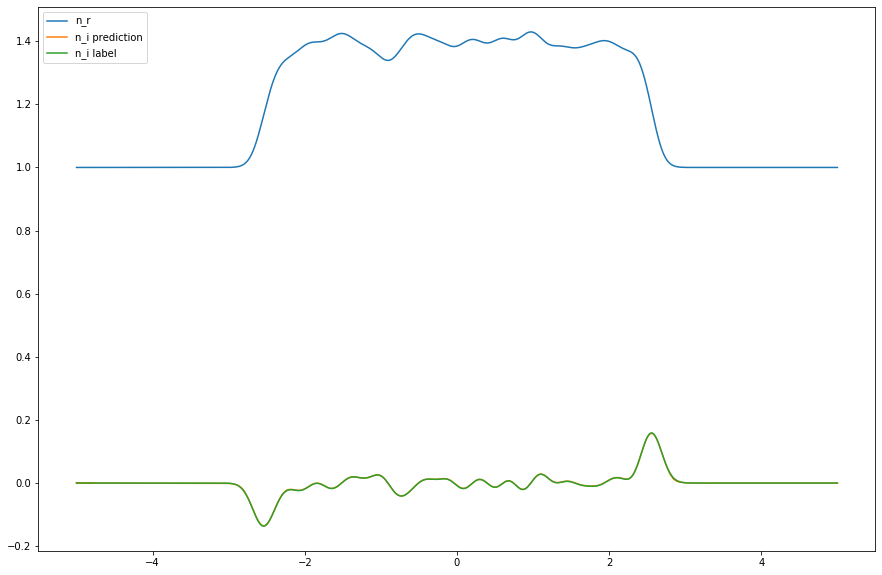

In [39]:
nr, ni, ni_pred, k = plot_prediction(validation_loader, model, grid, 
                                     #nr_mean, nr_std, ni_mean, ni_std, 
                                     idx=0, k=None)
plt.savefig(path_plots + which_model + '_Prediction.pdf')

The intensity with the label potential like this...

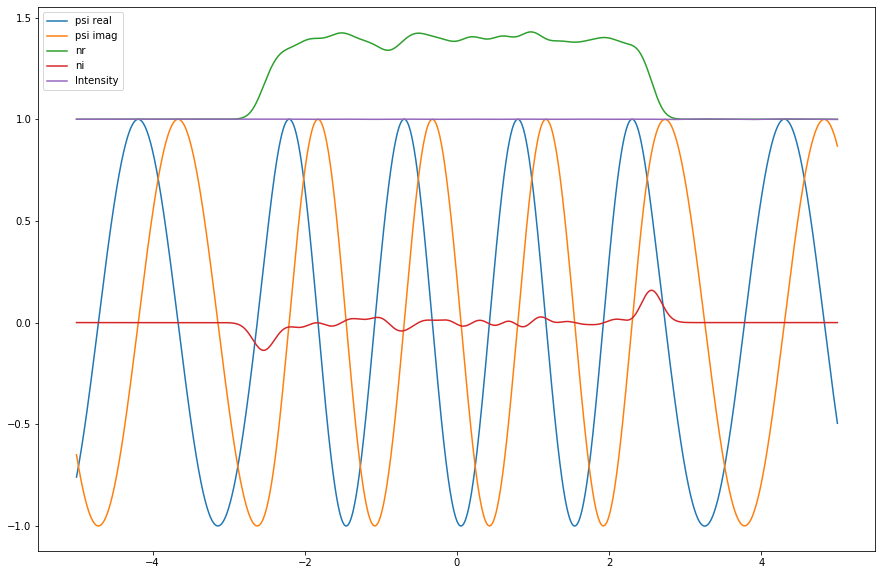

In [40]:
Int = plot_psi(grid, stepsize, n = nr + 1j*ni, Amp = 1, k=k)

And the intensity with the predicted potential like this...

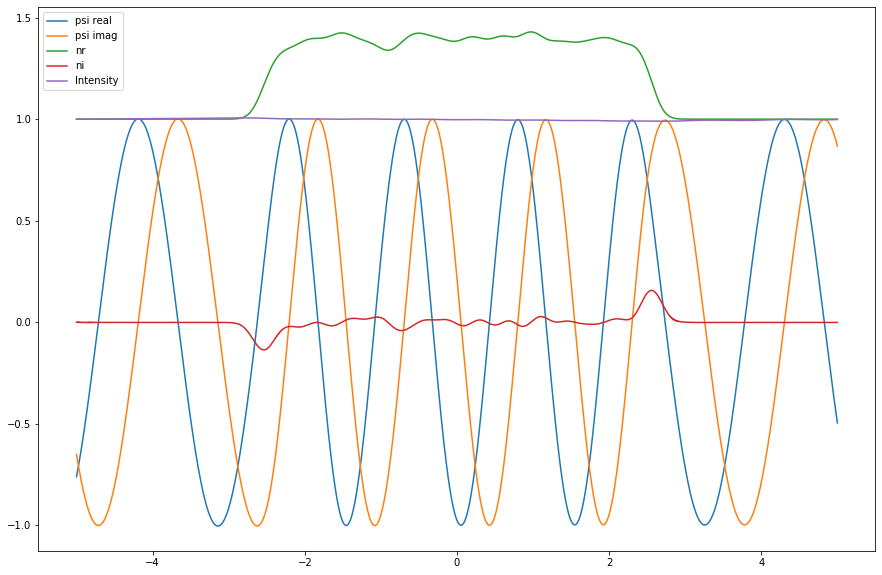

In [43]:
Int_pred = plot_psi(grid, stepsize, n = nr + 1j*ni_pred, Amp = 1, k=k)
plt.savefig(path_plots + which_model + '_CI.pdf')

The differences between the predicted potentials and intensities like this...

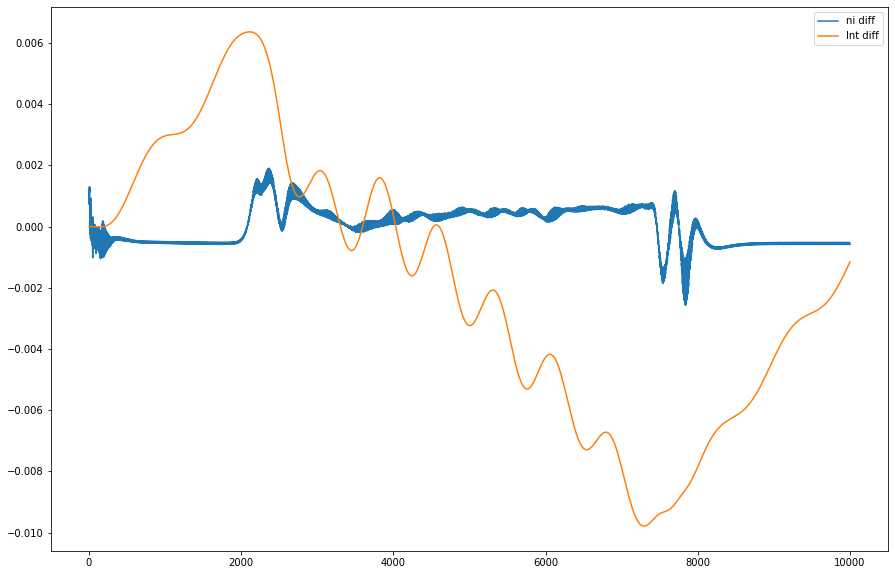

In [44]:
plt.plot(ni_pred-ni, label = 'ni diff')
plt.plot(Int_pred - Int, label = 'Int diff')
plt.legend(loc='upper right')
plt.savefig(path_plots + which_model + '_Diff.pdf')

The label intensity vs the predicted

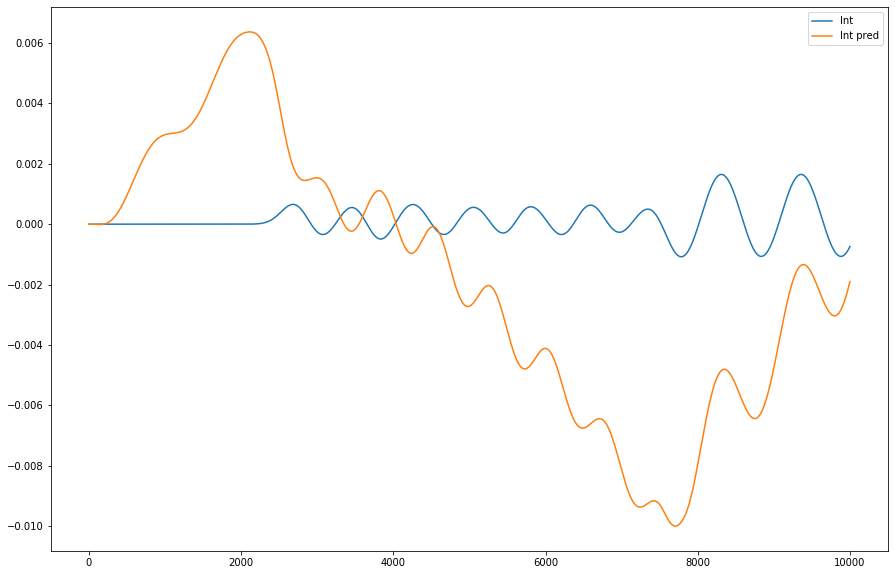

In [45]:
plt.plot(Int -1, label = 'Int')
plt.plot(Int_pred -1, label = 'Int pred')
plt.legend(loc='upper right')

### Special Cases

In [46]:
plt.rcParams['figure.figsize'] = [15,10]

knr:  torch.Size([8, 10001])
ni_pred:  torch.Size([10000])
nr:  torch.Size([10001])
4.0


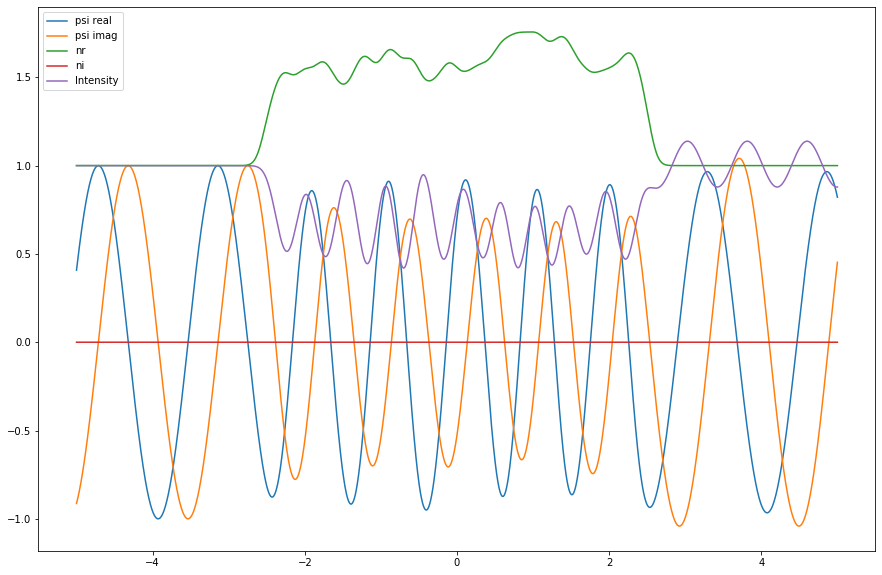

In [47]:
# numerov wave to just nr (what about the intensity? it shouldnt be wave-y)

idx = np.random.randint(8)

item = next(iter(validation_loader))

knr = item['k_n_r']
print('knr: ', knr.size())
ni_pred = model(knr)[idx]
print('ni_pred: ', ni_pred.size())

nr = knr[idx]
print('nr: ', nr.size())

k = DeNorm(knr[idx][0].cpu().numpy(), nr_mean, nr_std)
print(k)
n = DeNorm(nr.cpu().numpy() , nr_mean, nr_std)# + 1j*ni_pred.detach().numpy()
plot_psi(grid, stepsize, n, Amp=1, k=k, plot = True)

plt.savefig(path_plots + '_onlynr.pdf')

### Test

In [29]:
if do_create_test_data:
    generate_init_data_diverse(1000, path = path_test_data, x = grid, dx = stepsize)

In [48]:
#nr_mean_test, nr_std_test, ni_mean_test, ni_std_test = calc_mean_std(3000, path_test_data)
nr_mean_test, nr_std_test, ni_mean_test, ni_std_test = 0,1,0,1

In [49]:
transform_test = transforms.Compose([#Normalize((nr_mean_test, ni_mean_test), (nr_std_test, ni_std_test)),
                                    ToTensor(device)
                                   ])

In [50]:
initial_dataset_test = InitialDataset(csv_file = path_test_data + 'k_values.csv', 
                                   root_dir = path_test_data,
                                   transform = transform_test)

In [51]:
test_loader, _ = get_dataloaders(initial_dataset_test, 
                                                  batch_size = 6, 
                                                  validation_split = 0, 
                                                  shuffle_dataset = False, 
                                                  random_seed= 42)

762
9.791156480787322e-05


<function matplotlib.pyplot.show(*args, **kw)>

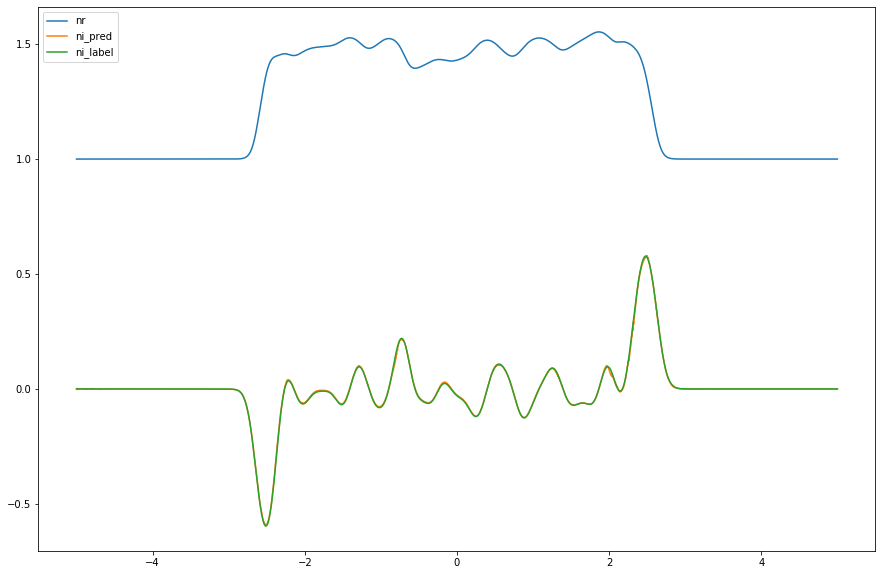

In [76]:
idx = np.random.randint(3000)
print(idx)

data = initial_dataset_test[idx]['k_n_r'].view(1,-1)
out = model(data)
label = initial_dataset_test[idx]['n_i']

criterion = torch.nn.MSELoss()
print(criterion(out[0],label).item() * 8)

plt.plot(grid, data[0][1:].detach().cpu().numpy(), label='nr')
#plt.plot(grid, DeNorm(data[0][1:].detach().cpu().numpy(),nr_mean_test,nr_std_test), label='nr')
plt.plot(grid, DeNorm(out[0].detach().cpu().numpy(),ni_mean_test,ni_std_test), label = 'ni_pred')
plt.plot(grid, DeNorm(label.detach().cpu().numpy(),ni_mean_test,ni_std_test), label = 'ni_label')
plt.legend(loc='upper left')
plt.show


idx:  1
knr:  tensor([[9., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [5., 1., 1.,  ..., 1., 1., 1.],
        [4., 1., 1.,  ..., 1., 1., 1.],
        [4., 1., 1.,  ..., 1., 1., 1.],
        [9., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0')
real k:  1.0
new k:  1
knr:  tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0')
max Int:  1.0380481355144817
min Int:  0.9791762458519705


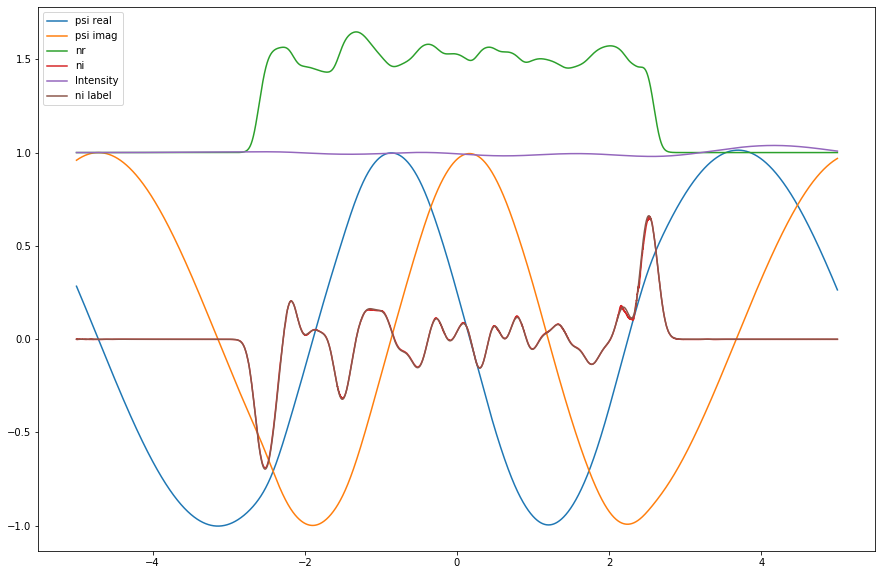

In [110]:
# predict ni for other k - does that work...?

idx = np.random.randint(6)
print('idx: ',idx)

item = next(iter(test_loader))

knr = item['k_n_r']
print('knr: ', knr)

ni = DeNorm(item['n_i'][idx].detach().cpu().numpy(), ni_mean_test, ni_std_test)
k_real = DeNorm(knr[idx][0].detach().cpu().numpy(), nr_mean_test, nr_std_test )
print('real k: ', k_real )

k_new = 1 #np.random.randint(1,11) # np.around(k_real)
print('new k: ', k_new)

knr[:,0] = (k_new - nr_mean_test)/nr_std_test # normalize
print('knr: ',knr)

ni_pred = model(knr)[idx]
#print('ni_pred: ', ni_pred.size())

#print('new k normalized: ',knr[idx][0].cpu().numpy())
k = knr[idx][0].cpu().numpy()
#print('new k: ', k*nr_std + nr_mean)
nr = DeNorm(knr[idx].cpu().numpy(), nr_mean_test, nr_std_test)[1:]
ni_pred = DeNorm(ni_pred.detach().cpu().numpy(), ni_mean_test, ni_std_test)
n = nr + 1j*ni_pred
Int_pred = plot_psi(grid, stepsize, n, Amp=1, k=k_new, plot = True)
#Int_pred = plot_psi(grid, stepsize, n, Amp=1, k=k_real, plot = True)
#plt.plot(grid, ni_pred, label='ni')
plt.plot(grid, ni, label='ni label')
plt.legend(loc='upper left')

plt.savefig(path_plots + which_model + '_differentk.pdf')

print('max Int: ',np.max(Int_pred))
print('min Int: ',np.min(Int_pred))


### Treshold CI Check

In [41]:
# check for all in testset if CI without ni

Amp = 1
Tresh = [0.5,0.2,0.1,0.05,0.03]
over_tresh = np.zeros(len(Tresh))

for j,batch in enumerate(test_loader):
    
    knrs = batch['k_n_r']
    nis = batch['n_i']
    for knr,ni in zip(knrs,nis):
        k = DeNorm(knr[0].detach().cpu().numpy(), nr_mean_test, nr_std_test)
        nr = DeNorm(knr[1:].detach().cpu().numpy(), nr_mean_test, nr_std_test)
        
        Int = plot_psi(grid, stepsize, n=nr, Amp=Amp, k=k, plot = False)
        
        rel_err = np.max((np.abs(Int - Amp)/Amp))
        
        for i,tr in enumerate(Tresh):
            if  rel_err > tr:
                over_tresh[i] += 1
    if j%10 == 0:
        print('{}/{}, {}:{}, {}:{}, {}:{}, {}:{}, {}:{}'.format(
            j,len(test_loader), Tresh[0], over_tresh[0], Tresh[1], over_tresh[1], 
                  Tresh[2], over_tresh[2], Tresh[3], over_tresh[3], Tresh[4], over_tresh[4]))

0/500, 0.5:3.0, 0.2:6.0, 0.1:6.0, 0.05:6.0, 0.03:6.0
10/500, 0.5:34.0, 0.2:66.0, 0.1:66.0, 0.05:66.0, 0.03:66.0
20/500, 0.5:78.0, 0.2:126.0, 0.1:126.0, 0.05:126.0, 0.03:126.0
30/500, 0.5:121.0, 0.2:186.0, 0.1:186.0, 0.05:186.0, 0.03:186.0
40/500, 0.5:166.0, 0.2:246.0, 0.1:246.0, 0.05:246.0, 0.03:246.0
50/500, 0.5:203.0, 0.2:306.0, 0.1:306.0, 0.05:306.0, 0.03:306.0
60/500, 0.5:241.0, 0.2:366.0, 0.1:366.0, 0.05:366.0, 0.03:366.0
70/500, 0.5:281.0, 0.2:426.0, 0.1:426.0, 0.05:426.0, 0.03:426.0
80/500, 0.5:320.0, 0.2:486.0, 0.1:486.0, 0.05:486.0, 0.03:486.0
90/500, 0.5:360.0, 0.2:546.0, 0.1:546.0, 0.05:546.0, 0.03:546.0
100/500, 0.5:393.0, 0.2:606.0, 0.1:606.0, 0.05:606.0, 0.03:606.0
110/500, 0.5:430.0, 0.2:666.0, 0.1:666.0, 0.05:666.0, 0.03:666.0
120/500, 0.5:471.0, 0.2:726.0, 0.1:726.0, 0.05:726.0, 0.03:726.0
130/500, 0.5:508.0, 0.2:786.0, 0.1:786.0, 0.05:786.0, 0.03:786.0
140/500, 0.5:545.0, 0.2:846.0, 0.1:846.0, 0.05:846.0, 0.03:846.0
150/500, 0.5:583.0, 0.2:906.0, 0.1:906.0, 0.05:906.0

[0 1 2 3 4 5]
[1880.0, 1120.0, 0.0, 0.0, 0.0, 0.0]
['>0.5', '0.2 - 0.5', '0.1 - 0.2', '0.05 - 0.1', '0.03 - 0.05', '<0.03']


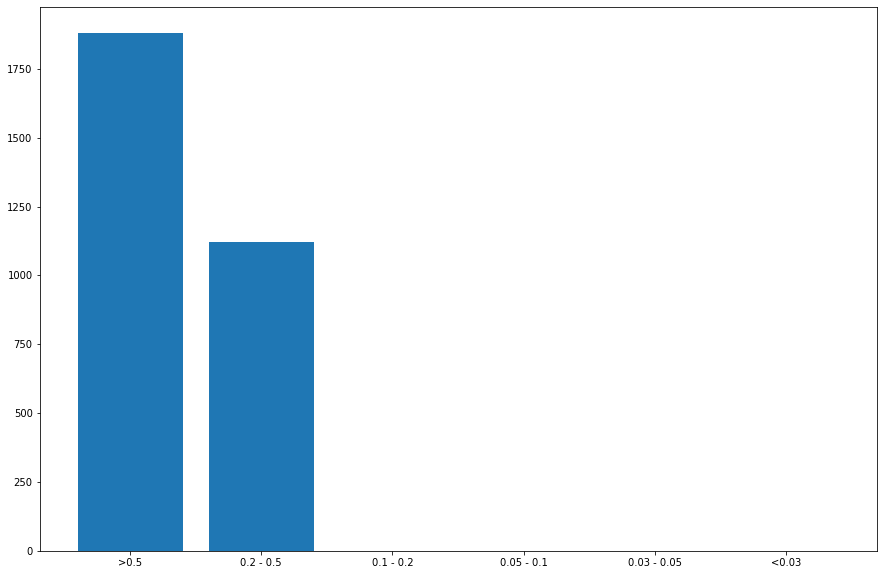

In [42]:
plot_intensity_bars(Tresh, over_tresh, path_plots + 'bars_hermitean.pdf')

In [43]:
# check for all in testset if CI with ni label

Amp = 1
Tresh = [0.5,0.2,0.1,0.05,0.03]
over_tresh = np.zeros(len(Tresh))

for j,batch in enumerate(test_loader):
    
    knrs = batch['k_n_r']
    nis = batch['n_i']
    for knr,ni in zip(knrs,nis):
        k = DeNorm(knr[0].detach().cpu().numpy(), nr_mean_test, nr_std_test)
        
        nr = DeNorm(knr[1:].detach().cpu().numpy(), nr_mean_test, nr_std_test)
        ni = DeNorm(ni.cpu().numpy(), ni_mean_test, ni_std_test)
        
        Int = plot_psi(grid, stepsize, n=nr + 1j*ni, Amp=Amp, k=k, plot = False)
        
        rel_err = np.max((np.abs(Int - Amp)/Amp))
        
        for i,tr in enumerate(Tresh):
            if  rel_err > tr:
                over_tresh[i] += 1
    if j%10 == 0:
        print('{}/{}, {}:{}, {}:{}, {}:{}, {}:{}, {}:{}'.format(
            j,len(test_loader), Tresh[0], over_tresh[0], Tresh[1], over_tresh[1], 
                  Tresh[2], over_tresh[2], Tresh[3], over_tresh[3], Tresh[4], over_tresh[4]))

0/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:0.0
10/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:0.0
20/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:0.0
30/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:0.0
40/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:0.0
50/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:1.0
60/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:2.0
70/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:2.0
80/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:2.0
90/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:4.0
100/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:4.0
110/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:4.0
120/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:4.0
130/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:4.0
140/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:4.0
150/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:4.0
160/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:6.0
170/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:6.0
180/500, 0.5:0.0, 0.2

[0 1 2 3 4 5]
[0.0, 0.0, 0.0, 8.0, 29.0, 2963.0]
['>0.5', '0.2 - 0.5', '0.1 - 0.2', '0.05 - 0.1', '0.03 - 0.05', '<0.03']


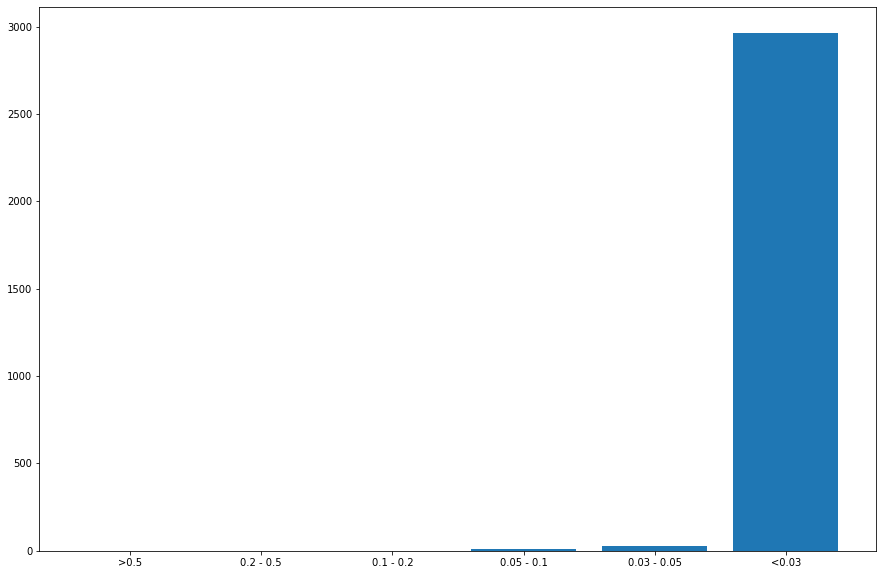

In [44]:
plot_intensity_bars(Tresh, over_tresh, path_plots + 'bars_label.pdf')

In [111]:
# check for all in testset if CI with ni pred

Amp = 1
Tresh = [0.5,0.2,0.1,0.05,0.03]
nipred_over_tresh = np.zeros([len(Tresh), 10]) #tresh, k_real
nipred_how_many_k = np.zeros(10)

for j,batch in enumerate(test_loader):
    
    knrs = batch['k_n_r']
    nis = batch['n_i']
    for knr,ni in zip(knrs,nis):
        k = int(np.around(DeNorm(knr[0].detach().cpu().numpy(), nr_mean_test, nr_std_test)))
        
        nipred_how_many_k[k-1] += 1
        
        ni_pred = model(knr.view(1,-1))[0]
        
        nr = DeNorm(knr[1:].detach().cpu().numpy(), nr_mean_test, nr_std_test)
        ni_pred = DeNorm(ni_pred.detach().cpu().numpy(), ni_mean_test, ni_std_test)
        
        Int_pred = plot_psi(grid, stepsize, n=nr + 1j*ni_pred, Amp=Amp, k=k, plot = False)
        
        rel_err = np.max((np.abs(Int_pred - Amp)/Amp))
        
        for i,tr in enumerate(Tresh):
            if  rel_err > tr:
                nipred_over_tresh[i, k-1] += 1
    if j%10 == 0:
        print('{}/{}, {}:{}, {}:{}, {}:{}, {}:{}, {}:{}'.format(
            j,len(test_loader), np.sum(Tresh[0]), np.sum(nipred_over_tresh[0]), 
            np.sum(Tresh[1]), np.sum(nipred_over_tresh[1]), 
            np.sum(Tresh[2]), np.sum(nipred_over_tresh[2]), 
            np.sum(Tresh[3]), np.sum(nipred_over_tresh[3]), 
            np.sum(Tresh[4]), np.sum(nipred_over_tresh[4])))


0/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:3.0, 0.03:4.0
10/500, 0.5:0.0, 0.2:0.0, 0.1:3.0, 0.05:35.0, 0.03:54.0
20/500, 0.5:0.0, 0.2:0.0, 0.1:5.0, 0.05:67.0, 0.03:100.0
30/500, 0.5:0.0, 0.2:0.0, 0.1:7.0, 0.05:105.0, 0.03:150.0
40/500, 0.5:0.0, 0.2:0.0, 0.1:8.0, 0.05:134.0, 0.03:196.0
50/500, 0.5:0.0, 0.2:0.0, 0.1:9.0, 0.05:162.0, 0.03:243.0
60/500, 0.5:0.0, 0.2:0.0, 0.1:13.0, 0.05:187.0, 0.03:290.0
70/500, 0.5:0.0, 0.2:0.0, 0.1:15.0, 0.05:211.0, 0.03:339.0
80/500, 0.5:0.0, 0.2:0.0, 0.1:17.0, 0.05:242.0, 0.03:390.0
90/500, 0.5:0.0, 0.2:0.0, 0.1:20.0, 0.05:269.0, 0.03:436.0
100/500, 0.5:0.0, 0.2:0.0, 0.1:23.0, 0.05:307.0, 0.03:484.0
110/500, 0.5:0.0, 0.2:1.0, 0.1:27.0, 0.05:344.0, 0.03:534.0
120/500, 0.5:0.0, 0.2:1.0, 0.1:29.0, 0.05:366.0, 0.03:581.0
130/500, 0.5:0.0, 0.2:1.0, 0.1:31.0, 0.05:405.0, 0.03:624.0
140/500, 0.5:0.0, 0.2:1.0, 0.1:34.0, 0.05:432.0, 0.03:671.0
150/500, 0.5:0.0, 0.2:1.0, 0.1:35.0, 0.05:465.0, 0.03:717.0
160/500, 0.5:0.0, 0.2:1.0, 0.1:37.0, 0.05:498.0, 0.03:765.0
170/

[0 1 2 3 4 5]
[1.0, 5.0, 110.0, 1427.0, 815.0, 642.0]
['>0.5', '0.2 - 0.5', '0.1 - 0.2', '0.05 - 0.1', '0.03 - 0.05', '<0.03']


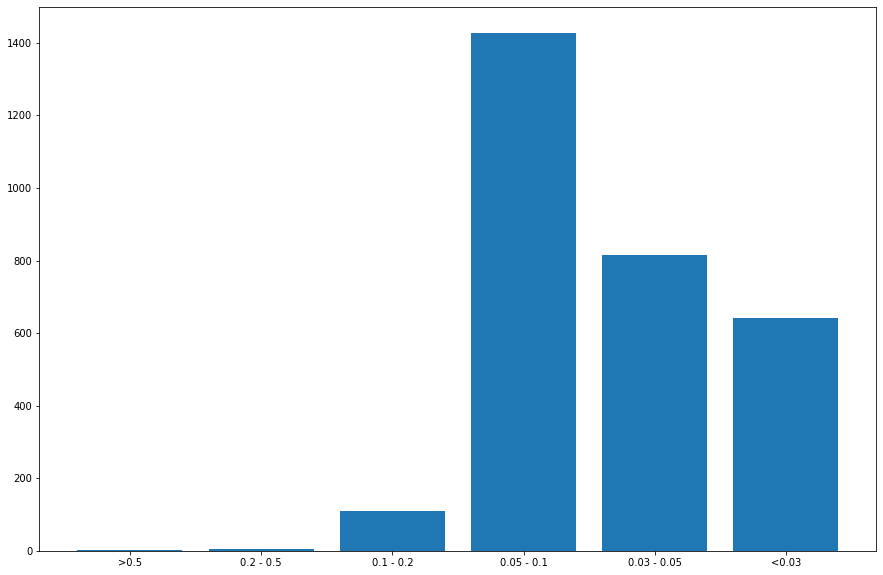

In [112]:
nipred_sum_over_tresh = np.zeros(len(nipred_over_tresh))
for i in range(len(nipred_sum_over_tresh)):
    nipred_sum_over_tresh[i] = int(np.sum(nipred_over_tresh[i]))

plot_intensity_bars(Tresh, nipred_sum_over_tresh, path_plots + which_model + '_bars_prediction.pdf')

0.5 0.0003703703703703704
0.2 0.0021907013396375097
0.1 0.03755060030042394
0.05 0.5098788489650771
0.03 0.7762792489057424


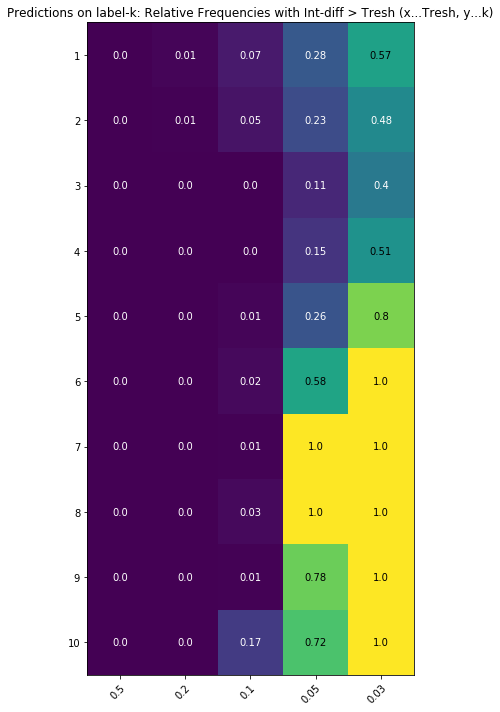

In [113]:
# map for the relative frequencies against the treshhold

k_real = list(range(1,11))

nipred_rel_freq = np.copy(nipred_over_tresh)

for i in range(len(nipred_rel_freq)):
    nipred_rel_freq[i,:] = nipred_rel_freq[i,:]/nipred_how_many_k
    print(Tresh[i], np.mean(nipred_rel_freq[i,:]))
    
nipred_rel_freq = np.transpose(nipred_rel_freq) 

textcolors=["black", "white"]
textcolor_tresh = np.max(nipred_rel_freq)/2

fig, ax = plt.subplots()
im = ax.imshow(nipred_rel_freq)

# We want to show all ticks...
ax.set_xticks(np.arange(len(Tresh)))
ax.set_yticks(np.arange(len(k_real)))
# ... and label them with the respective list entries
ax.set_xticklabels(Tresh)
ax.set_yticklabels(k_real)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(k_real)):
    for j in range(len(Tresh)):
        text = ax.text(j, i, np.around(nipred_rel_freq[i, j], decimals=2),
                       ha="center", va="center",
                       color=textcolors[int(nipred_rel_freq[i,j] < textcolor_tresh)])

ax.set_title("Predictions on label-k: Relative Frequencies with Int-diff > Tresh (x...Tresh, y...k)")
fig.tight_layout()
plt.savefig(path_plots + which_model + '_nipred_RelFreq_gTresh.pdf')
plt.show()

In [114]:
# check for all in testset with random k if CI

Amp = 1
Tresh = [0.5,0.2,0.1,0.05,0.03]
over_tresh = np.zeros([len(Tresh), 10, 10]) #tresh, k_real, k_new
how_many_k = np.zeros([10,10]) # k_real, k_new

for j,batch in enumerate(test_loader):
    
    knrs = batch['k_n_r']
    nis = batch['n_i']
    for knr,ni in zip(knrs,nis):
        
        k_real = int(np.around(DeNorm(knr[0].detach().cpu().numpy(), nr_mean_test, nr_std_test)))
        k_new = np.random.randint(1,11)
        #print(k_real, k_new)
        
        
        how_many_k[k_real-1, k_new-1] += 1        
        
        knr[0] = (k_new - nr_mean_test) / nr_std_test
        ni_pred = model(knr.view(1,-1))[0]
        
        nr = DeNorm(knr[1:].detach().cpu().numpy(), nr_mean_test, nr_std_test)
        ni_pred = DeNorm(ni_pred.detach().cpu().numpy(), ni_mean_test, ni_std_test)
        
        Int_pred = plot_psi(grid, stepsize, n=nr + 1j*ni_pred, Amp=Amp, k=k_new, plot = False)
        
        rel_err = np.max((np.abs(Int_pred - Amp)/Amp))
        
        for i,tr in enumerate(Tresh):
            if  rel_err > tr:
                over_tresh[i, k_real-1, k_new-1] += 1
    if j%10 == 0:
        print('{}/{}, {}:{}, {}:{}, {}:{}, {}:{}, {}:{}'.format(
            j,len(test_loader), np.sum(Tresh[0]), np.sum(over_tresh[0]), 
            np.sum(Tresh[1]), np.sum(over_tresh[1]), 
            np.sum(Tresh[2]), np.sum(over_tresh[2]), 
            np.sum(Tresh[3]), np.sum(over_tresh[3]), 
            np.sum(Tresh[4]), np.sum(over_tresh[4])))
        
    #break

0/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:4.0, 0.03:5.0
10/500, 0.5:2.0, 0.2:3.0, 0.1:6.0, 0.05:46.0, 0.03:60.0
20/500, 0.5:3.0, 0.2:5.0, 0.1:12.0, 0.05:76.0, 0.03:104.0
30/500, 0.5:6.0, 0.2:11.0, 0.1:22.0, 0.05:115.0, 0.03:156.0
40/500, 0.5:6.0, 0.2:15.0, 0.1:28.0, 0.05:151.0, 0.03:204.0
50/500, 0.5:10.0, 0.2:21.0, 0.1:40.0, 0.05:192.0, 0.03:257.0
60/500, 0.5:11.0, 0.2:27.0, 0.1:47.0, 0.05:232.0, 0.03:307.0
70/500, 0.5:18.0, 0.2:38.0, 0.1:60.0, 0.05:271.0, 0.03:360.0
80/500, 0.5:20.0, 0.2:42.0, 0.1:67.0, 0.05:312.0, 0.03:413.0
90/500, 0.5:23.0, 0.2:47.0, 0.1:76.0, 0.05:350.0, 0.03:464.0
100/500, 0.5:28.0, 0.2:55.0, 0.1:87.0, 0.05:386.0, 0.03:513.0
110/500, 0.5:29.0, 0.2:56.0, 0.1:91.0, 0.05:420.0, 0.03:561.0
120/500, 0.5:30.0, 0.2:61.0, 0.1:99.0, 0.05:461.0, 0.03:616.0
130/500, 0.5:32.0, 0.2:68.0, 0.1:112.0, 0.05:503.0, 0.03:669.0
140/500, 0.5:33.0, 0.2:72.0, 0.1:118.0, 0.05:539.0, 0.03:716.0
150/500, 0.5:34.0, 0.2:75.0, 0.1:124.0, 0.05:574.0, 0.03:759.0
160/500, 0.5:38.0, 0.2:81.0, 0.1:

[0 1 2 3 4 5]
[94.0, 131.0, 199.0, 1423.0, 651.0, 502.0]
['>0.5', '0.2 - 0.5', '0.1 - 0.2', '0.05 - 0.1', '0.03 - 0.05', '<0.03']


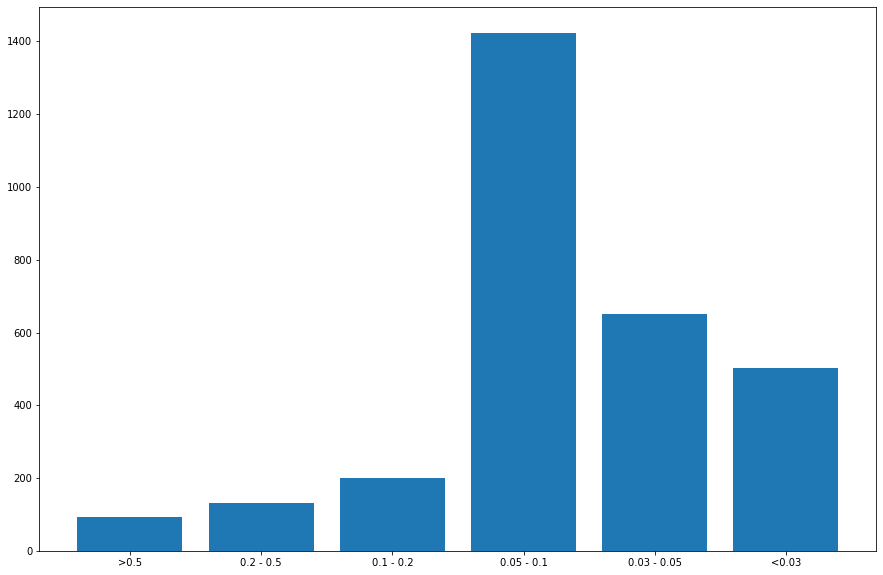

In [115]:
sum_over_tresh = np.zeros(len(over_tresh))
for i in range(len(sum_over_tresh)):
    sum_over_tresh[i] = int(np.sum(over_tresh[i]))

plot_intensity_bars(Tresh, sum_over_tresh, path_plots + which_model + '_bars_differentk.pdf')

2498.0
24.98


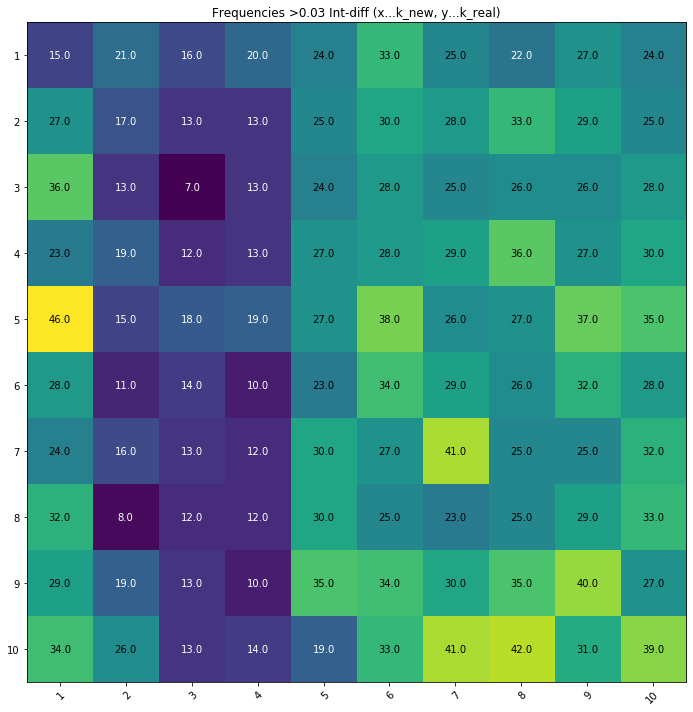

In [116]:
# map for the frequencies

tres_ind = 4

k_real = list(range(1,11))
k_new = list(range(1,11))

freq = over_tresh[tres_ind]
print(np.sum(freq))
print(np.mean(freq))

textcolors=["black", "white"]
textcolor_tresh = np.max(freq)/2

fig, ax = plt.subplots()
im = ax.imshow(freq)

# We want to show all ticks...
ax.set_xticks(np.arange(len(k_new)))
ax.set_yticks(np.arange(len(k_real)))
# ... and label them with the respective list entries
ax.set_xticklabels(k_new)
ax.set_yticklabels(k_real)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(k_real)):
    for j in range(len(k_new)):
        text = ax.text(j, i, freq[i, j],
                       ha="center", va="center",
                       color=textcolors[int(freq[i,j] < textcolor_tresh)])

ax.set_title("Frequencies >{} Int-diff (x...k_new, y...k_real)".format(Tresh[tres_ind]))
fig.tight_layout()
plt.show()

3000.0
30.0


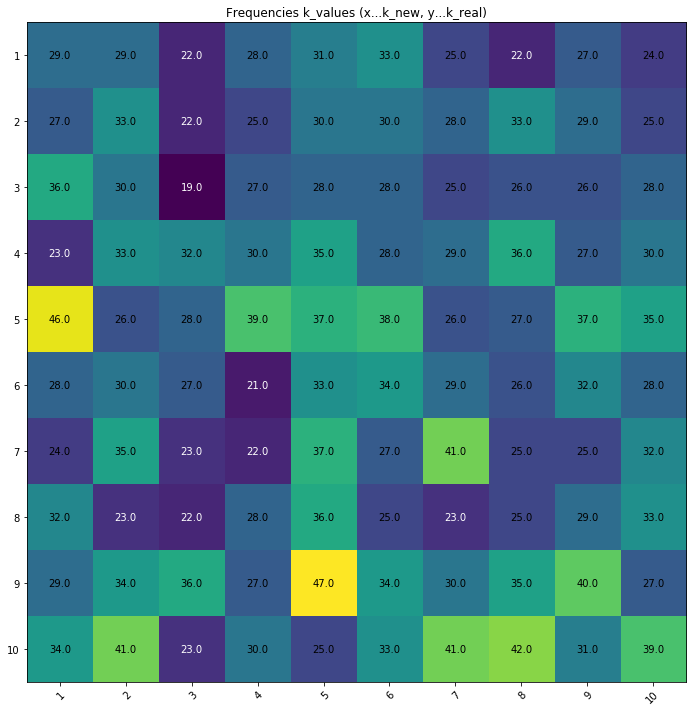

In [117]:
# map for the k values

k_real = list(range(1,11))
k_new = list(range(1,11))

freq_k = how_many_k
print(np.sum(freq_k))
print(np.mean(freq_k))

textcolors=["black", "white"]
textcolor_tresh = np.max(freq_k)/2

fig, ax = plt.subplots()
im = ax.imshow(freq_k)

# We want to show all ticks...
ax.set_xticks(np.arange(len(k_new)))
ax.set_yticks(np.arange(len(k_real)))
# ... and label them with the respective list entries
ax.set_xticklabels(k_new)
ax.set_yticklabels(k_real)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(k_real)):
    for j in range(len(k_new)):
        text = ax.text(j, i, np.around(freq_k[i, j], decimals=2),
                       ha="center", va="center",
                       color=textcolors[int(freq_k[i,j] < textcolor_tresh)])

ax.set_title("Frequencies k_values (x...k_new, y...k_real)")
fig.tight_layout()
plt.show()

2498.0
0.8270228550024771


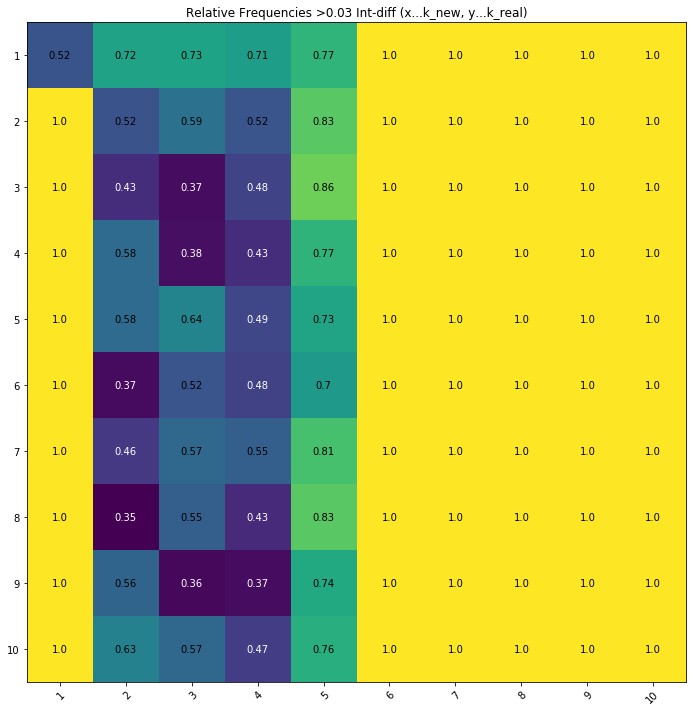

In [124]:
# map for the relative frequencies

tres_ind = 4 # [0.5, 0.2, 0.1, 0.05, 0.03]

k_real = list(range(1,11))
k_new = list(range(1,11))

rel_freq = over_tresh[tres_ind]/how_many_k
print(np.sum(over_tresh[tres_ind]))
print(np.mean(rel_freq))

textcolors=["black", "white"]
textcolor_tresh = np.max(rel_freq)/2

fig, ax = plt.subplots()
im = ax.imshow(rel_freq)

# We want to show all ticks...
ax.set_xticks(np.arange(len(k_new)))
ax.set_yticks(np.arange(len(k_real)))
# ... and label them with the respective list entries
ax.set_xticklabels(k_new)
ax.set_yticklabels(k_real)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(k_real)):
    for j in range(len(k_new)):
        text = ax.text(j, i, np.around(rel_freq[i, j], decimals=2),
                       ha="center", va="center",
                       color=textcolors[int(rel_freq[i,j] < textcolor_tresh)])

ax.set_title("Relative Frequencies >{} Int-diff (x...k_new, y...k_real)".format(Tresh[tres_ind]))
fig.tight_layout()
plt.savefig(path_plots + which_model + '_RelFreq_Int_' + str(Tresh[tres_ind]) + '.pdf')
plt.show()